# Cargo 2000 Freight Tracking & Tracing

URL:

https://archive.ics.uci.edu/dataset/382/cargo+2000+freight+tracking+and+tracing

https://www.kaggle.com/datasets/crawford/cargo-2000-dataset

## Import libaries

In [ ]:
# --- 1. Core Data Science and Graph Foundation ---
!pip install pandas numpy scikit-learn networkx statsmodels
!pip install matplotlib seaborn

# --- 2. Graph Neural Networks (PyTorch Geometric) ---
!pip install torch torchvision torchaudio
!pip install torch_geometric

# --- 3. Time-Series Forecasting and Advanced Anomaly Detection ---
!pip install darts prophet
!pip install statsforecast
!pip install pyod

# --- 4. Frequent Subgraph Mining (gSpan) ---
!pip install gspan_mining

# --- 5. Visualisation & Geo/Neo4j Integration ---
!pip install py2neo neo4j plotly folium geopy ydata-profiling shap

# --- Optional ML/Utilities (Reduced focus) ---
!pip install xgboost lightgbm mlflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.6/354.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# --- Core Data Stack and Utilities ---
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import warnings, os, datetime
warnings.filterwarnings("ignore")

# --- Graphs & Mining ---
import networkx as nx
# The gSpan library for frequent subgraph pattern mining
from gspan_mining.config import parser
from gspan_mining.main import gSpan
# Neo4j integration
from neo4j import GraphDatabase
from py2neo import Graph

# --- Graph Neural Networks (PyTorch Geometric) ---
import torch
from torch_geometric.data import Data
# We will explicitly import the necessary layers like SAGEConv for GraphSAGE
from torch_geometric.nn import SAGEConv, GATConv

# --- Predictive Tasks (Time Series, Anomaly Detection & Standard ML) ---
from darts import TimeSeries
from darts.models import RNNModel, ARIMA, Prophet
from pyod.models.iforest import IForest # Isolation Forest
from pyod.models.auto_encoder import AutoEncoder # Deep Learning anomaly detection

# Standard ML tools for clustering, evaluation, and baselines
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans # For clustering GraphSAGE embeddings
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report
import xgboost as xgb, lightgbm as lgb
# Optional: MLflow for experiment tracking
import mlflow

# --- Visualisation & Geo ---
import plotly.express as px
import plotly.graph_objects as go
import folium
import shap
from ydata_profiling import ProfileReport
from geopy.geocoders import Nominatim

## Import dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crawford/cargo-2000-dataset")

print("Path to dataset files:", path)

100%|██████████| 312k/312k [00:00<00:00, 63.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/crawford/cargo-2000-dataset/versions/2


In [ ]:
base = os.listdir(path)
print("Files in the dataset folder:", base)

Files in the dataset folder: ['column_descriptions.txt', 'c2k_data_comma.csv']


In [ ]:
csv_file = [f for f in base if f.endswith('.csv')][0]
data = os.path.join(path, csv_file)
df = pd.read_csv(data)
display(df)

,nr,i1_legid,i1_rcs_p,i1_rcs_e,i1_dep_1_p,i1_dep_1_e,i1_dep_1_place,i1_rcf_1_p,i1_rcf_1_e,i1_rcf_1_place,...,o_dep_3_p,o_dep_3_e,o_dep_3_place,o_rcf_3_p,o_rcf_3_e,o_rcf_3_place,o_dlv_p,o_dlv_e,o_hops,legs
0,0.0,5182.0,199.0,218.0,210.0,215.0,609.0,935.0,736.0,256.0,...,?,?,?,?,?,?,780.0,434.0,1.0,2.0
1,1.0,6523.0,844.0,584.0,90.0,297.0,700.0,1935.0,1415.0,431.0,...,?,?,?,?,?,?,3870.0,445.0,1.0,2.0
2,2.0,5878.0,4380.0,4119.0,90.0,280.0,456.0,905.0,547.0,700.0,...,?,?,?,?,?,?,550.0,1520.0,1.0,1.0
3,3.0,1275.0,759.0,169.0,240.0,777.0,173.0,340.0,577.0,349.0,...,?,?,?,?,?,?,3780.0,159.0,1.0,1.0
4,4.0,8117.0,1597.0,1485.0,150.0,241.0,411.0,585.0,612.0,128.0,...,?,?,?,?,?,?,4140.0,4797.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3938,3939.0,4225.0,122.0,19.0,240.0,278.0,815.0,830.0,761.0,174.0,...,?,?,?,?,?,?,1665.0,1300.0,2.0,3.0
3939,3940.0,14017.0,2028.0,413.0,270.0,1825.0,605.0,2610.0,2535.0,349.0,...,?,?,?,?,?,?,3780.0,807.0,2.0,1.0
3940,3941.0,4660.0,1356.0,178.0,240.0,1359.0,815.0,760.0,716.0,609.0,...,?,?,?,?,?,?,5100.0,4381.0,2.0,1.0
3941,3942.0,6472.0,2692.0,1856.0,90.0,867.0,700.0,1060.0,1049.0,113.0,...,?,?,?,?,?,?,3780.0,945.0,2.0,2.0


In [ ]:
display(df)

,nr,i1_legid,i1_rcs_p,i1_rcs_e,i1_dep_1_p,i1_dep_1_e,i1_dep_1_place,i1_rcf_1_p,i1_rcf_1_e,i1_rcf_1_place,...,o_dep_3_p,o_dep_3_e,o_dep_3_place,o_rcf_3_p,o_rcf_3_e,o_rcf_3_place,o_dlv_p,o_dlv_e,o_hops,legs
0,0.0,5182.0,199.0,218.0,210.0,215.0,609.0,935.0,736.0,256.0,...,?,?,?,?,?,?,780.0,434.0,1.0,2.0
1,1.0,6523.0,844.0,584.0,90.0,297.0,700.0,1935.0,1415.0,431.0,...,?,?,?,?,?,?,3870.0,445.0,1.0,2.0
2,2.0,5878.0,4380.0,4119.0,90.0,280.0,456.0,905.0,547.0,700.0,...,?,?,?,?,?,?,550.0,1520.0,1.0,1.0
3,3.0,1275.0,759.0,169.0,240.0,777.0,173.0,340.0,577.0,349.0,...,?,?,?,?,?,?,3780.0,159.0,1.0,1.0
4,4.0,8117.0,1597.0,1485.0,150.0,241.0,411.0,585.0,612.0,128.0,...,?,?,?,?,?,?,4140.0,4797.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3938,3939.0,4225.0,122.0,19.0,240.0,278.0,815.0,830.0,761.0,174.0,...,?,?,?,?,?,?,1665.0,1300.0,2.0,3.0
3939,3940.0,14017.0,2028.0,413.0,270.0,1825.0,605.0,2610.0,2535.0,349.0,...,?,?,?,?,?,?,3780.0,807.0,2.0,1.0
3940,3941.0,4660.0,1356.0,178.0,240.0,1359.0,815.0,760.0,716.0,609.0,...,?,?,?,?,?,?,5100.0,4381.0,2.0,1.0
3941,3942.0,6472.0,2692.0,1856.0,90.0,867.0,700.0,1060.0,1049.0,113.0,...,?,?,?,?,?,?,3780.0,945.0,2.0,2.0


# data_prep.py

## Data cleaning

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3943 entries, 0 to 3942
Data columns (total 98 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   nr              3942 non-null   float64
 1   i1_legid        3942 non-null   float64
 2   i1_rcs_p        3942 non-null   float64
 3   i1_rcs_e        3942 non-null   float64
 4   i1_dep_1_p      3942 non-null   float64
 5   i1_dep_1_e      3942 non-null   float64
 6   i1_dep_1_place  3942 non-null   float64
 7   i1_rcf_1_p      3942 non-null   float64
 8   i1_rcf_1_e      3942 non-null   float64
 9   i1_rcf_1_place  3942 non-null   float64
 10  i1_dep_2_p      3942 non-null   object 
 11  i1_dep_2_e      3942 non-null   object 
 12  i1_dep_2_place  3942 non-null   object 
 13  i1_rcf_2_p      3942 non-null   object 
 14  i1_rcf_2_e      3942 non-null   object 
 15  i1_rcf_2_place  3942 non-null   object 
 16  i1_dep_3_p      3942 non-null   object 
 17  i1_dep_3_e      3942 non-null   o

In [ ]:
# change all column names
import pandas as pd
import numpy as np

column_rename_map = {
    # General/Process Columns
    'legs': 'Total_Incoming_Legs',
    'nr': 'All_process_ID',

    # --- Incoming Leg 1 (i1) ---
    'i1_legid': 'IN_1_Leg_ID',
    'i1_rcs_p': 'IN_1_CheckIn_Planned_Mins',
    'i1_rcs_e': 'IN_1_CheckIn_Effective_Mins',
    'i1_dep_1_p': 'IN_1_Dep_Seg1_Planned_Mins',
    'i1_dep_1_e': 'IN_1_Dep_Seg1_Effective_Mins',
    'i1_dep_1_place': 'IN_1_Dep_Seg1_Hub_ID',
    'i1_rcf_1_p': 'IN_1_Arr_Seg1_Planned_Mins',
    'i1_rcf_1_e': 'IN_1_Arr_Seg1_Effective_Mins',
    'i1_rcf_1_place': 'IN_1_Arr_Seg1_Hub_ID',
    'i1_dep_2_p': 'IN_1_Dep_Seg2_Planned_Mins',
    'i1_dep_2_e': 'IN_1_Dep_Seg2_Effective_Mins',
    'i1_dep_2_place': 'IN_1_Dep_Seg2_Hub_ID',
    'i1_rcf_2_p': 'IN_1_Arr_Seg2_Planned_Mins',
    'i1_rcf_2_e': 'IN_1_Arr_Seg2_Effective_Mins',
    'i1_rcf_2_place': 'IN_1_Arr_Seg2_Hub_ID',
    'i1_dep_3_p': 'IN_1_Dep_Seg3_Planned_Mins',
    'i1_dep_3_e': 'IN_1_Dep_Seg3_Effective_Mins',
    'i1_dep_3_place': 'IN_1_Dep_Seg3_Hub_ID',
    'i1_rcf_3_p': 'IN_1_Arr_Seg3_Planned_Mins',
    'i1_rcf_3_e': 'IN_1_Arr_Seg3_Effective_Mins',
    'i1_rcf_3_place': 'IN_1_Arr_Seg3_Hub_ID',
    'i1_dlv_p': 'IN_1_Delivery_Planned_Mins',
    'i1_dlv_e': 'IN_1_Delivery_Effective_Mins',
    'i1_hops': 'IN_1_Hops',

    # --- Incoming Leg 2 (i2) --- (Structure repeats)
    'i2_legid': 'IN_2_Leg_ID',
    'i2_rcs_p': 'IN_2_CheckIn_Planned_Mins',
    'i2_rcs_e': 'IN_2_CheckIn_Effective_Mins',
    'i2_dep_1_p': 'IN_2_Dep_Seg1_Planned_Mins',
    'i2_dep_1_e': 'IN_2_Dep_Seg1_Effective_Mins',
    'i2_dep_1_place': 'IN_2_Dep_Seg1_Hub_ID',
    'i2_rcf_1_p': 'IN_2_Arr_Seg1_Planned_Mins',
    'i2_rcf_1_e': 'IN_2_Arr_Seg1_Effective_Mins',
    'i2_rcf_1_place': 'IN_2_Arr_Seg1_Hub_ID',
    'i2_dep_2_p': 'IN_2_Dep_Seg2_Planned_Mins',
    'i2_dep_2_e': 'IN_2_Dep_Seg2_Effective_Mins',
    'i2_dep_2_place': 'IN_2_Dep_Seg2_Hub_ID',
    'i2_rcf_2_p': 'IN_2_Arr_Seg2_Planned_Mins',
    'i2_rcf_2_e': 'IN_2_Arr_Seg2_Effective_Mins',
    'i2_rcf_2_place': 'IN_2_Arr_Seg2_Hub_ID',
    'i2_dep_3_p': 'IN_2_Dep_Seg3_Planned_Mins',
    'i2_dep_3_e': 'IN_2_Dep_Seg3_Effective_Mins',
    'i2_dep_3_place': 'IN_2_Dep_Seg3_Hub_ID',
    'i2_rcf_3_p': 'IN_2_Arr_Seg3_Planned_Mins',
    'i2_rcf_3_e': 'IN_2_Arr_Seg3_Effective_Mins',
    'i2_rcf_3_place': 'IN_2_Arr_Seg3_Hub_ID',
    'i2_dlv_p': 'IN_2_Delivery_Planned_Mins',
    'i2_dlv_e': 'IN_2_Delivery_Effective_Mins',
    'i2_hops': 'IN_2_Hops',

    # --- Incoming Leg 3 (i3) ---
    'i3_legid': 'IN_3_Leg_ID',
    'i3_rcs_p': 'IN_3_CheckIn_Planned_Mins',
    'i3_rcs_e': 'IN_3_CheckIn_Effective_Mins',
    'i3_dep_1_p': 'IN_3_Dep_Seg1_Planned_Mins',
    'i3_dep_1_e': 'IN_3_Dep_Seg1_Effective_Mins',
    'i3_dep_1_place': 'IN_3_Dep_Seg1_Hub_ID',
    'i3_rcf_1_p': 'IN_3_Arr_Seg1_Planned_Mins',
    'i3_rcf_1_e': 'IN_3_Arr_Seg1_Effective_Mins',
    'i3_rcf_1_place': 'IN_3_Arr_Seg1_Hub_ID',
    'i3_dep_2_p': 'IN_3_Dep_Seg2_Planned_Mins',
    'i3_dep_2_e': 'IN_3_Dep_Seg2_Effective_Mins',
    'i3_dep_2_place': 'IN_3_Dep_Seg2_Hub_ID',
    'i3_rcf_2_p': 'IN_3_Arr_Seg2_Planned_Mins',
    'i3_rcf_2_e': 'IN_3_Arr_Seg2_Effective_Mins',
    'i3_rcf_2_place': 'IN_3_Arr_Seg2_Hub_ID',
    'i3_dep_3_p': 'IN_3_Dep_Seg3_Planned_Mins',
    'i3_dep_3_e': 'IN_3_Dep_Seg3_Effective_Mins',
    'i3_dep_3_place': 'IN_3_Dep_Seg3_Hub_ID',
    'i3_rcf_3_p': 'IN_3_Arr_Seg3_Planned_Mins',
    'i3_rcf_3_e': 'IN_3_Arr_Seg3_Effective_Mins',
    'i3_rcf_3_place': 'IN_3_Arr_Seg3_Hub_ID',
    'i3_dlv_p': 'IN_3_Delivery_Planned_Mins',
    'i3_dlv_e': 'IN_3_Delivery_Effective_Mins',
    'i3_hops': 'IN_3_Hops',

    # --- Outgoing Leg (o) --- (Structure repeats)
    'o_legid': 'OUT_Leg_ID',
    'o_rcs_p': 'OUT_CheckIn_Planned_Mins',
    'o_rcs_e': 'OUT_CheckIn_Effective_Mins',
    'o_dep_1_p': 'OUT_Dep_Seg1_Planned_Mins',
    'o_dep_1_e': 'OUT_Dep_Seg1_Effective_Mins',
    'o_dep_1_place': 'OUT_Dep_Seg1_Hub_ID',
    'o_rcf_1_p': 'OUT_Arr_Seg1_Planned_Mins',
    'o_rcf_1_e': 'OUT_Arr_Seg1_Effective_Mins',
    'o_rcf_1_place': 'OUT_Arr_Seg1_Hub_ID',
    'o_dep_2_p': 'OUT_Dep_Seg2_Planned_Mins',
    'o_dep_2_e': 'OUT_Dep_Seg2_Effective_Mins',
    'o_dep_2_place': 'OUT_Dep_Seg2_Hub_ID',
    'o_rcf_2_p': 'OUT_Arr_Seg2_Planned_Mins',
    'o_rcf_2_e': 'OUT_Arr_Seg2_Effective_Mins',
    'o_rcf_2_place': 'OUT_Arr_Seg2_Hub_ID',
    'o_dep_3_p': 'OUT_Dep_Seg3_Planned_Mins',
    'o_dep_3_e': 'OUT_Dep_Seg3_Effective_Mins',
    'o_dep_3_place': 'OUT_Dep_Seg3_Hub_ID',
    'o_rcf_3_p': 'OUT_Arr_Seg3_Planned_Mins',
    'o_rcf_3_e': 'OUT_Arr_Seg3_Effective_Mins',
    'o_rcf_3_place': 'OUT_Arr_Seg3_Hub_ID',
    'o_dlv_p': 'OUT_Delivery_Planned_Mins',
    'o_dlv_e': 'OUT_Delivery_Effective_Mins',
    'o_hops': 'OUT_Hops',
}

In [ ]:
df.rename(columns=column_rename_map, inplace=True)
print(df.columns.tolist()[:10])

['All_process_ID', 'IN_1_Leg_ID', 'IN_1_CheckIn_Planned_Mins', 'IN_1_CheckIn_Effective_Mins', 'IN_1_Dep_Seg1_Planned_Mins', 'IN_1_Dep_Seg1_Effective_Mins', 'IN_1_Dep_Seg1_Hub_ID', 'IN_1_Arr_Seg1_Planned_Mins', 'IN_1_Arr_Seg1_Effective_Mins', 'IN_1_Arr_Seg1_Hub_ID']


In [ ]:
def clean_cargo_data(df):
    """
    Cleans Cargo 2000 data by converting time/measurement columns to numeric,
    protecting ID columns, and handling 'no record' values safely.
    """
    df_clean = df.copy()

    # 1. Identify columns that should NOT be numeric (IDs and Hub codes)
    # We want to keep these as strings/objects even if they look like numbers
    id_cols = [col for col in df_clean.columns if '_ID' in col or 'All_process_ID' in col]

    for col in df_clean.columns:
        if col in id_cols:
            # Ensure IDs stay as strings and '?' becomes a standard 'Unknown' or '0' string
            df_clean[col] = df_clean[col].astype(str).replace('?', '0')
            continue

        if df_clean[col].dtype == 'object':
            # Use pd.to_numeric with 'coerce' to turn '?' into NaN
            temp_numeric = pd.to_numeric(df_clean[col], errors='coerce')

            # Only convert if the column is actually meant to be numeric
            if not temp_numeric.isna().all():
                df_clean[col] = temp_numeric
                print(f"Converted column '{col}' from Object to Numeric.")

    # 2. Handle missing values
    # For numeric columns, replacing NaN with 0 is okay for correlation,
    # but be aware this implies 'no duration' or 'no delay'.
    df_clean = df_clean.fillna(0)

    # Final cast for numeric types
    df_clean = df_clean.apply(pd.to_numeric, errors='ignore')

    print(f"\nCleaning Complete:")
    print(f"- Total columns: {len(df_clean.columns)}")
    print(f"- Numeric columns: {df_clean.select_dtypes(include=[np.number]).shape[1]}")
    print(f"- ID columns preserved: {len(id_cols)}")

    return df_clean

df = clean_cargo_data(df)

Converted column 'IN_1_Dep_Seg2_Planned_Mins' from Object to Numeric.
Converted column 'IN_1_Dep_Seg2_Effective_Mins' from Object to Numeric.
Converted column 'IN_1_Arr_Seg2_Planned_Mins' from Object to Numeric.
Converted column 'IN_1_Arr_Seg2_Effective_Mins' from Object to Numeric.
Converted column 'IN_1_Dep_Seg3_Planned_Mins' from Object to Numeric.
Converted column 'IN_1_Dep_Seg3_Effective_Mins' from Object to Numeric.
Converted column 'IN_1_Arr_Seg3_Planned_Mins' from Object to Numeric.
Converted column 'IN_1_Arr_Seg3_Effective_Mins' from Object to Numeric.
Converted column 'IN_2_CheckIn_Planned_Mins' from Object to Numeric.
Converted column 'IN_2_CheckIn_Effective_Mins' from Object to Numeric.
Converted column 'IN_2_Dep_Seg1_Planned_Mins' from Object to Numeric.
Converted column 'IN_2_Dep_Seg1_Effective_Mins' from Object to Numeric.
Converted column 'IN_2_Arr_Seg1_Planned_Mins' from Object to Numeric.
Converted column 'IN_2_Arr_Seg1_Effective_Mins' from Object to Numeric.
Converte

In [ ]:
print(df.isnull().sum())

All_process_ID                 0
IN_1_Leg_ID                    0
IN_1_CheckIn_Planned_Mins      0
IN_1_CheckIn_Effective_Mins    0
IN_1_Dep_Seg1_Planned_Mins     0
                              ..
OUT_Arr_Seg3_Hub_ID            0
OUT_Delivery_Planned_Mins      0
OUT_Delivery_Effective_Mins    0
OUT_Hops                       0
Total_Incoming_Legs            0
Length: 98, dtype: int64


## EDA

### Correlation

In [ ]:
# Select columns

df_1 = df.drop(columns=['Total_Incoming_Legs', 'All_process_ID',
                        'IN_1_Leg_ID', 'IN_1_Dep_Seg1_Hub_ID', 'IN_1_Arr_Seg1_Hub_ID',
                        'IN_1_Dep_Seg2_Hub_ID', 'IN_1_Arr_Seg2_Hub_ID',
                        'IN_1_Dep_Seg3_Hub_ID', 'IN_1_Arr_Seg3_Hub_ID', 'IN_1_Hops',
                        'IN_2_Leg_ID', 'IN_2_Dep_Seg1_Hub_ID', 'IN_2_Arr_Seg1_Hub_ID',
                        'IN_2_Dep_Seg2_Hub_ID', 'IN_2_Arr_Seg2_Hub_ID',
                        'IN_2_Dep_Seg3_Hub_ID', 'IN_2_Arr_Seg3_Hub_ID', 'IN_2_Hops',
                        'IN_3_Leg_ID', 'IN_3_Dep_Seg1_Hub_ID', 'IN_3_Arr_Seg1_Hub_ID',
                        'IN_3_Dep_Seg2_Hub_ID', 'IN_3_Arr_Seg2_Hub_ID',
                        'IN_3_Dep_Seg3_Hub_ID', 'IN_3_Arr_Seg3_Hub_ID', 'IN_3_Hops',
                        'OUT_Leg_ID'])


In [ ]:
df_1.describe()

,IN_1_CheckIn_Planned_Mins,IN_1_CheckIn_Effective_Mins,IN_1_Dep_Seg1_Planned_Mins,IN_1_Dep_Seg1_Effective_Mins,IN_1_Arr_Seg1_Planned_Mins,IN_1_Arr_Seg1_Effective_Mins,IN_1_Dep_Seg2_Planned_Mins,IN_1_Dep_Seg2_Effective_Mins,IN_1_Arr_Seg2_Planned_Mins,IN_1_Arr_Seg2_Effective_Mins,...,OUT_Dep_Seg2_Effective_Mins,OUT_Arr_Seg2_Planned_Mins,OUT_Arr_Seg2_Effective_Mins,OUT_Dep_Seg3_Planned_Mins,OUT_Dep_Seg3_Effective_Mins,OUT_Arr_Seg3_Planned_Mins,OUT_Arr_Seg3_Effective_Mins,OUT_Delivery_Planned_Mins,OUT_Delivery_Effective_Mins,OUT_Hops
count,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,...,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000
mean,2202.974639,1652.904134,205.839716,711.228506,795.800913,666.189450,269.912503,308.797870,266.223688,208.521684,...,487.111337,386.974131,304.444585,5.176262,5.580522,7.778595,6.010905,3572.333502,3697.625666,1.474258
std,4682.870522,4553.354070,140.303697,684.796044,440.118364,764.122668,630.618015,685.212725,519.990340,434.115132,...,838.823292,551.831947,527.448760,81.511754,88.256712,112.820976,90.752705,1735.309358,14420.724093,0.512932
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,377.000000,113.000000,120.000000,263.000000,455.000000,274.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2880.000000,400.000000,1.000000
50%,1085.000000,340.000000,180.000000,516.000000,820.000000,657.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3780.000000,1201.000000,1.000000
75%,1946.000000,1375.000000,240.000000,949.500000,1020.000000,883.000000,277.500000,394.000000,385.000000,205.000000,...,745.500000,735.000000,539.000000,0.000000,0.000000,0.000000,0.000000,4080.000000,3172.500000,2.000000
max,47190.000000,46357.000000,2876.000000,9513.000000,5001.000000,38116.000000,10690.000000,11550.000000,5001.000000,4827.000000,...,11674.000000,5140.000000,6421.000000,2975.000000,3168.000000,2910.000000,3480.000000,11520.000000,560130.000000,3.000000


In [ ]:
correlation_matrix = df_1.corr()
correlation_matrix

,IN_1_CheckIn_Planned_Mins,IN_1_CheckIn_Effective_Mins,IN_1_Dep_Seg1_Planned_Mins,IN_1_Dep_Seg1_Effective_Mins,IN_1_Arr_Seg1_Planned_Mins,IN_1_Arr_Seg1_Effective_Mins,IN_1_Dep_Seg2_Planned_Mins,IN_1_Dep_Seg2_Effective_Mins,IN_1_Arr_Seg2_Planned_Mins,IN_1_Arr_Seg2_Effective_Mins,...,OUT_Arr_Seg2_Hub_ID,OUT_Dep_Seg3_Planned_Mins,OUT_Dep_Seg3_Effective_Mins,OUT_Dep_Seg3_Hub_ID,OUT_Arr_Seg3_Planned_Mins,OUT_Arr_Seg3_Effective_Mins,OUT_Arr_Seg3_Hub_ID,OUT_Delivery_Planned_Mins,OUT_Delivery_Effective_Mins,OUT_Hops
IN_1_CheckIn_Planned_Mins,1.000000,0.988857,-0.078418,0.241523,0.241947,0.123338,0.041041,0.039413,0.036109,0.019439,...,-0.038935,0.012242,0.016536,-0.003704,0.024013,0.007919,-0.002375,-0.057758,-0.001280,-0.052837
IN_1_CheckIn_Effective_Mins,0.988857,1.000000,-0.075912,0.107582,0.210735,0.104140,0.046135,0.042928,0.038982,0.023099,...,-0.040656,0.015695,0.019744,-0.000346,0.027841,0.011702,0.000583,-0.051627,-0.001425,-0.051732
IN_1_Dep_Seg1_Planned_Mins,-0.078418,-0.075912,1.000000,0.158755,0.025420,0.062654,0.023750,0.029933,0.019650,0.025184,...,0.060005,0.002053,0.004939,-0.001693,-0.007366,-0.006256,-0.003145,-0.082260,0.005783,0.063586
IN_1_Dep_Seg1_Effective_Mins,0.241523,0.107582,0.158755,1.000000,0.266342,0.135412,-0.009945,-0.020650,-0.023868,-0.028144,...,0.011239,-0.018829,-0.015701,-0.016862,-0.016677,-0.017662,-0.018177,-0.071566,0.004091,-0.009575
IN_1_Arr_Seg1_Planned_Mins,0.241947,0.210735,0.025420,0.266342,1.000000,0.435114,0.043557,0.060810,0.012022,0.006647,...,-0.081624,-0.011665,-0.004244,-0.028920,-0.029666,-0.031634,-0.029135,-0.073417,-0.004502,-0.108340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OUT_Arr_Seg3_Effective_Mins,0.007919,0.011702,-0.006256,-0.017662,-0.031634,-0.016814,0.024116,0.027544,0.014457,0.010660,...,0.085364,0.564367,0.523419,0.804486,0.824017,1.000000,0.705046,-0.006612,-0.004721,0.197066
OUT_Arr_Seg3_Hub_ID,-0.002375,0.000583,-0.003145,-0.018177,-0.029135,-0.012816,0.030683,0.028893,0.030058,0.018991,...,0.095172,0.685413,0.678178,0.892177,0.692330,0.705046,1.000000,-0.007213,-0.001656,0.216806
OUT_Delivery_Planned_Mins,-0.057758,-0.051627,-0.082260,-0.071566,-0.073417,-0.041994,-0.074932,-0.073461,-0.127007,-0.092261,...,0.114726,-0.025606,-0.021582,-0.001790,-0.014803,-0.006612,-0.007213,1.000000,0.058366,0.143266
OUT_Delivery_Effective_Mins,-0.001280,-0.001425,0.005783,0.004091,-0.004502,-0.002441,0.009294,0.001641,-0.007428,0.011859,...,0.019350,-0.002221,0.000165,-0.000949,-0.004727,-0.004721,-0.001656,0.058366,1.000000,0.039548


In [ ]:
correlation_matrix.to_csv("correlation_matrix.csv")

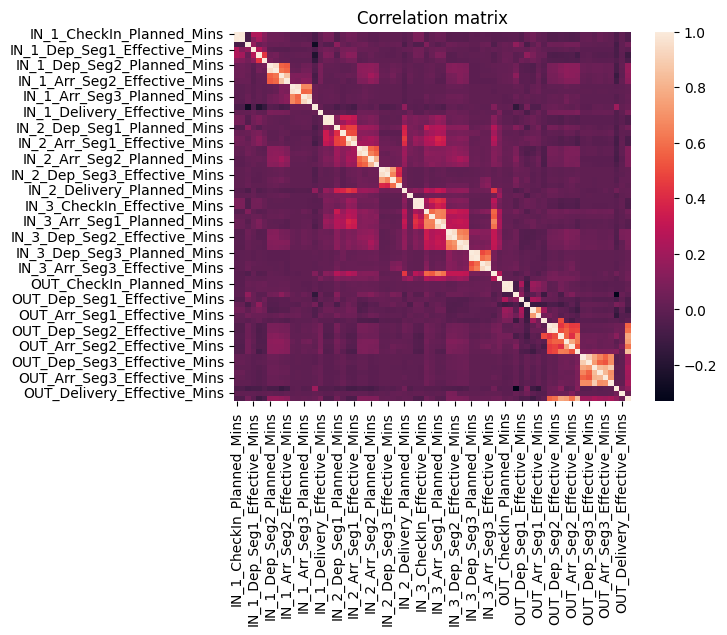

In [ ]:
sns.heatmap(correlation_matrix)
plt.title('Correlation matrix')
plt.show()

**Summary of High Correlations (> 0.8)**

1. Planned vs. Effective Timings (Very High Correlation)

- Check-in

IN_1_CheckIn_Effective_Mins	IN_1_CheckIn_Planned_Mins	0.99
IN_2_CheckIn_Effective_Mins	IN_2_CheckIn_Planned_Mins	0.99
OUT_CheckIn_Effective_Mins	OUT_CheckIn_Planned_Mins	0.99
IN_3_CheckIn_Effective_Mins	IN_3_CheckIn_Planned_Mins	0.99

- Departure

IN_3_Dep_Seg3_Effective_Mins	IN_3_Dep_Seg3_Planned_Mins	0.98
OUT_Dep_Seg2_Effective_Mins	  OUT_Dep_Seg2_Planned_Mins	  0.97
IN_1_Dep_Seg3_Effective_Mins	IN_1_Dep_Seg3_Planned_Mins	0.97
IN_2_Dep_Seg3_Effective_Mins	IN_2_Dep_Seg3_Planned_Mins	0.96
IN_3_Dep_Seg2_Effective_Mins	IN_3_Dep_Seg2_Planned_Mins	0.96
OUT_Dep_Seg3_Effective_Mins	  OUT_Dep_Seg3_Planned_Mins	  0.89

- Arrivals

IN_3_Arr_Seg2_Effective_Mins	IN_3_Arr_Seg2_Planned_Mins	0.96
IN_3_Arr_Seg3_Effective_Mins	IN_3_Arr_Seg3_Planned_Mins	0.94
IN_1_Arr_Seg3_Effective_Mins	IN_1_Arr_Seg3_Planned_Mins	0.93
IN_3_Arr_Seg1_Effective_Mins	IN_3_Arr_Seg1_Planned_Mins	0.91


2. Operational & Structural Links

- Hub Identifiers

There is a strong correlation between the Departure and Arrival Hub IDs for the third segment of the outgoing leg (OUT_Arr_Seg3_Hub_ID and OUT_Dep_Seg3_Hub_ID, r = 0.89), which is expected as they represent the same leg of the journey.

- Route Complexity

The number of hops (OUT_Hops) is highly correlated with the Hub ID of the second arrival segment (OUT_Arr_Seg2_Hub_ID, r = 0.84), suggesting that certain hubs are specifically associated with multi-leg journeys.

- Schedule Dependencies

There is a notable correlation between the Hub ID of the third departure segment and the planned arrival time of that same segment (r = 0.84)

### Feature Multicollinearity (VIF)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric columns
numeric_data = df_1.select_dtypes(include=[np.number])

vif_data = pd.DataFrame()
vif_data["feature"] = numeric_data.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i)
                   for i in range(len(numeric_data.columns))]
vif_data.to_csv("vif_data.csv")
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
16,IN_2_CheckIn_Planned_Mins,1000.074056
17,IN_2_CheckIn_Effective_Mins,880.751701
32,IN_3_CheckIn_Planned_Mins,813.460126
33,IN_3_CheckIn_Effective_Mins,726.506822
0,IN_1_CheckIn_Planned_Mins,435.150289
...,...,...
29,IN_2_Arr_Seg3_Effective_Mins,1.619964
47,IN_3_Delivery_Effective_Mins,1.217743
15,IN_1_Delivery_Effective_Mins,1.203646
63,OUT_Delivery_Effective_Mins,1.110411


The Variance Inflation Factor (VIF) results indicate extreme multicollinearity across dataset. In statistical modelling, a VIF above 5 or 10 generally suggests that a variable is redundant.

Distribution of Multicollinearity

- VIF > 10 (33 features)

Nearly half of your features are "critically" collinear. These features are likely to mask each other's importance in a regression model.

- VIF 5–10 (20 features)

These show moderate multicollinearity and should be monitored or combined.

### Normality Testing (Shapiro-Wilk)

Column                    | Skewness   | Interpretation
-------------------------------------------------------
IN_1_CheckIn_Planned_Mins |       5.72 | Highly Positive Skew (Long Right Tail)
IN_1_CheckIn_Effective_Mins |       5.91 | Highly Positive Skew (Long Right Tail)
IN_1_Dep_Seg1_Planned_Mins |       5.05 | Highly Positive Skew (Long Right Tail)
IN_1_Dep_Seg1_Effective_Mins |       3.04 | Highly Positive Skew (Long Right Tail)
IN_1_Arr_Seg1_Planned_Mins |       1.31 | Highly Positive Skew (Long Right Tail)
IN_1_Arr_Seg1_Effective_Mins |      31.16 | Highly Positive Skew (Long Right Tail)
IN_1_Dep_Seg2_Planned_Mins |       4.61 | Highly Positive Skew (Long Right Tail)
IN_1_Dep_Seg2_Effective_Mins |       4.81 | Highly Positive Skew (Long Right Tail)
IN_1_Arr_Seg2_Planned_Mins |       2.67 | Highly Positive Skew (Long Right Tail)
IN_1_Arr_Seg2_Effective_Mins |       3.34 | Highly Positive Skew (Long Right Tail)
IN_1_Dep_Seg3_Planned_Mins |      26.92 | Highly Positive Skew (Long R

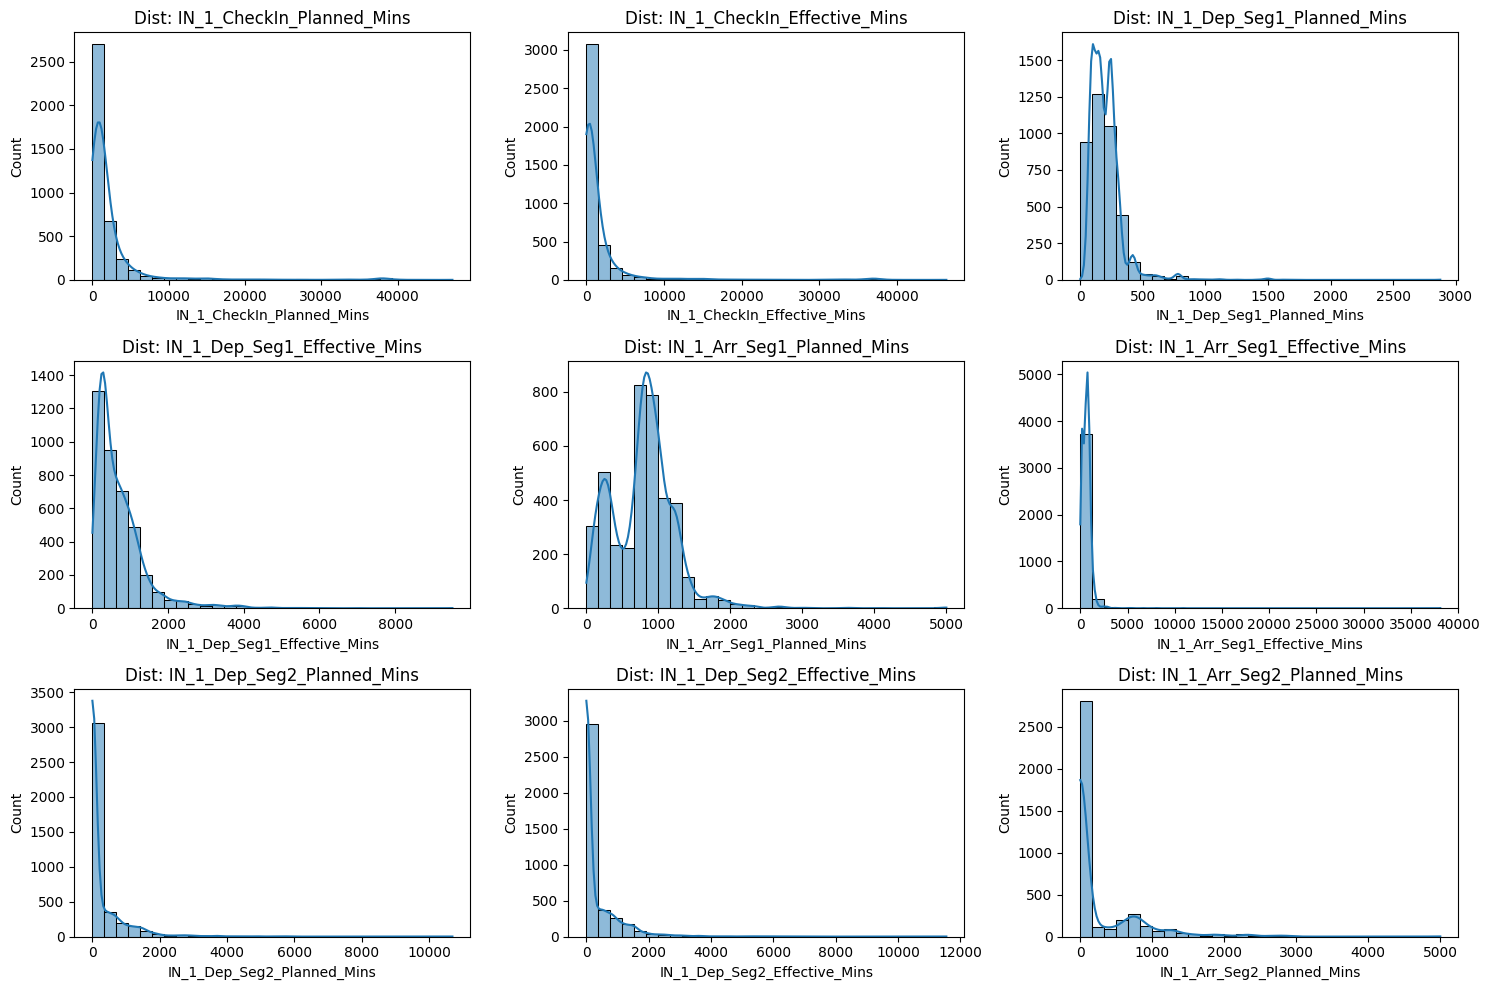

In [ ]:
from scipy.stats import skew

# Get only the numeric columns from your cleaned df_1
numeric_cols = df_1.select_dtypes(include=[np.number]).columns

print(f"{'Column':<25} | {'Skewness':<10} | {'Interpretation'}")
print("-" * 55)

for col in numeric_cols:
    # Calculate Skewness
    s = skew(df_1[col])

    # Interpret the result
    if s > 1:
        desc = "Highly Positive Skew (Long Right Tail)"
    elif s < -1:
        desc = "Highly Negative Skew (Long Left Tail)"
    elif -0.5 < s < 0.5:
        desc = "Fairly Symmetrical"
    else:
        desc = "Moderate Skew"

    print(f"{col:<25} | {s:>10.2f} | {desc}")

# Visualise the distributions to see the curves
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:9], 1): # Showing first 9 for clarity
    plt.subplot(3, 3, i)
    sns.histplot(df_1[col], kde=True, bins=30)
    plt.title(f"Dist: {col}")
plt.tight_layout()
plt.show()

# data_vis.py

## Data visualisation

### Data Preparation and De-normalisation

In [ ]:
import pandas as pd
import numpy as np

def prepare_long_format_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms wide data into long format with corrected Hub_ID handling.
    """
    milestones = []
    leg_prefixes = ['IN_1', 'IN_2', 'IN_3', 'OUT']

    for prefix in leg_prefixes:
        leg_id_col = f'{prefix}_Leg_ID'
        if leg_id_col not in df.columns:
            continue

        # Logic for identifying anchor hubs
        # Use .get() or check columns to avoid KeyErrors
        first_hub = df[f'{prefix}_Dep_Seg1_Hub_ID'] if f'{prefix}_Dep_Seg1_Hub_ID' in df.columns else pd.Series(['none']*len(df))

        # Correctly find the final destination hub for the DLV milestone
        last_hub = df[f'{prefix}_Arr_Seg3_Hub_ID'].replace(['0', 0, '?'], np.nan)
        for i in [2, 1]:
            col = f'{prefix}_Arr_Seg{i}_Hub_ID'
            if col in df.columns:
                last_hub = last_hub.fillna(df[col].replace(['0', 0, '?'], np.nan))

        last_hub = last_hub.fillna('none')

        # --- 1. Milestone: RCS ---
        rcs = df[[leg_id_col, f'{prefix}_CheckIn_Planned_Mins', f'{prefix}_CheckIn_Effective_Mins']].copy()
        rcs.columns = ['Leg_ID', 'Planned_Mins', 'Effective_Mins']
        rcs['Hub_ID'] = first_hub
        rcs['Milestone'] = 'RCS'
        rcs['Stage_Group'] = 'CheckIn'
        rcs['Leg_Type'] = prefix
        milestones.append(rcs)

        # --- 2. Milestones: DEP & RCF ---
        for i in range(1, 4):
            for m_type in ['Dep', 'Arr']:
                loc_col = f'{prefix}_{m_type}_Seg{i}_Hub_ID'
                p_col = f'{prefix}_{m_type}_Seg{i}_Planned_Mins'
                e_col = f'{prefix}_{m_type}_Seg{i}_Effective_Mins'

                if loc_col in df.columns and p_col in df.columns:
                    m_data = df[[leg_id_col, p_col, e_col, loc_col]].copy()
                    m_data.columns = ['Leg_ID', 'Planned_Mins', 'Effective_Mins', 'Hub_ID']
                    m_data['Milestone'] = 'DEP' if m_type == 'Dep' else 'RCF'
                    m_data['Stage_Group'] = f'Transport_Seg{i}'
                    m_data['Leg_Type'] = prefix
                    milestones.append(m_data)

        # --- 3. Milestone: DLV ---
        dlv = df[[leg_id_col, f'{prefix}_Delivery_Planned_Mins', f'{prefix}_Delivery_Effective_Mins']].copy()
        dlv.columns = ['Leg_ID', 'Planned_Mins', 'Effective_Mins']
        dlv['Hub_ID'] = last_hub
        dlv['Milestone'] = 'DLV'
        dlv['Stage_Group'] = 'Delivery'
        dlv['Leg_Type'] = prefix
        milestones.append(dlv)

    long_df = pd.concat(milestones, ignore_index=True)

    # --- CLEANING ---
    # 1. Handle Hub_ID: Keep as strings!
    long_df['Hub_ID'] = long_df['Hub_ID'].astype(str).replace(['0', '0.0', 'nan', '?'], 'none')

    # 2. Convert time columns to numeric
    for col in ['Planned_Mins', 'Effective_Mins']:
        long_df[col] = pd.to_numeric(long_df[col], errors='coerce').fillna(0)

    # 3. Calculate Delay
    # IMPORTANT: Only calculate delay where both times exist (non-zero)
    long_df['Delay_Mins'] = 0
    mask = (long_df['Effective_Mins'] != 0) & (long_df['Planned_Mins'] != 0)
    long_df.loc[mask, 'Delay_Mins'] = long_df['Effective_Mins'] - long_df['Planned_Mins']

    # 4. Drop rows that are effectively empty
    long_df = long_df[~((long_df['Planned_Mins'] == 0) & (long_df['Effective_Mins'] == 0))]

    return long_df.reset_index(drop=True)

In [ ]:
long_flow_df = prepare_long_format_data(df)
print(long_flow_df.head())

   Leg_ID  Planned_Mins  Effective_Mins Hub_ID Milestone Stage_Group Leg_Type  \
0  5182.0         199.0           218.0  609.0       RCS     CheckIn     IN_1   
1  6523.0         844.0           584.0  700.0       RCS     CheckIn     IN_1   
2  5878.0        4380.0          4119.0  456.0       RCS     CheckIn     IN_1   
3  1275.0         759.0           169.0  173.0       RCS     CheckIn     IN_1   
4  8117.0        1597.0          1485.0  411.0       RCS     CheckIn     IN_1   

   Delay_Mins  
0          19  
1        -260  
2        -261  
3        -590  
4        -112  


### Statistical analysis for new data

In [ ]:
long_flow_df_stat = long_flow_df.copy()

cols_to_drop = ['Leg_ID', 'Hub_ID', 'Milestone', 'Stage_Group', 'Leg_Type']
long_flow_df_stat = long_flow_df_stat.drop(columns=[c for c in cols_to_drop if c in long_flow_df_stat.columns])

In [ ]:
long_flow_df_stat.describe()

,Planned_Mins,Effective_Mins,Delay_Mins
count,56082.000000,56082.000000,56082.000000
mean,1638.518705,1412.879623,-225.639082
std,2714.503967,5472.371567,5020.729285
min,1.000000,1.000000,-11868.000000
25%,267.000000,259.000000,-522.000000
50%,815.000000,650.000000,-112.000000
75%,1875.000000,1159.000000,127.000000
max,49136.000000,560130.000000,557375.000000


Column                    | Skewness   | Interpretation
-------------------------------------------------------
Planned_Mins              |       7.15 | Highly Positive Skew (Long Right Tail)
Effective_Mins            |      54.71 | Highly Positive Skew (Long Right Tail)
Delay_Mins                |      68.88 | Highly Positive Skew (Long Right Tail)


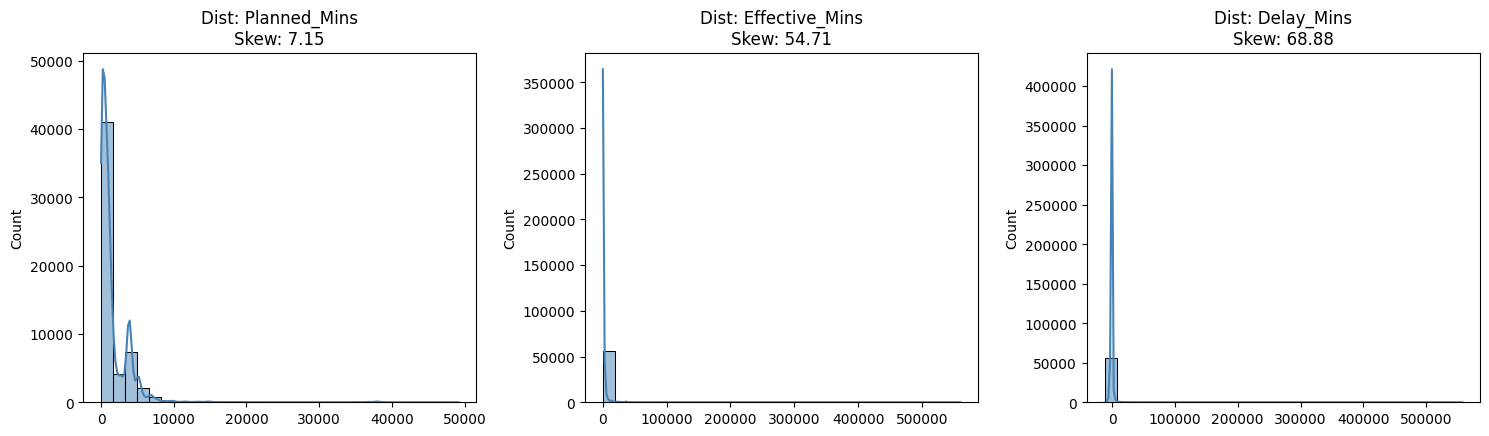

In [ ]:
numeric_cols = long_flow_df_stat.select_dtypes(include=[np.number]).columns

print(f"{'Column':<25} | {'Skewness':<10} | {'Interpretation'}")
print("-" * 55)

for col in numeric_cols:
    # Calculate Skewness (ensure we handle any remaining NaNs)
    s = skew(long_flow_df_stat[col].dropna())

    # Interpret the result
    if s > 1:
        desc = "Highly Positive Skew (Long Right Tail)"
    elif s < -1:
        desc = "Highly Negative Skew (Long Left Tail)"
    elif -0.5 < s < 0.5:
        desc = "Fairly Symmetrical"
    else:
        desc = "Moderate Skew"

    print(f"{col:<25} | {s:>10.2f} | {desc}")

# 2. Visualise the distributions
plt.figure(figsize=(15, 12))

# Use the correct dataframe name and plot up to 9 numeric columns
for i, col in enumerate(numeric_cols[:9], 1):
    plt.subplot(3, 3, i)

    # Histogram with Kernel Density Estimate (KDE)
    sns.histplot(long_flow_df_stat[col], kde=True, bins=30, color='steelblue')

    current_skew = skew(long_flow_df_stat[col].dropna())
    plt.title(f"Dist: {col}\nSkew: {current_skew:.2f}")
    plt.xlabel("")

plt.tight_layout()
plt.show()

### Key Performance Indicator (KPI) Calculation

In [ ]:
import pandas as pd
import numpy as np

def calculate_kpis_and_aggregate(long_flow_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates milestone-level performance into Hub-level KPIs.
    Identifies bottlenecks based on average delay and volume.
    """
    # 1. Filter out 'none' Hubs
    # We include all stages that have a Hub_ID to get a full picture of Hub performance
    df_work = long_flow_df[long_flow_df['Hub_ID'] != 'none'].copy()

    # 2. Ensure numeric types for calculation
    df_work['Delay_Mins'] = pd.to_numeric(df_work['Delay_Mins'], errors='coerce')

    # 3. Aggregate metrics by Hub_ID
    hub_metrics_df = df_work.groupby('Hub_ID').agg(
        Total_Outgoing_Flow=('Leg_ID', 'count'),  # Total activity at this hub
        Avg_Segment_Delay=('Delay_Mins', 'mean'),
        Std_Delay=('Delay_Mins', 'std'),
        Median_Delay=('Delay_Mins', 'median'),
        Max_Delay=('Delay_Mins', 'max'),
        Min_Delay=('Delay_Mins', 'min')
    ).reset_index()

    # 4. Handle Standard Deviation (Volatility)
    # If a Hub has only 1 record, std is NaN. We use the network median.
    median_std = hub_metrics_df['Std_Delay'].median()
    hub_metrics_df['Std_Delay'] = hub_metrics_df['Std_Delay'].fillna(median_std if pd.notna(median_std) else 0.0)

    # 5. Rank Hubs (1 = Highest average delay / Biggest Bottleneck)
    hub_metrics_df['Delay_Rank'] = hub_metrics_df['Avg_Segment_Delay'].rank(
        method='dense',
        ascending=False
    ).astype(int)

    # 6. Final cleanup and sorting
    hub_metrics_df = hub_metrics_df.sort_values('Total_Outgoing_Flow', ascending=False).reset_index(drop=True)

    return hub_metrics_df

# Execution
hub_analysis_df = calculate_kpis_and_aggregate(long_flow_df)

# Output for verification
print("--- Top 5 High-Volume Hubs ---")
print(hub_analysis_df.head(5)[['Hub_ID', 'Total_Outgoing_Flow', 'Avg_Segment_Delay']])

print("\n--- Top 5 Critical Bottlenecks (Worst Average Delays) ---")
# nsmallest(5, 'Delay_Rank') gives the hubs with rank 1, 2, 3...
print(hub_analysis_df.nsmallest(5, 'Delay_Rank')[['Hub_ID', 'Avg_Segment_Delay', 'Delay_Rank']])

--- Top 5 High-Volume Hubs ---
  Hub_ID  Total_Outgoing_Flow  Avg_Segment_Delay
0  700.0                 3577        -710.369583
1    128                 2872        -266.556058
2    700                 2799        -543.430868
3    815                 2659        -251.081234
4  815.0                 2617        -321.279327

--- Top 5 Critical Bottlenecks (Worst Average Delays) ---
    Hub_ID  Avg_Segment_Delay  Delay_Rank
192    620       31044.923077           1
168  356.0       13468.611111           2
285    102        9770.250000           3
183    296        9362.285714           4
320  316.0        7562.250000           5


### Interactive Visualisation using Plotly

#### Visualisation 1: Hub Activity vs. Delay (Bubble Plot)

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression # Ensure this is installed

def visualise_hub_activity_vs_delay(hub_analysis_df: pd.DataFrame, min_flow_percentile=0.10):
    # 1. Filter for hubs with significant flow
    min_flow = hub_analysis_df['Total_Outgoing_Flow'].quantile(min_flow_percentile)
    filtered_df = hub_analysis_df[hub_analysis_df['Total_Outgoing_Flow'] >= min_flow].copy()

    # 2. Identify problematic hubs
    median_flow = filtered_df['Total_Outgoing_Flow'].median()
    median_delay = filtered_df['Avg_Segment_Delay'].median()

    def categorise_hub(row):
        if row['Total_Outgoing_Flow'] > median_flow and row['Avg_Segment_Delay'] > median_delay:
            return 'Critical Bottleneck (High Volume + High Delay)'
        elif row['Total_Outgoing_Flow'] > median_flow and row['Avg_Segment_Delay'] <= median_delay:
            return 'Efficient Major Hub (High Volume + Low Delay)'
        elif row['Total_Outgoing_Flow'] <= median_flow and row['Avg_Segment_Delay'] > median_delay:
            return 'Inefficient Small Hub (Low Volume + High Delay)'
        else:
            return 'Efficient Small Hub (Low Volume + Low Delay)'

    filtered_df['Hub_Category'] = filtered_df.apply(categorise_hub, axis=1)

    # 3. Correlation
    correlation = filtered_df['Total_Outgoing_Flow'].corr(filtered_df['Avg_Segment_Delay'])

    # 4. Determine log scale
    flow_range = filtered_df['Total_Outgoing_Flow'].max() / filtered_df['Total_Outgoing_Flow'].min()
    use_log = flow_range > 100

    # 5. Create hover information (Safe for both string and numeric IDs)
    filtered_df['Hover_Text'] = filtered_df.apply(
        lambda row: f"<b>Hub {row['Hub_ID']}</b><br>" +
                    f"Flow: {int(row['Total_Outgoing_Flow']):,} segments<br>" +
                    f"Avg Delay: {row['Avg_Segment_Delay']:.1f} min<br>" +
                    f"Std Delay: {row['Std_Delay']:.1f} min",
        axis=1
    )

    # 6. Create the scatter plot
    fig = px.scatter(
        filtered_df,
        x='Total_Outgoing_Flow',
        y='Avg_Segment_Delay',
        size='Std_Delay',
        color='Hub_Category',
        custom_data=['Hover_Text'],
        log_x=use_log,
        title=f'Hub Performance Analysis: Volume vs Delay<br><sub>Correlation: {correlation:.3f} | n={len(filtered_df)} hubs</sub>',
        labels={
            'Total_Outgoing_Flow': 'Total Activity Flow' + (' (Log Scale)' if use_log else ''),
            'Avg_Segment_Delay': 'Average Delay (Minutes)',
            'Std_Delay': 'Variability (Bubble Size)'
        },
        template='plotly_white',
        color_discrete_map={
            'Critical Bottleneck (High Volume + High Delay)': '#d62728',
            'Efficient Major Hub (High Volume + Low Delay)': '#2ca02c',
            'Inefficient Small Hub (Low Volume + High Delay)': '#ff7f0e',
            'Efficient Small Hub (Low Volume + Low Delay)': '#1f77b4'
        }
    )

    # 7. Update hover template
    fig.update_traces(hovertemplate='%{customdata[0]}<extra></extra>')

    # 8. Add quadrant lines
    fig.add_hline(y=median_delay, line_dash="dash", line_color="gray", annotation_text="Median Delay")
    fig.add_vline(x=median_flow, line_dash="dash", line_color="gray", annotation_text="Median Flow")

    # 9. Add trend line (Log-aware)
    if abs(correlation) > 0.1: # Lowered threshold to see general trends
        X = filtered_df['Total_Outgoing_Flow'].values.reshape(-1, 1)
        if use_log: X = np.log10(X) # Regress on log space for log plots

        y = filtered_df['Avg_Segment_Delay'].values
        model = LinearRegression().fit(X, y)

        # Create a smooth line for the trend
        x_range = np.linspace(filtered_df['Total_Outgoing_Flow'].min(), filtered_df['Total_Outgoing_Flow'].max(), 100).reshape(-1, 1)
        y_pred = model.predict(np.log10(x_range) if use_log else x_range)

        fig.add_trace(go.Scatter(x=x_range.flatten(), y=y_pred, mode='lines',
                                 name='Trend Line', line=dict(color='black', dash='dot')))

    fig.show()
    return filtered_df

# Usage
filtered_results = visualise_hub_activity_vs_delay(hub_analysis_df)

#### Visualisation 2: Top Flow Paths (Chord Diagram or Sankey)

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def visualise_top_flow_paths(long_flow_df: pd.DataFrame, top_n=15, mode='sankey'):
    """
    Visualises hub-to-hub flow paths using a Sankey diagram.
    Resilient to both string (LHR) and numeric (101) Hub IDs.
    """

    # 1. Path Reconstruction
    # Sort by Leg and Time to ensure shift(-1) captures the logical next step
    df_paths = long_flow_df.sort_values(['Leg_ID', 'Planned_Mins']).copy()

    # Identify the 'Target' by looking at the next row for the same Leg_ID
    df_paths['Target_Hub_ID'] = df_paths.groupby('Leg_ID')['Hub_ID'].shift(-1)
    df_paths.rename(columns={'Hub_ID': 'Source_Hub_ID'}, inplace=True)

    # Filter: Remove 'none' and ensure we have a valid source-to-target pair
    transport_df = df_paths[
        (df_paths['Source_Hub_ID'] != 'none') &
        (df_paths['Target_Hub_ID'] != 'none') &
        (df_paths['Target_Hub_ID'].notna())
    ].copy()

    # Avoid self-loops (Source == Target)
    transport_df = transport_df[transport_df['Source_Hub_ID'] != transport_df['Target_Hub_ID']]

    # 2. Aggregate metrics for each route
    flow_paths = transport_df.groupby(['Source_Hub_ID', 'Target_Hub_ID']).agg(
        Flow_Count=('Leg_ID', 'count'),
        Avg_Delay=('Delay_Mins', 'mean')
    ).reset_index()

    # 3. Identify top routes
    top_paths = flow_paths.nlargest(top_n, 'Flow_Count').copy()

    # Create safe Route labels (resilient to string IDs)
    top_paths['Route'] = top_paths['Source_Hub_ID'].astype(str) + ' → ' + top_paths['Target_Hub_ID'].astype(str)

    # 4. Performance Categorisation
    median_delay = top_paths['Avg_Delay'].median()
    top_paths['Performance'] = top_paths['Avg_Delay'].apply(
        lambda x: 'High Delay' if x > median_delay else 'Low Delay'
    )

    # =========================================================================
    # VISUALISATION: Sankey
    # =========================================================================
    if mode in ['sankey', 'both']:
        # Create a unique list of all hubs involved in the top paths
        unique_hubs = pd.unique(top_paths[['Source_Hub_ID', 'Target_Hub_ID']].values.ravel('K'))
        hub_map = {hub: i for i, hub in enumerate(unique_hubs)}

        # Clean labels for the nodes
        hub_labels = [f"Hub {h}" for h in unique_hubs]

        fig_sankey = go.Figure(data=[go.Sankey(
            arrangement='snap',
            node=dict(
                pad=20,
                thickness=25,
                label=hub_labels,
                color='lightblue',
                line=dict(color="black", width=0.5)
            ),
            link=dict(
                source=top_paths['Source_Hub_ID'].map(hub_map),
                target=top_paths['Target_Hub_ID'].map(hub_map),
                value=top_paths['Flow_Count'],
                # Red for High Delay routes, Green for Low Delay routes
                color=['rgba(214, 39, 40, 0.4)' if p == 'High Delay' else 'rgba(44, 160, 44, 0.4)' for p in top_paths['Performance']],
                customdata=top_paths['Avg_Delay'].round(1),
                hovertemplate='Route: %{label}<br>Volume: %{value}<br>Avg Delay: %{customdata} min<extra></extra>'
            )
        )])

        fig_sankey.update_layout(
            title_text="<b>Top Freight Flow Paths</b><br><sup>Sankey width represents volume; colour represents delay</sup>",
            font_size=12,
            height=600
        )
        fig_sankey.show()

    return top_paths

# Usage
top_routes = visualise_top_flow_paths(long_flow_df, top_n=15)

In [ ]:
visualise_top_flow_paths(long_flow_df, top_n=50)

,Source_Hub_ID,Target_Hub_ID,Flow_Count,Avg_Delay,Route,Performance
5475,815.0,485.0,284,-45.514085,815.0 → 485.0,High Delay
5371,815,485,234,-40.829060,815 → 485,High Delay
3218,485.0,700.0,214,23.308411,485.0 → 700.0,High Delay
4720,700.0,671.0,204,-164.078431,700.0 → 671.0,Low Delay
4616,700,700.0,182,294.373626,700 → 700.0,High Delay
105,128,128.0,172,74.337209,128 → 128.0,High Delay
271,128.0,128,169,-33.834320,128.0 → 128,High Delay
4611,700,671,166,-64.620482,700 → 671,Low Delay
4418,671.0,700.0,163,-188.208589,671.0 → 700.0,Low Delay
5498,815.0,609.0,162,-17.388889,815.0 → 609.0,High Delay


#### Visualisation 3: Network Graph with Community Detection

Shows the actual logistics network structure and identifies hub clusters.

In [ ]:
import networkx as nx
import plotly.graph_objects as go
from community import community_louvain # Make sure to pip install python-louvain
import pandas as pd
import numpy as np

def visualise_network_with_communities(long_flow_df: pd.DataFrame, min_flow=5):
    """
    Interactive network graph showing hub communities.
    Resilient to string-based Hub IDs and varied network densities.
    """
    # 1. Path Reconstruction
    df_path = long_flow_df.sort_values(['Leg_ID', 'Planned_Mins']).copy()
    df_path['Source_Hub_ID'] = df_path['Hub_ID']
    df_path['Target_Hub_ID'] = df_path.groupby('Leg_ID')['Hub_ID'].shift(-1)

    # 2. Filter for valid segments
    transport_df = df_path[
        (df_path['Source_Hub_ID'] != 'none') &
        (df_path['Target_Hub_ID'] != 'none') &
        (df_path['Target_Hub_ID'].notna())
    ].copy()

    # Remove self-loops
    transport_df = transport_df[transport_df['Source_Hub_ID'] != transport_df['Target_Hub_ID']]

    # 3. Build the Directed Graph
    G = nx.DiGraph()
    edge_data = transport_df.groupby(['Source_Hub_ID', 'Target_Hub_ID']).size().reset_index(name='weight')

    for _, row in edge_data.iterrows():
        if row['weight'] >= min_flow:
            # We keep the IDs as they are (strings or ints)
            G.add_edge(row['Source_Hub_ID'], row['Target_Hub_ID'], weight=row['weight'])

    if len(G.nodes) == 0:
        print("No edges found with the current min_flow threshold.")
        return None, None

    # 4. Community Detection (Louvain requires undirected graph)
    G_undirected = G.to_undirected()
    communities = community_louvain.best_partition(G_undirected)

    # 5. Graph Layout
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

    # Prepare node traces
    node_x, node_y, node_text, node_color, node_size = [], [], [], [], []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

        # Metrics for hover and size
        deg = G.degree(node)
        node_size.append(deg * 2 + 10)
        node_color.append(communities[node])

        node_text.append(
            f"<b>Hub: {node}</b><br>" +
            f"Community Group: {communities[node]}<br>" +
            f"Total Connections: {deg}<br>" +
            f"Inbound: {G.in_degree(node)}<br>" +
            f"Outbound: {G.out_degree(node)}"
        )

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        marker=dict(
            size=node_size,
            color=node_color,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Community Group", thickness=15),
            line=dict(width=1, color='white')
        ),
        text=node_text,
        hovertemplate='%{text}<extra></extra>'
    )

    # Prepare edge traces
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        mode='lines',
        line=dict(width=0.5, color='rgba(150,150,150,0.3)'),
        hoverinfo='none'
    )

    # 6. Create Figure
    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        title=f"<b>Supply Chain Network Analysis</b><br><sup>{len(set(communities.values()))} Clusters Detected | Min Flow: {min_flow}</sup>",
        template='plotly_white',
        showlegend=False,
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        height=700,
        margin=dict(b=20, l=5, r=5, t=60)
    )

    fig.show()
    return G, communities

# Usage
G, communities = visualise_network_with_communities(long_flow_df, min_flow=5)

#### Time-Series Analysis (Delay Over Journey Progression)


Shows how delays accumulate across segments.

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

def visualise_delay_accumulation(df: pd.DataFrame):
    """
    Shows how delays build up across segments.
    Updated to handle Pandas 3.0+ syntax and robust data merging.
    """
    delay_data = []

    for prefix in ['IN_1', 'IN_2', 'IN_3', 'OUT']:
        for seg_num in [1, 2, 3]:
            planned_col = f'{prefix}_Arr_Seg{seg_num}_Planned_Mins'
            effective_col = f'{prefix}_Arr_Seg{seg_num}_Effective_Mins'

            if planned_col in df.columns and effective_col in df.columns:
                # Convert to numeric and ignore 0 (often represents 'no record')
                planned = pd.to_numeric(df[planned_col], errors='coerce').replace(0, np.nan)
                effective = pd.to_numeric(df[effective_col], errors='coerce').replace(0, np.nan)

                # Calculate individual segment delay
                # Note: If you want 'Accumulated' delay, you would sum these over the segments
                delays = (effective - planned).dropna()

                if not delays.empty:
                    # Creating a temporary DF is faster than a nested loop for large data
                    temp_df = pd.DataFrame({
                        'Leg_Type': prefix,
                        'Segment': seg_num,
                        'Delay': delays.values
                    })
                    delay_data.append(temp_df)

    if not delay_data:
        print("⚠️ No valid delay data found.")
        return None, None

    # Combine all collected dataframes
    all_delay_df = pd.concat(delay_data, ignore_index=True)

    # Calculate summary statistics
    summary = all_delay_df.groupby(['Leg_Type', 'Segment'])['Delay'].agg([
        'mean', 'median', 'std', 'count'
    ]).reset_index()

    # Pandas Fix: Use fillna on the series directly without inplace=True to avoid FutureWarnings
    summary['std'] = summary['std'].fillna(0)

    # 1. Line Plot (The Trend)
    fig1 = px.line(
        summary, x='Segment', y='mean', color='Leg_Type', error_y='std',
        markers=True,
        title='Average Delay per Segment<br><sub>Shows which specific segments add the most time</sub>',
        labels={'mean': 'Avg Delay (mins)', 'Segment': 'Journey Stage'},
        template='plotly_white'
    )
    fig1.update_layout(xaxis=dict(tickmode='linear', dtick=1))
    fig1.show()

    # 2. Violin Plot (The Distribution)
    # This is better than a Box Plot for seeing if you have "two peaks" of delay
    fig2 = px.violin(
        all_delay_df, x='Segment', y='Delay', color='Leg_Type',
        box=True, points='outliers',
        title='Delay Distribution Density per Segment',
        template='plotly_white'
    )
    fig2.show()

    # Identify the bottleneck
    worst = summary.loc[summary['mean'].idxmax()]
    print(f"\nCritical Bottleneck Found:")
    print(f"Leg: {worst['Leg_Type']} | Segment: {int(worst['Segment'])}")
    print(f"Average Delay: {worst['mean']:.1f} mins across {int(worst['count'])} shipments")

    return summary, all_delay_df

# Execution
summary_stats, raw_delays = visualise_delay_accumulation(df)


Critical Bottleneck Found:
Leg: IN_1 | Segment: 3
Average Delay: -76.6 mins across 23 shipments


#### Visualisation 4: Heatmap - Hub-to-Hub Delay Matrix


Shows which hub pairs consistently have problems.

In [ ]:
import pandas as pd
import plotly.express as px
import numpy as np

def visualise_hub_delay_heatmap(long_flow_df: pd.DataFrame, top_n_hubs=20, min_lane_volume=2):
    """
    Heatmap showing average delays between hub pairs.
    Resilient to string Hub IDs and handles sparse route data.
    """
    # 1. Path Reconstruction
    stage_order = {'CheckIn': 10, 'Transport_Seg1': 20, 'Transport_Seg2': 30, 'Transport_Seg3': 40, 'Delivery': 50}
    milestone_order = {'RCS': 1, 'DEP': 2, 'RCF': 3, 'DLV': 4}

    df_work = long_flow_df.copy()

    # Create chronological sort key
    df_work['Sort_Key'] = (
        df_work['Stage_Group'].map(stage_order).fillna(99) +
        df_work['Milestone'].map(milestone_order).fillna(0)
    )
    df_work = df_work.sort_values(['Leg_ID', 'Sort_Key'])

    # Reconstruct Lane: Current Hub -> Next Hub
    df_work['Source_Hub_ID'] = df_work['Hub_ID']
    df_work['Target_Hub_ID'] = df_work.groupby('Leg_ID')['Hub_ID'].shift(-1)

    # 2. Filter for valid transport lanes
    df_work = df_work[
        (df_work['Source_Hub_ID'] != 'none') &
        (df_work['Target_Hub_ID'] != 'none') &
        (df_work['Target_Hub_ID'].notna())
    ].copy()

    # Remove self-loops
    df_work = df_work[df_work['Source_Hub_ID'] != df_work['Target_Hub_ID']]

    # 3. Identify Top Hubs by Volume
    top_hubs = df_work['Source_Hub_ID'].value_counts().head(top_n_hubs).index

    # Filter matrix to only include these top hubs for both axes
    filtered_df = df_work[
        df_work['Source_Hub_ID'].isin(top_hubs) &
        df_work['Target_Hub_ID'].isin(top_hubs)
    ].copy()

    if filtered_df.empty:
        print("No hub-to-hub data found. Try increasing top_n_hubs.")
        return None

    # 4. Aggregate and Filter by Lane Volume
    # We want to avoid showing lanes that only have 1 shipment (as they skew the heatmap)
    lane_stats = filtered_df.groupby(['Source_Hub_ID', 'Target_Hub_ID']).agg(
        Avg_Delay=('Delay_Mins', 'mean'),
        Shipment_Count=('Leg_ID', 'count')
    ).reset_index()

    lane_stats = lane_stats[lane_stats['Shipment_Count'] >= min_lane_volume]

    # 5. Create Pivot Table (Safe for string Hub IDs)
    delay_matrix = lane_stats.pivot(
        index='Source_Hub_ID',
        columns='Target_Hub_ID',
        values='Avg_Delay'
    )

    # 6. Visualise
    fig = px.imshow(
        delay_matrix,
        labels=dict(x="Destination Hub", y="Origin Hub", color="Avg Delay (min)"),
        title=f"<b>Hub-to-Hub Delay Heatmap (Top {top_n_hubs} Hubs)</b><br><sup>Red: Delays | Green: Early/On-Time | Min Volume: {min_lane_volume}</sup>",
        color_continuous_scale='RdYlGn_r',
        color_continuous_midpoint=0, # Ensures 0 delay is the neutral colour
        aspect='auto',
        template='plotly_white'
    )

    fig.update_xaxes(side="bottom")
    fig.update_layout(height=650, width=850)
    fig.show()

    # 7. Summary of worst lanes
    worst_lanes = lane_stats.nlargest(10, 'Avg_Delay')
    print("\n" + "="*60)
    print(f"TOP 10 CRITICAL LANES (MOST DELAYED)")
    print("="*60)
    print(worst_lanes[['Source_Hub_ID', 'Target_Hub_ID', 'Avg_Delay', 'Shipment_Count']].to_string(index=False))

    return delay_matrix

# Usage
delay_matrix = visualise_hub_delay_heatmap(long_flow_df, top_n_hubs=15)


TOP 10 CRITICAL LANES (MOST DELAYED)
Source_Hub_ID Target_Hub_ID   Avg_Delay  Shipment_Count
        609.0         149.0 2437.500000               2
        349.0         700.0 1693.315789              38
        281.0         700.0 1323.300000              70
          349           700 1258.363636              22
        815.0         700.0 1229.675214             117
          815           700 1183.337079              89
        700.0         149.0 1108.250000               4
        815.0         609.0 1106.547945              73
        815.0         671.0 1038.109375              64
          349           149 1023.666667               9


#### Visualisation 5: Parallel Coordinates Plot (Multi-dimensional Hub Analysis)


Shows relationships between multiple hub metrics simultaneously.

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def visualise_hub_profiles(hub_analysis_df: pd.DataFrame):
    """
    Parallel coordinates plot showing hub performance across multiple dimensions.
    Handles string-based Hub IDs by mapping them to numeric indices.
    """
    # 1. Select top hubs for visual clarity
    top_hubs = hub_analysis_df.nlargest(30, 'Total_Outgoing_Flow').copy()

    # 2. Handle Hub_ID mapping (must be numeric for Parcoords)
    # We create a mapping so the axis shows the Hub name/ID but the value is numeric
    unique_hubs = top_hubs['Hub_ID'].unique()
    hub_to_idx = {hub: i for i, hub in enumerate(unique_hubs)}
    top_hubs['Hub_Numeric_ID'] = top_hubs['Hub_ID'].map(hub_to_idx)

    # 3. Create parallel coordinates
    fig = go.Figure(data=
        go.Parcoords(
            line=dict(
                color=top_hubs['Avg_Segment_Delay'],
                colorscale='RdYlGn_r', # Red for high delay, Green for low
                showscale=True,
                colorbar=dict(title="Avg Delay (min)")
            ),
            dimensions=[
                # Use range and tickvals for the Hub ID axis to make it readable
                dict(
                    range=[0, len(unique_hubs) - 1],
                    label='Hub Name/ID',
                    values=top_hubs['Hub_Numeric_ID'],
                    tickvals=list(hub_to_idx.values()),
                    ticktext=list(hub_to_idx.keys())
                ),
                dict(
                    label='Flow Volume',
                    values=top_hubs['Total_Outgoing_Flow']
                ),
                dict(
                    label='Avg Delay (min)',
                    values=top_hubs['Avg_Segment_Delay']
                ),
                dict(
                    label='Variability (Std)',
                    values=top_hubs['Std_Delay']
                ),
                dict(
                    label='Max Delay (min)',
                    values=top_hubs['Max_Delay']
                )
            ]
        )
    )

    fig.update_layout(
        title="<b>Hub Performance Profiling (Top 30 Hubs)</b><br><sup>Drag axes to reorder or select ranges to filter hubs</sup>",
        height=650,
        template='plotly_white'
    )

    fig.show()

# Usage
visualise_hub_profiles(hub_analysis_df)

#### Visualisation 6: On-Time Performance (OTP) Dashboard


Industry-standard logistics KPI.

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def visualise_otp_performance(long_flow_df: pd.DataFrame, tolerance_minutes=15):
    """
    On-Time Performance (OTP) dashboard.
    Resilient to string-based IDs and missing timing data.
    """
    # 1. Data Preparation
    df_work = long_flow_df.copy()

    # Ensure numeric types
    for col in ['Effective_Mins', 'Planned_Mins', 'Delay_Mins']:
        df_work[col] = pd.to_numeric(df_work[col], errors='coerce')

    # Remove rows missing data and 'none' hubs
    df_work = df_work.dropna(subset=['Effective_Mins', 'Planned_Mins'])
    df_work = df_work[df_work['Hub_ID'] != 'none']

    # 2. OTP Calculation
    # OTP Formula: $OTP = \frac{\sum (Delay \le Tolerance)}{Total Segments} \times 100$
    df_work['On_Time'] = df_work['Delay_Mins'] <= tolerance_minutes

    total_segments = len(df_work)
    overall_otp = (df_work['On_Time'].sum() / total_segments * 100) if total_segments > 0 else 0

    # Aggregations
    otp_by_stage = df_work.groupby('Stage_Group').agg(
        Total_Segments=('Leg_ID', 'count'),
        On_Time_Count=('On_Time', 'sum')
    ).reset_index()
    otp_by_stage['OTP_Percentage'] = (otp_by_stage['On_Time_Count'] / otp_by_stage['Total_Segments'] * 100)

    otp_by_hub = df_work.groupby('Hub_ID').agg(
        Total_Segments=('Leg_ID', 'count'),
        On_Time_Count=('On_Time', 'sum')
    ).reset_index()
    otp_by_hub['OTP_Percentage'] = (otp_by_hub['On_Time_Count'] / otp_by_hub['Total_Segments'] * 100)

    significant_hubs = otp_by_hub[otp_by_hub['Total_Segments'] >= 10].copy()

    # 3. Create Dashboard
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            f'Overall Network OTP: {overall_otp:.1f}%',
            'Performance by Operational Stage',
            'Hub OTP Distribution (Volume >= 10)',
            'Top 10 Worst Performing Hubs'
        ),
        specs=[[{"type": "indicator"}, {"type": "bar"}],
               [{"type": "histogram"}, {"type": "bar"}]]
    )

    # Gauge
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=overall_otp,
            title={'text': f"Network OTP %<br><sub>(Tolerance: {tolerance_minutes} min)</sub>", 'font': {'size': 14}},
            gauge={
                'axis': {'range': [0, 100]},
                'bar': {'color': "navy"},
                'steps': [
                    {'range': [0, 70], 'color': "mistyrose"},
                    {'range': [70, 85], 'color': "lemonchiffon"},
                    {'range': [85, 100], 'color': "honeydew"}
                ],
                'threshold': {'line': {'color': "red", 'width': 4}, 'value': 90}
            }
        ),
        row=1, col=1
    )

    # Bar: OTP by Stage
    fig.add_trace(
        go.Bar(
            x=otp_by_stage['Stage_Group'],
            y=otp_by_stage['OTP_Percentage'],
            marker_color=['#d62728' if x < 85 else '#2ca02c' for x in otp_by_stage['OTP_Percentage']],
            text=[f"{x:.1f}%" for x in otp_by_stage['OTP_Percentage']],
            textposition='outside'
        ),
        row=1, col=2
    )

    # Histogram: Distribution
    fig.add_trace(
        go.Histogram(
            x=significant_hubs['OTP_Percentage'],
            nbinsx=15,
            marker_color='cadetblue'
        ),
        row=2, col=1
    )

    # Horizontal Bar: Worst Hubs (Safe string handling)
    worst_hubs = significant_hubs.nsmallest(10, 'OTP_Percentage').sort_values('OTP_Percentage', ascending=True)
    fig.add_trace(
        go.Bar(
            y=[f"Hub {h}" for h in worst_hubs['Hub_ID']],
            x=worst_hubs['OTP_Percentage'],
            orientation='h',
            marker_color='crimson',
            text=[f"{x:.1f}%" for x in worst_hubs['OTP_Percentage']],
            textposition='outside'
        ),
        row=2, col=2
    )

    # Layout
    fig.update_layout(height=850, template='plotly_white', showlegend=False)
    fig.update_yaxes(range=[0, 115], row=1, col=2) # Space for text labels
    fig.show()

    # 4. Summary Output
    print(f"\nOTP ANALYSIS COMPLETE")
    print(f"Network OTP: {overall_otp:.2f}% (Tolerance: {tolerance_minutes} mins)")
    print(f"Operational Segments Analysed: {total_segments:,}")

    return otp_by_stage, significant_hubs

# Usage
otp_stage, otp_hub = visualise_otp_performance(long_flow_df)


OTP ANALYSIS COMPLETE
Network OTP: 65.86% (Tolerance: 15 mins)
Operational Segments Analysed: 56,082


# Feature Importance

Dataset Split Complete: 44865 training samples.

Model Performance:
- Mean Absolute Error: 17.38 minutes
- R-Squared Score: 0.992


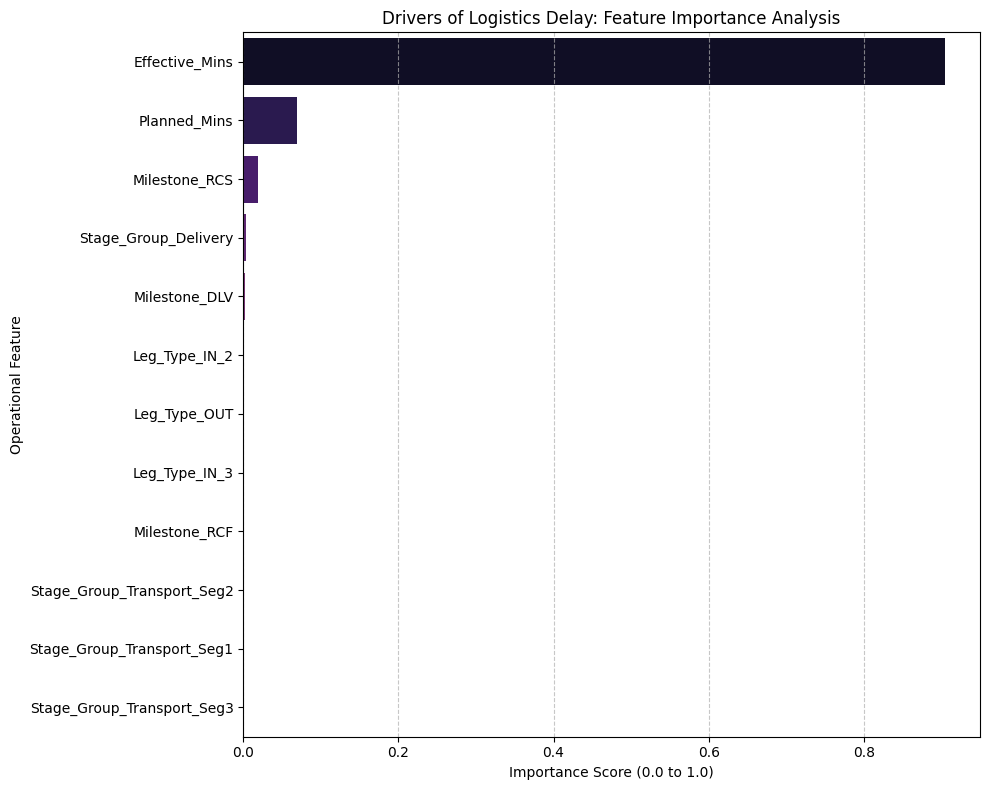


Critical Delay Drivers (Top 5):
             Feature  Importance
      Effective_Mins    0.904661
        Planned_Mins    0.069612
       Milestone_RCS    0.019204
Stage_Group_Delivery    0.003376
       Milestone_DLV    0.002599


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Prepare Data
long_flow_df_2 = long_flow_df.copy()

# Drop rows with missing targets and non-numeric columns we don't need
long_flow_df_2 = long_flow_df_2.dropna(subset=['Delay_Mins'])
y = long_flow_df_2['Delay_Mins']

# Features: We exclude IDs but keep the categorical types
X = long_flow_df_2.drop(columns=['Leg_ID', 'Hub_ID', 'Delay_Mins'])

# One-Hot Encoding
X = pd.get_dummies(X, columns=['Milestone', 'Stage_Group', 'Leg_Type'], drop_first=True)

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Dataset Split Complete: {X_train.shape[0]} training samples.")

# 3. Model Training
# n_jobs=-1 uses all CPU cores for speed
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# 4. Evaluation
predictions = rf.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"\nModel Performance:")
print(f"- Mean Absolute Error: {mae:.2f} minutes")
print(f"- R-Squared Score: {r2:.3f}")

# 5. Feature Importance Extraction
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 6. Visualise
plt.figure(figsize=(10, 8))
# Added 'hue' to avoid Seaborn warnings and used a professional colour palette
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances.head(15),
    hue='Feature',
    legend=False,
    palette='magma'
)

plt.title('Drivers of Logistics Delay: Feature Importance Analysis')
plt.xlabel('Importance Score (0.0 to 1.0)')
plt.ylabel('Operational Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nCritical Delay Drivers (Top 5):")
print(importances.head(5).to_string(index=False))

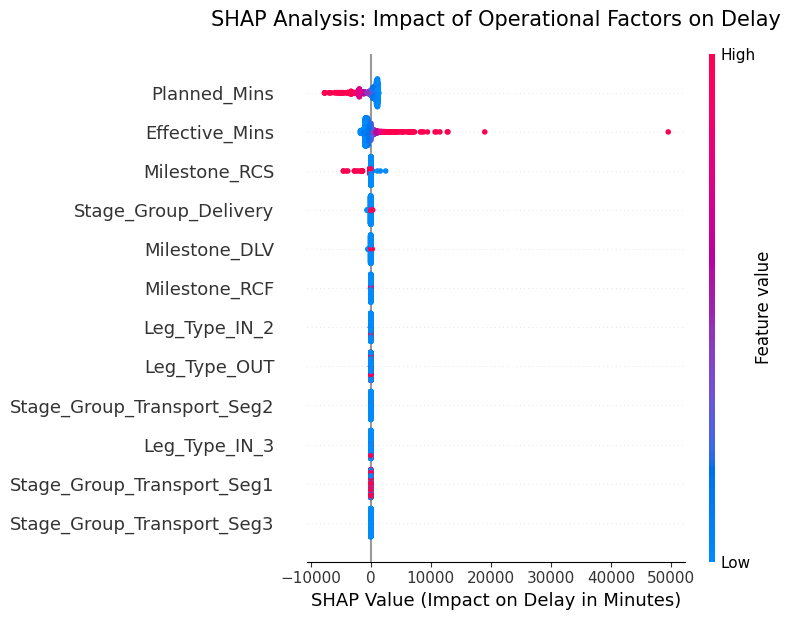

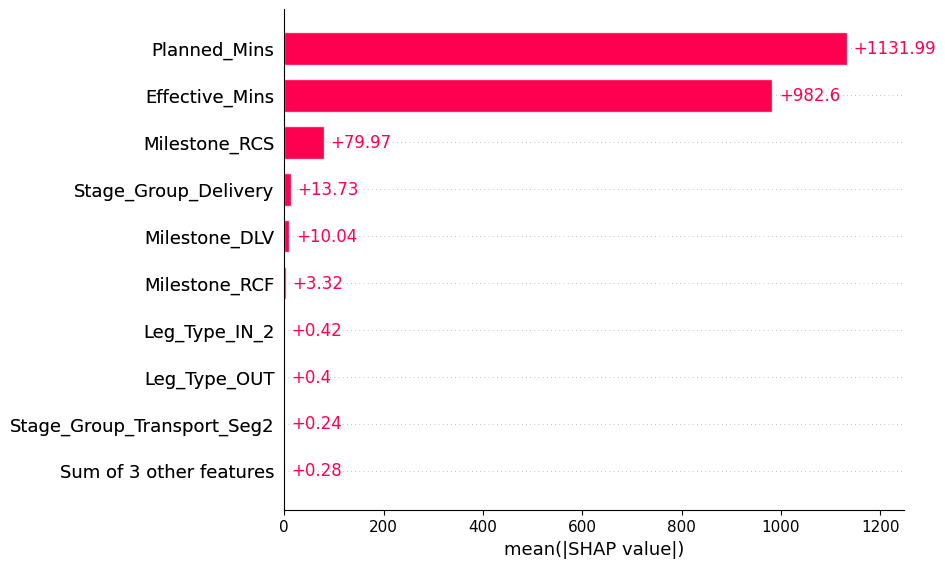

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. Create a SHAP explainer
# TreeExplainer is specifically optimised for Random Forests
explainer = shap.TreeExplainer(rf)

# 2. Sample the data
# We use a sample because calculating SHAP for very large datasets is slow
sample_size = min(1000, len(X_test))
X_sample = X_test.sample(sample_size, random_state=42)

# 3. Calculate SHAP values
# Using check_additivity=False can sometimes help with minor floating point mismatches
shap_results = explainer(X_sample)

# 4. Visualisation
plt.figure(figsize=(12, 8))

# The summary plot (beeswarm) is the most powerful SHAP visual
# It shows how high/low values of a feature impact the delay
shap.summary_plot(shap_results, X_sample, show=False)

plt.title("SHAP Analysis: Impact of Operational Factors on Delay", fontsize=15, pad=20)
plt.xlabel("SHAP Value (Impact on Delay in Minutes)")
plt.tight_layout()
plt.show()

# 5. Global Bar Plot
# This provides a clean alternative to the standard Feature Importance
plt.figure(figsize=(12, 6))
shap.plots.bar(shap_results)
plt.show()

In [ ]:
def calculate_kpis_and_aggregate(long_flow_df: pd.DataFrame, min_volume=1) -> pd.DataFrame:
    """
    Calculates Delay and aggregates flow and delay metrics by Hub.
    Synchronised to use 'Total_Outgoing_Flow' for visualisation compatibility.
    """
    df_work = long_flow_df.copy()

    # 1. Ensure numeric types for calculation
    for col in ['Effective_Mins', 'Planned_Mins']:
        if col in df_work.columns:
            df_work[col] = pd.to_numeric(df_work[col], errors='coerce')

    # 2. Calculate Delay if not already present
    if 'Delay_Mins' not in df_work.columns:
        df_work['Delay_Mins'] = df_work['Effective_Mins'] - df_work['Planned_Mins']

    # 3. Clean records: Exclude 'none' and non-numeric delays
    df_work = df_work.dropna(subset=['Delay_Mins', 'Hub_ID'])
    df_work = df_work[df_work['Hub_ID'] != 'none']

    # Filter out empty/placeholder records
    df_work = df_work[~((df_work['Planned_Mins'] == 0) & (df_work['Effective_Mins'] == 0))]

    # 4. Aggregate Metrics by Hub_ID
    # We use 'Total_Outgoing_Flow' to match the Scatter Plot and Quadrant code
    hub_metrics_df = df_work.groupby('Hub_ID').agg(
        Total_Outgoing_Flow=('Leg_ID', 'count'),
        Avg_Segment_Delay=('Delay_Mins', 'mean'),
        Std_Delay=('Delay_Mins', 'std'),
        Median_Delay=('Delay_Mins', 'median'),
        Max_Delay=('Delay_Mins', 'max')
    ).reset_index()

    # 5. Handle single-entry hubs (NaN Std Dev)
    median_std = hub_metrics_df['Std_Delay'].median()
    hub_metrics_df['Std_Delay'] = hub_metrics_df['Std_Delay'].fillna(median_std if pd.notna(median_std) else 0.0)

    # 6. Apply Volume Filter
    hub_metrics_df = hub_metrics_df[hub_metrics_df['Total_Outgoing_Flow'] >= min_volume]

    # 7. Rank Hubs (1 = Worst/Most Delayed)
    hub_metrics_df['Delay_Rank'] = hub_metrics_df['Avg_Segment_Delay'].rank(
        method='dense',
        ascending=False
    ).astype(int)

    # 8. Sort and Finalise
    hub_metrics_df = hub_metrics_df.sort_values('Total_Outgoing_Flow', ascending=False)

    return hub_metrics_df.reset_index(drop=True)

# Usage
hub_kpis = calculate_kpis_and_aggregate(long_flow_df, min_volume=5)
print(hub_kpis.head(10))

  Hub_ID  Total_Outgoing_Flow  Avg_Segment_Delay    Std_Delay  Median_Delay  \
0  700.0                 3577        -710.369583  1843.325295        -317.0   
1    128                 2872        -266.556058  1368.463708         -14.0   
2    700                 2799        -543.430868  1971.313112        -178.0   
3    815                 2659        -251.081234  1159.675804         -19.0   
4  815.0                 2617        -321.279327  1249.601946         -80.0   
5  128.0                 2591        -376.948668  1278.396120         -59.0   
6  349.0                 2135         251.557377  1721.428175          23.0   
7    349                 1788          79.171700  1612.200156          29.0   
8  485.0                 1694        -731.034238  1812.395120        -122.0   
9    485                 1228       -1084.188111  2723.121286        -177.5   

   Max_Delay  Delay_Rank  
0      65634         232  
1      36278         171  
2      54039         211  
3       5184         1

In [ ]:
hub_analysis_df = calculate_kpis_and_aggregate(long_flow_df)
print(hub_analysis_df.head(10))

  Hub_ID  Total_Outgoing_Flow  Avg_Segment_Delay    Std_Delay  Median_Delay  \
0  700.0                 3577        -710.369583  1843.325295        -317.0   
1    128                 2872        -266.556058  1368.463708         -14.0   
2    700                 2799        -543.430868  1971.313112        -178.0   
3    815                 2659        -251.081234  1159.675804         -19.0   
4  815.0                 2617        -321.279327  1249.601946         -80.0   
5  128.0                 2591        -376.948668  1278.396120         -59.0   
6  349.0                 2135         251.557377  1721.428175          23.0   
7    349                 1788          79.171700  1612.200156          29.0   
8  485.0                 1694        -731.034238  1812.395120        -122.0   
9    485                 1228       -1084.188111  2723.121286        -177.5   

   Max_Delay  Delay_Rank  
0      65634         306  
1      36278         234  
2      54039         282  
3       5184         2

In [ ]:
# Check if long_flow_df exists
print(f"Dataframe Shape: {long_flow_df.shape}")

# Required for the KPI aggregation function
required_cols = ['Hub_ID', 'Leg_ID', 'Planned_Mins', 'Effective_Mins']
missing_cols = [col for col in required_cols if col not in long_flow_df.columns]

if missing_cols:
    print(f"⚠️ Missing columns: {missing_cols}")
    # Fix: If you only have 'Source_Hub_ID', let's map it back to 'Hub_ID'
    if 'Source_Hub_ID' in long_flow_df.columns:
        long_flow_df['Hub_ID'] = long_flow_df['Source_Hub_ID']
        print("✅ Auto-mapped 'Source_Hub_ID' to 'Hub_ID'")
else:
    print("✅ Schema verification passed!")

# Run the aggregation
try:
    hub_analysis_df = calculate_kpis_and_aggregate(long_flow_df)
    print("\n✅ KPI Table Created Successfully!")
    print(hub_analysis_df[['Hub_ID', 'Total_Flow_Volume', 'Avg_Delay_Mins', 'Delay_Rank']].head())
except Exception as e:
    print(f"❌ Error during calculation: {e}")

Dataframe Shape: (56082, 8)
✅ Schema verification passed!

✅ KPI Table Created Successfully!
❌ Error during calculation: "['Total_Flow_Volume', 'Avg_Delay_Mins'] not in index"


In [ ]:
class LogisticsAnalyticEngine:
    """
    A unified suite for Cargo 2000 logistics analysis.
    Combines cleaning, transformation, KPI ranking, and ML insights.
    """
    def __init__(self, raw_df):
        self.raw_df = raw_df
        self.long_df = None
        self.kpi_df = None
        self.model = None

    def run_pipeline(self):
        print("🚀 Starting Logistics Analysis Pipeline...")
        # 1. Clean
        df_clean = clean_cargo_data(self.raw_df)
        # 2. Transform to Long Format
        self.long_df = prepare_long_format_data(df_clean)
        # 3. Aggregate KPIs
        self.kpi_df = calculate_kpis_and_aggregate(self.long_df)
        print("✅ Pipeline Complete. Hub Analysis and Long Data ready.")
        return self.kpi_df

    def show_dashboard(self):
        """Runs the primary visualisations."""
        if self.long_df is not None:
            visualise_otp_performance(self.long_df)
            visualise_hub_activity_vs_delay(self.kpi_df)
        else:
            print("❌ Run pipeline first!")

# Usage:
engine = LogisticsAnalyticEngine(df)
hub_stats = engine.run_pipeline()
engine.show_dashboard()

🚀 Starting Logistics Analysis Pipeline...

Cleaning Complete:
- Total columns: 98
- Numeric columns: 69
- ID columns preserved: 29
✅ Pipeline Complete. Hub Analysis and Long Data ready.



OTP ANALYSIS COMPLETE
Network OTP: 65.86% (Tolerance: 15 mins)
Operational Segments Analysed: 56,082


# graph_builder.py

In [ ]:
long_flow_df.columns

Index(['Leg_ID', 'Planned_Mins', 'Effective_Mins', 'Hub_ID', 'Milestone',
       'Stage_Group', 'Leg_Type', 'Delay_Mins'],
      dtype='object')

In [ ]:
pd.unique(long_flow_df['Stage_Group'])

array(['CheckIn', 'Transport_Seg1', 'Transport_Seg2', 'Transport_Seg3',
       'Delivery'], dtype=object)

In [ ]:
pd.unique(long_flow_df['Leg_Type'])

array(['IN_1', 'IN_2', 'IN_3', 'OUT'], dtype=object)

In [ ]:
pd.unique(long_flow_df['Milestone'])

array(['RCS', 'DEP', 'RCF', 'DLV'], dtype=object)

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler

def build_pyg_graph(long_flow_df: pd.DataFrame, hub_analysis_df: pd.DataFrame,
                    normalize_features=True, include_reverse_edges=False) -> tuple:
    """
    Constructs a PyG Data object. Reconstructs paths internally to create edges.
    """
    print("=" * 70)
    print("BUILDING PYTORCH GEOMETRIC GRAPH")
    print("=" * 70)

    # 1. PATH RECONSTRUCTION (Mandatory for Edge Index)
    df_path = long_flow_df.sort_values(['Leg_ID', 'Planned_Mins']).copy()
    df_path['Source_Hub_ID'] = df_path['Hub_ID']
    df_path['Target_Hub_ID'] = df_path.groupby('Leg_ID')['Hub_ID'].shift(-1)

    # Filter for Transport segments only
    transport_df = df_path[
        (df_path['Stage_Group'].str.contains('Transport', na=False)) &
        (df_path['Source_Hub_ID'] != 'none') &
        (df_path['Target_Hub_ID'] != 'none') &
        (df_path['Target_Hub_ID'].notna())
    ].copy()

    # Remove self-loops
    transport_df = transport_df[transport_df['Source_Hub_ID'] != transport_df['Target_Hub_ID']]

    # 2. NODE MAPPING (Supports both String and Numeric IDs)
    all_unique_hubs = pd.unique(pd.concat([transport_df['Source_Hub_ID'], transport_df['Target_Hub_ID']]))
    hub_to_index = {hub_id: i for i, hub_id in enumerate(all_unique_hubs)}
    num_nodes = len(all_unique_hubs)

    # 3. NODE FEATURES (X Matrix)
    node_features_df = pd.DataFrame({'Hub_ID': all_unique_hubs})

    # Use 'Total_Outgoing_Flow' to match your aggregation script
    features_to_use = ['Hub_ID', 'Total_Outgoing_Flow', 'Avg_Segment_Delay', 'Std_Delay']
    node_features_df = node_features_df.merge(
        hub_analysis_df[[f for f in features_to_use if f in hub_analysis_df.columns]],
        on='Hub_ID', how='left'
    ).fillna(0)

    feature_cols = [c for c in node_features_df.columns if c != 'Hub_ID']
    x_raw = node_features_df[feature_cols].values.astype(np.float32)

    if normalize_features:
        x = torch.tensor(StandardScaler().fit_transform(x_raw), dtype=torch.float)
    else:
        x = torch.tensor(x_raw, dtype=torch.float)

    # 4. EDGE INDEX & ATTRIBUTES
    transport_df['Source_Idx'] = transport_df['Source_Hub_ID'].map(hub_to_index)
    transport_df['Target_Idx'] = transport_df['Target_Hub_ID'].map(hub_to_index)

    # Aggregate to find route-level features
    edges = transport_df.groupby(['Source_Idx', 'Target_Idx']).agg(
        flow_volume=('Leg_ID', 'count'),
        avg_delay=('Delay_Mins', 'mean')
    ).reset_index()

    edge_index = torch.tensor([edges['Source_Idx'].tolist(), edges['Target_Idx'].tolist()], dtype=torch.long)

    # Edge Attributes (Weighting the connection)
    edge_attr_raw = edges[['flow_volume', 'avg_delay']].values.astype(np.float32)
    edge_attr = torch.tensor(StandardScaler().fit_transform(edge_attr_raw), dtype=torch.float)

    # 5. CREATE DATA OBJECT
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, num_nodes=num_nodes)
    data.hub_ids = all_unique_hubs
    data.feature_names = feature_cols

    print(f"Graph Construction Complete: {num_nodes} nodes, {edge_index.shape[1]} edges.")
    return data, hub_to_index, feature_cols

In [ ]:
# 1. Build the graph object
logistics_graph, hub_mapping, feature_names = build_pyg_graph(
    long_flow_df,
    hub_analysis_df,
    normalize_features=True,
    include_reverse_edges=False)

# 2. Inspect the output
print(f"Number of Hubs: {logistics_graph.num_nodes}")
print(f"Number of Routes: {logistics_graph.edge_index.shape[1]}")
print(f"Features per Hub: {logistics_graph.num_node_features}")

BUILDING PYTORCH GEOMETRIC GRAPH
Graph Construction Complete: 401 nodes, 4359 edges.
Number of Hubs: 401
Number of Routes: 4359
Features per Hub: 3


# pattern_mining.py

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# 1. IMPROVED GRAPHSAGE MODEL
# ============================================================================

class GraphSAGE(torch.nn.Module):
    """
    Enhanced GraphSAGE model with dropout and batch normalization.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5):
        super(GraphSAGE, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout

        # First layer
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))

        # Output layer
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        # Batch normalization layers
        self.batch_norms = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))

    def forward(self, x, edge_index):
        # Apply convolutions
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Final layer (no activation)
        x = self.convs[-1](x, edge_index)

        return x

    def encode(self, x, edge_index):
        """Generate embeddings (same as forward but clearer naming)"""
        return self.forward(x, edge_index)


# ============================================================================
# 2. IMPROVED TRAINING WITH LINK PREDICTION LOSS
# ============================================================================

def train_with_link_prediction(data: Data, epochs=200, embedding_dim=32,
                                hidden_dim=64, learning_rate=0.01,
                                weight_decay=5e-4):
    """
    Trains GraphSAGE using link prediction as unsupervised objective.
    """
    print("\n" + "=" * 70)
    print(f"TRAINING GRAPHSAGE (Link Prediction Loss)")
    print("=" * 70)
    print(f"Embedding dimension: {embedding_dim}")
    print(f"Hidden dimension: {hidden_dim}")
    print(f"Epochs: {epochs}")
    print(f"Device: {device}")

    # Move data to device
    data = data.to(device)

    # Initialize model
    model = GraphSAGE(
        in_channels=data.x.shape[1],
        hidden_channels=hidden_dim,
        out_channels=embedding_dim,
        num_layers=2,
        dropout=0.5
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    # Training loop
    model.train()
    loss_history = []

    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()

        # Generate embeddings
        embeddings = model(data.x, data.edge_index)

        # Positive edges (actual edges in the graph)
        pos_edge_index = data.edge_index

        # Generate negative samples (non-existent edges)
        num_pos_edges = pos_edge_index.size(1)

        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=min(num_pos_edges, data.num_nodes * 2)
        )

        # 🚨 Skip batch if no negative edges were generated
        if neg_edge_index.numel() == 0:
            continue

        # Calculate positive scores (should be high)
        pos_src = embeddings[pos_edge_index[0]]
        pos_dst = embeddings[pos_edge_index[1]]
        pos_scores = (pos_src * pos_dst).sum(dim=1)

        # Calculate negative scores (should be low)
        neg_src = embeddings[neg_edge_index[0]]
        neg_dst = embeddings[neg_edge_index[1]]
        neg_scores = (neg_src * neg_dst).sum(dim=1)

        # Binary cross-entropy loss with epsilon for stability
        pos_loss = -torch.log(torch.sigmoid(pos_scores) + 1e-15).mean()

        # Fixed syntax error from original code here:
        if neg_scores.numel() > 0:
            neg_loss = -torch.log(1 - torch.sigmoid(neg_scores) + 1e-15).mean()
        else:
            neg_loss = torch.tensor(0.0, device=device)

        loss = pos_loss + neg_loss

        # Backpropagation
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        # Print progress
        if epoch % 20 == 0 or epoch == 1:
            print(f'Epoch {epoch:03d} | Loss: {loss:.4f} | Pos: {pos_loss:.4f} | Neg: {neg_loss:.4f}')

    # Plot training loss
    fig = px.line(
        x=range(1, epochs + 1),
        y=loss_history,
        title='GraphSAGE Training Loss (Link Prediction)',
        labels={'x': 'Epoch', 'y': 'Loss'},
        template='plotly_white'
    )
    fig.show()

    # Extract final embeddings
    model.eval()
    with torch.no_grad():
        final_embeddings = model(data.x, data.edge_index).cpu().numpy()

    print(f"\n✅ Training complete!")
    print(f"Final embeddings shape: {final_embeddings.shape}")
    print("=" * 70)

    return final_embeddings, model


# ============================================================================
# 3. ALTERNATIVE: CONTRASTIVE LEARNING APPROACH (DGI-style)
# ============================================================================

def train_with_contrastive_loss(data: Data, epochs=200, embedding_dim=32,
                                 hidden_dim=64, learning_rate=0.01):
    """
    Alternative training using contrastive learning.
    """
    print("\n" + "=" * 70)
    print(f"TRAINING GRAPHSAGE (Contrastive Learning)")
    print("=" * 70)

    data = data.to(device)

    model = GraphSAGE(
        in_channels=data.x.shape[1],
        hidden_channels=hidden_dim,
        out_channels=embedding_dim,
        num_layers=2,
        dropout=0.3
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)

    loss_history = []

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        # Get embeddings
        embeddings = model(data.x, data.edge_index)

        # Create corrupted features (shuffle node features)
        # Ensure random permutation is on the same device
        idx = torch.randperm(data.num_nodes, device=device)
        corrupted_x = data.x[idx]
        corrupted_embeddings = model(corrupted_x, data.edge_index)

        # Discriminator: positive samples should have high scores
        pos_scores = torch.sigmoid((embeddings * embeddings).sum(dim=1))

        # Negative samples should have low scores
        neg_scores = torch.sigmoid((embeddings * corrupted_embeddings).sum(dim=1))

        # Binary cross-entropy loss
        pos_loss = -torch.log(pos_scores + 1e-15).mean()
        neg_loss = -torch.log(1 - neg_scores + 1e-15).mean()
        loss = pos_loss + neg_loss

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if epoch % 20 == 0 or epoch == 1:
            print(f'Epoch {epoch:03d} | Loss: {loss:.4f}')

    # Plot training curve
    fig = px.line(
        x=range(1, epochs + 1),
        y=loss_history,
        title='GraphSAGE Training Loss (Contrastive)',
        labels={'x': 'Epoch', 'y': 'Loss'},
        template='plotly_white'
    )
    fig.show()

    model.eval()
    with torch.no_grad():
        final_embeddings = model(data.x, data.edge_index).cpu().numpy()

    print(f"\n✅ Training complete! Embeddings shape: {final_embeddings.shape}")
    print("=" * 70)

    return final_embeddings, model


# ============================================================================
# 4. OPTIMAL K DETERMINATION
# ============================================================================

def calculate_optimal_k(embeddings: np.ndarray, max_k=10):
    """
    Calculates optimal K using Elbow Method and Silhouette Score.
    """
    print("\n" + "=" * 70)
    print(f"CALCULATING OPTIMAL K (K=1 to K={max_k})")
    print("=" * 70)

    from sklearn.metrics import silhouette_score

    inertia_values = []
    silhouette_scores = []
    K_range = range(2, max_k + 1)  # Start from 2 (silhouette needs at least 2 clusters)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(embeddings)

        inertia_values.append(kmeans.inertia_)

        # Calculate silhouette score (higher is better)
        sil_score = silhouette_score(embeddings, labels)
        silhouette_scores.append(sil_score)

    # Create dual-axis plot
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Elbow Method (WCSS)', 'Silhouette Score')
    )

    # Elbow plot
    fig.add_trace(
        go.Scatter(
            x=list(K_range),
            y=inertia_values,
            mode='lines+markers',
            name='Inertia',
            marker=dict(size=8, color='blue')
        ),
        row=1, col=1
    )

    # Silhouette plot
    fig.add_trace(
        go.Scatter(
            x=list(K_range),
            y=silhouette_scores,
            mode='lines+markers',
            name='Silhouette',
            marker=dict(size=8, color='green')
        ),
        row=1, col=2
    )

    fig.update_xaxes(title_text="Number of Clusters (K)", row=1, col=1)
    fig.update_yaxes(title_text="Inertia (WCSS)", row=1, col=1)
    fig.update_xaxes(title_text="Number of Clusters (K)", row=1, col=2)
    fig.update_yaxes(title_text="Silhouette Score", row=1, col=2)

    fig.update_layout(
        title_text="Optimal K Determination",
        showlegend=False,
        height=400,
        template='plotly_white'
    )

    fig.show()

    # Recommend optimal K
    optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
    print(f"\n💡 Recommended K (highest silhouette): {optimal_k_silhouette}")
    print(f"  Silhouette score: {max(silhouette_scores):.3f}")

    return inertia_values, silhouette_scores, optimal_k_silhouette


# ============================================================================
# 5. IMPROVED CLUSTERING AND ANALYSIS
# ============================================================================

def perform_clustering_and_analysis(embeddings: np.ndarray,
                                    hub_analysis_df: pd.DataFrame,
                                    hub_ids: np.ndarray,
                                    num_clusters=3):
    """
    Applies K-Means clustering and creates comprehensive visualizations.
    """
    print("\n" + "=" * 70)
    print(f"PERFORMING K-MEANS CLUSTERING (K={num_clusters})")
    print("=" * 70)

    # Validate inputs
    if len(embeddings) != len(hub_ids):
        raise ValueError(f"Embeddings length ({len(embeddings)}) != hub_ids length ({len(hub_ids)})")

    # K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=20)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Calculate clustering quality
    from sklearn.metrics import silhouette_score, davies_bouldin_score

    silhouette = silhouette_score(embeddings, cluster_labels)
    davies_bouldin = davies_bouldin_score(embeddings, cluster_labels)

    print(f"Silhouette Score: {silhouette:.3f} (higher is better, range: [-1, 1])")
    print(f"Davies-Bouldin Index: {davies_bouldin:.3f} (lower is better)")

    # Create cluster DataFrame - Cast IDs to string to ensure safe merging
    cluster_df = pd.DataFrame({
        'Hub_ID': hub_ids.astype(str),
        'Cluster_Label': cluster_labels
    })

    # Merge with hub analysis - Cast analysis IDs to string too
    hub_analysis_temp = hub_analysis_df.copy()
    hub_analysis_temp['Hub_ID'] = hub_analysis_temp['Hub_ID'].astype(str)

    final_df = hub_analysis_temp.merge(cluster_df, on='Hub_ID', how='left')

    # Convert any 'Int64' columns to standard 'int64' or 'float64' and fill actual NAs with 0.
    for col in final_df.columns:
        if str(final_df[col].dtype) == 'Int64':
            final_df[col] = final_df[col].astype(float).fillna(0)

    # ✅ FIX: Fill NaN values safely (No inplace=True)
    if 'Total_Incoming_Flow' in final_df.columns:
        final_df['Total_Incoming_Flow'] = final_df['Total_Incoming_Flow'].fillna(0)
    if 'Total_Outgoing_Flow' in final_df.columns:
        final_df['Total_Outgoing_Flow'] = final_df['Total_Outgoing_Flow'].fillna(0)

    # Fill delay stats
    for col in ['Avg_Segment_Delay', 'Std_Delay', 'Max_Delay']:
        if col in final_df.columns:
            final_df[col] = final_df[col].fillna(0)

    # Cluster summary statistics
    agg_dict = {
        'Hub_ID': 'count',
        'Total_Outgoing_Flow': ['mean', 'sum'],
        'Avg_Segment_Delay': 'mean',
        'Std_Delay': 'mean'
    }

    # Only include columns that exist
    agg_dict = {k: v for k, v in agg_dict.items() if k in final_df.columns}

    cluster_summary = final_df.groupby('Cluster_Label').agg(agg_dict).reset_index()
    cluster_summary.columns = ['Cluster_Label', 'Hubs_Count', 'Mean_Flow', 'Total_Flow',
                                'Mean_Avg_Delay', 'Mean_Std_Delay']

    print("\n" + "=" * 70)
    print("CLUSTER SUMMARY STATISTICS")
    print("=" * 70)
    print(cluster_summary.to_string(index=False))



    # ========================================================================
    # VISUALIZATION 1: 3D PCA Projection
    # ========================================================================

    pca_3d = PCA(n_components=3)
    embeds_3d = pca_3d.fit_transform(embeddings)

    vis_df_3d = pd.DataFrame(embeds_3d, columns=['PCA_1', 'PCA_2', 'PCA_3'])
    vis_df_3d['Cluster'] = cluster_labels.astype(str)
    vis_df_3d['Hub_ID'] = hub_ids.astype(str)

    # Merge with metrics for hover info
    vis_df_3d = vis_df_3d.merge(
        final_df[['Hub_ID', 'Total_Outgoing_Flow', 'Avg_Segment_Delay']],
        on='Hub_ID',
        how='left'
    )

    fig_3d = px.scatter_3d(
        vis_df_3d,
        x='PCA_1', y='PCA_2', z='PCA_3',
        color='Cluster',
        hover_name='Hub_ID',
        hover_data=['Total_Outgoing_Flow', 'Avg_Segment_Delay'],
        title=f'Hub Clusters in 3D Embedding Space (K={num_clusters})<br>' +
              f'<sub>PCA Variance Explained: {pca_3d.explained_variance_ratio_.sum():.1%}</sub>',
        template='plotly_white',
        height=700
    )

    fig_3d.update_traces(marker=dict(size=5, line=dict(width=0.5, color='white')))
    fig_3d.update_layout(
        scene=dict(
            xaxis_title=f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})',
            yaxis_title=f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})',
            zaxis_title=f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})'
        )
    )

    fig_3d.show()

    # ========================================================================
    # VISUALIZATION 2: 2D PCA with Hub Metrics
    # ========================================================================

    pca_2d = PCA(n_components=2)
    embeds_2d = pca_2d.fit_transform(embeddings)

    vis_df_2d = pd.DataFrame(embeds_2d, columns=['PCA_1', 'PCA_2'])
    vis_df_2d['Cluster'] = cluster_labels.astype(str)
    vis_df_2d['Hub_ID'] = hub_ids.astype(str)
    vis_df_2d = vis_df_2d.merge(
        final_df[['Hub_ID', 'Total_Outgoing_Flow', 'Avg_Segment_Delay']],
        on='Hub_ID',
        how='left'
    )

    # ✅ FIX: Ensure no NaN in size column and add minimum size
    vis_df_2d['Total_Outgoing_Flow'] = vis_df_2d['Total_Outgoing_Flow'].fillna(1)  # Use 1 as minimum size
    vis_df_2d['Bubble_Size'] = vis_df_2d['Total_Outgoing_Flow'].apply(
        lambda x: max(x, 1)  # Ensure minimum size of 1
    )

    fig_2d = px.scatter(
        vis_df_2d,
        x='PCA_1', y='PCA_2',
        color='Cluster',
        size='Bubble_Size',  # ✅ Use cleaned column
        hover_name='Hub_ID',
        hover_data={
            'Total_Outgoing_Flow': ':.0f',
            'Avg_Segment_Delay': ':.1f',
            'Bubble_Size': False,  # Hide from hover
            'PCA_1': False,
            'PCA_2': False
        },
        title=f'Hub Clusters (2D Projection) - Bubble Size = Flow Volume<br>' +
              f'<sub>PCA Variance Explained: {pca_2d.explained_variance_ratio_.sum():.1%}</sub>',
        template='plotly_white',
        height=600
    )

    fig_2d.update_layout(
        xaxis_title=f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})',
        yaxis_title=f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})'
    )

    fig_2d.show()

    # ========================================================================
    # VISUALIZATION 3: Cluster Characteristics Heatmap
    # ========================================================================

    # Select only numeric columns that exist
    metric_cols = ['Total_Outgoing_Flow', 'Avg_Segment_Delay', 'Std_Delay']
    available_metrics = [col for col in metric_cols if col in final_df.columns]

    if 'Max_Delay' in final_df.columns:
        available_metrics.append('Max_Delay')

    # Calculate normalized cluster profiles
    cluster_profiles = final_df.groupby('Cluster_Label')[available_metrics].mean()

    # Normalize for comparison
    scaler = StandardScaler()
    cluster_profiles_norm = pd.DataFrame(
        scaler.fit_transform(cluster_profiles),
        columns=cluster_profiles.columns,
        index=cluster_profiles.index
    )

    fig_heatmap = px.imshow(
        cluster_profiles_norm.T,
        labels=dict(x="Cluster", y="Metric", color="Normalized Value"),
        x=[f"Cluster {i}" for i in cluster_profiles_norm.index],
        y=cluster_profiles_norm.columns,
        title="Cluster Characteristic Profiles (Normalized)",
        color_continuous_scale='RdBu_r',
        aspect='auto',
        template='plotly_white',
        text_auto='.2f'
    )

    fig_heatmap.show()

    # ========================================================================
    # VISUALIZATION 4: Cluster Comparison
    # ========================================================================

    fig_compare = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Flow Volume by Cluster', 'Average Delay by Cluster')
    )

    fig_compare.add_trace(
        go.Bar(
            x=[f"Cluster {i}" for i in cluster_summary['Cluster_Label']],
            y=cluster_summary['Mean_Flow'],
            marker_color='steelblue',
            text=[f"{x:.0f}" for x in cluster_summary['Mean_Flow']],
            textposition='outside',
            name='Flow'
        ),
        row=1, col=1
    )

    fig_compare.add_trace(
        go.Bar(
            x=[f"Cluster {i}" for i in cluster_summary['Cluster_Label']],
            y=cluster_summary['Mean_Avg_Delay'],
            marker_color='coral',
            text=[f"{x:.1f}" for x in cluster_summary['Mean_Avg_Delay']],
            textposition='outside',
            name='Delay'
        ),
        row=1, col=2
    )

    fig_compare.update_xaxes(title_text="Cluster", row=1, col=1)
    fig_compare.update_yaxes(title_text="Mean Flow Volume", row=1, col=1)
    fig_compare.update_xaxes(title_text="Cluster", row=1, col=2)
    fig_compare.update_yaxes(title_text="Mean Delay (minutes)", row=1, col=2)

    fig_compare.update_layout(
        title_text="Cluster Performance Comparison",
        showlegend=False,
        height=400,
        template='plotly_white'
    )

    fig_compare.show()

    print("\n✅ Clustering and visualisation complete!")
    print("=" * 70)

    return final_df, cluster_summary


# ============================================================================
# 6. MAIN EXECUTION PIPELINE
# ============================================================================

def run_complete_graphsage_pipeline(long_flow_df: pd.DataFrame,
                                     hub_analysis_df: pd.DataFrame,
                                     method='link_prediction',  # or 'contrastive'
                                     num_clusters=None,
                                     max_k=10,
                                     epochs=150):
    """
    Complete end-to-end pipeline: Graph Building → Training → Clustering
    """
    print("\n" + "🚀" * 35)
    print("GRAPHSAGE LOGISTICS NETWORK ANALYSIS PIPELINE")
    print("🚀" * 35)

    # Step 1: Build Graph
    # Assumes 'build_pyg_graph' exists in your environment from previous cells
    logistics_graph, hub_mapping, feature_names = build_pyg_graph(
        long_flow_df,
        hub_analysis_df,
        normalize_features=True,
        include_reverse_edges=False
    )

    # Step 2: Train GraphSAGE
    if method == 'link_prediction':
        embeddings, model = train_with_link_prediction(
            logistics_graph,
            epochs=epochs,
            embedding_dim=32,
            hidden_dim=64
        )
    elif method == 'contrastive':
        embeddings, model = train_with_contrastive_loss(
            logistics_graph,
            epochs=epochs,
            embedding_dim=32,
            hidden_dim=64
        )
    else:
        raise ValueError(f"Unknown method: {method}. Use 'link_prediction' or 'contrastive'")

    # Step 3: Determine Optimal K (if not specified)
    if num_clusters is None:
        inertia, silhouette, optimal_k = calculate_optimal_k(embeddings, max_k=max_k)
        num_clusters = optimal_k
        print(f"\n💡 Using optimal K={num_clusters}")

    # Step 4: Clustering and Analysis
    clustered_hubs_df, cluster_summary = perform_clustering_and_analysis(
        embeddings,
        hub_analysis_df,
        logistics_graph.hub_ids,  # ✅ Use hub_ids from graph
        num_clusters=num_clusters
    )

    print("\n" + "🎉" * 35)
    print("PIPELINE COMPLETE!")
    print("🎉" * 35)

    return clustered_hubs_df, embeddings, model, logistics_graph


# ============================================================================
# USAGE EXAMPLES
# ============================================================================

if __name__ == '__main__':

    # Example 1: Full automatic pipeline
    # Ensure 'long_flow_df' and 'hub_analysis_df' are defined in your environment
    try:
        clustered_df, embeddings, model, graph = run_complete_graphsage_pipeline(
            long_flow_df=long_flow_df,
            hub_analysis_df=hub_analysis_df,
            method='link_prediction',  # or 'contrastive'
            num_clusters=None,  # Auto-determine
            max_k=10,
            epochs=150
        )

        # Print final results
        print("\n" + "="*70)
        print("TOP 10 HUBS BY CLUSTER")
        print("="*70)
        for cluster in sorted(clustered_df['Cluster_Label'].unique()):
            print(f"\n🔹 Cluster {cluster}:")
            top_hubs = clustered_df[clustered_df['Cluster_Label'] == cluster].nlargest(
                10, 'Total_Outgoing_Flow'
            )[['Hub_ID', 'Total_Outgoing_Flow', 'Avg_Segment_Delay']]
            print(top_hubs.to_string(index=False))

    except NameError:
        print("⚠️ DataFrames 'long_flow_df' and 'hub_analysis_df' not found. Please run previous data preparation steps.")

Using device: cpu

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
GRAPHSAGE LOGISTICS NETWORK ANALYSIS PIPELINE
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
BUILDING PYTORCH GEOMETRIC GRAPH
Graph Construction Complete: 401 nodes, 4359 edges.

TRAINING GRAPHSAGE (Link Prediction Loss)
Embedding dimension: 32
Hidden dimension: 64
Epochs: 150
Device: cpu
Epoch 001 | Loss: 5.3801 | Pos: 0.3283 | Neg: 5.0518
Epoch 020 | Loss: 1.8355 | Pos: 0.2486 | Neg: 1.5869
Epoch 040 | Loss: 1.4026 | Pos: 0.3841 | Neg: 1.0185
Epoch 060 | Loss: 1.2356 | Pos: 0.3037 | Neg: 0.9318
Epoch 080 | Loss: 1.2549 | Pos: 0.2583 | Neg: 0.9967
Epoch 100 | Loss: 1.1976 | Pos: 0.2512 | Neg: 0.9465
Epoch 120 | Loss: 1.1457 | Pos: 0.2613 | Neg: 0.8844
Epoch 140 | Loss: 1.1331 | Pos: 0.2685 | Neg: 0.8646



✅ Training complete!
Final embeddings shape: (401, 32)

CALCULATING OPTIMAL K (K=1 to K=10)



💡 Recommended K (highest silhouette): 5
  Silhouette score: 0.363

💡 Using optimal K=5

PERFORMING K-MEANS CLUSTERING (K=5)
Silhouette Score: 0.363 (higher is better, range: [-1, 1])
Davies-Bouldin Index: 0.769 (lower is better)

CLUSTER SUMMARY STATISTICS
 Cluster_Label  Hubs_Count   Mean_Flow  Total_Flow  Mean_Avg_Delay  Mean_Std_Delay
           0.0         173   10.994220        1902       63.515309     1662.498655
           1.0          43   13.860465         596      435.033528     2993.095180
           2.0         174  176.816092       30766      -70.170268     3181.063135
           3.0           2   31.000000          62    22256.767094    97709.068416
           4.0           9 2525.777778       22732     -318.885656     1557.422160



✅ Clustering and visualisation complete!

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
PIPELINE COMPLETE!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

TOP 10 HUBS BY CLUSTER

🔹 Cluster 0.0:
Hub_ID  Total_Outgoing_Flow  Avg_Segment_Delay
   366                   60        -139.000000
 366.0                   58        -102.482759
   293                   58       -1216.982759
 690.0                   56        -399.071429
 663.0                   52         -30.115385
   690                   48        -672.750000
   761                   42         480.738095
   228                   40       -1919.100000
 490.0                   36        -548.916667
 667.0                   36         -22.000000

🔹 Cluster 1.0:
Hub_ID  Total_Outgoing_Flow  Avg_Segment_Delay
 561.0                  100        1055.270000
   286                   58         154.706897
 140.0                   38        -829.736842
 584.0                   36       -1593.305556
 426.0                   36       -2075.416667
   296     

In [ ]:
def mine_delay_patterns(long_flow_df, min_delay_threshold=30):
    # 1. Isolate delayed shipments
    late_shipments = long_flow_df[long_flow_df['Delay_Mins'] > min_delay_threshold]

    # 2. Group by Leg_ID to see the sequence of hubs
    # We create a string representing the journey (e.g., "Hub1 -> Hub5 -> Hub2")
    paths = late_shipments.sort_values(['Leg_ID', 'Planned_Mins']).groupby('Leg_ID')['Hub_ID'].apply(
        lambda x: ' -> '.join([str(i) for i in x])
    )

    # 3. Count the most frequent 'Late' patterns
    pattern_counts = paths.value_counts().head(10)

    print("⚠️ Top 10 Frequent Delay Sequences:")
    print(pattern_counts)

    return pattern_counts

# Usage
delay_patterns = mine_delay_patterns(long_flow_df)

⚠️ Top 10 Frequent Delay Sequences:
Hub_ID
815.0    548
815      500
700.0    494
128.0    386
485.0    288
128      278
700      197
349.0    182
485      150
349      106
Name: count, dtype: int64


## Interpret Your GraphSAGE Clustering Results


In [ ]:
import pandas as pd

def interpret_clusters(clustered_df: pd.DataFrame):
    """
    Provides business interpretation of the discovered hub clusters.
    """
    print("\n" + "="*70)
    print("CLUSTER INTERPRETATION & BUSINESS INSIGHTS")
    print("="*70)

    # Sort clusters numerically for clean output
    for cluster_id in sorted(clustered_df['Cluster_Label'].unique()):
        cluster_hubs = clustered_df[clustered_df['Cluster_Label'] == cluster_id]

        print(f"\n{'='*70}")
        print(f"🔹 CLUSTER {cluster_id} ({len(cluster_hubs)} hubs)")
        print(f"{'='*70}")

        # Statistics
        total_network_flow = clustered_df['Total_Outgoing_Flow'].sum()
        stats = {
            'Avg Flow': cluster_hubs['Total_Outgoing_Flow'].mean(),
            'Total Flow': cluster_hubs['Total_Outgoing_Flow'].sum(),
            'Avg Delay': cluster_hubs['Avg_Segment_Delay'].mean(),
            'Avg Std Delay': cluster_hubs['Std_Delay'].mean(),
            'Flow % of Total': (cluster_hubs['Total_Outgoing_Flow'].sum() / total_network_flow * 100) if total_network_flow > 0 else 0
        }

        for key, value in stats.items():
            print(f"  {key}: {value:.2f}")

        # Characterization
        avg_flow_all = clustered_df['Total_Outgoing_Flow'].mean()
        avg_delay_all = clustered_df['Avg_Segment_Delay'].mean()

        # Determine cluster type
        high_flow = stats['Avg Flow'] > avg_flow_all
        high_delay = stats['Avg Delay'] > avg_delay_all

        if high_flow and high_delay:
            cluster_type = "⚠️  CRITICAL BOTTLENECK - High volume with delays"
            recommendation = "Priority 1: Urgent capacity expansion or process optimization needed"
        elif high_flow and not high_delay:
            cluster_type = "✅ EFFICIENT MAJOR HUB - High volume, well-performing"
            recommendation = "Monitor closely and replicate best practices"
        elif not high_flow and high_delay:
            cluster_type = "⚡ INEFFICIENT SMALL HUB - Low volume but problematic"
            recommendation = "Investigate operational issues or consider consolidation"
        else:
            cluster_type = "📦 STANDARD HUB - Low volume, acceptable performance"
            recommendation = "Standard operations, routine monitoring"

        print(f"\n  Type: {cluster_type}")
        print(f"  Recommendation: {recommendation}")

        # Top 5 hubs in cluster
        print(f"\n  Top 5 Hubs:")
        top_5 = cluster_hubs.nlargest(5, 'Total_Outgoing_Flow')[
            ['Hub_ID', 'Total_Outgoing_Flow', 'Avg_Segment_Delay']
        ]

        for _, row in top_5.iterrows():
            # Robust ID printing (handles both "101" and "LHR")
            hub_id_str = str(row['Hub_ID'])
            # If it looks like a float (e.g. "101.0"), make it an int string ("101")
            if hub_id_str.replace('.','',1).isdigit() and '.' in hub_id_str:
                hub_id_display = str(int(float(hub_id_str)))
            else:
                hub_id_display = hub_id_str

            print(f"    Hub {hub_id_display}: {int(row['Total_Outgoing_Flow'])} flows, {row['Avg_Segment_Delay']:.1f} min delay")

    print("\n" + "="*70)

# Run interpretation
interpret_clusters(clustered_df)


CLUSTER INTERPRETATION & BUSINESS INSIGHTS

🔹 CLUSTER 0.0 (173 hubs)
  Avg Flow: 10.99
  Total Flow: 1902.00
  Avg Delay: 63.52
  Avg Std Delay: 1662.50
  Flow % of Total: 3.39

  Type: 📦 STANDARD HUB - Low volume, acceptable performance
  Recommendation: Standard operations, routine monitoring

  Top 5 Hubs:
    Hub 366: 60 flows, -139.0 min delay
    Hub 366: 58 flows, -102.5 min delay
    Hub 293: 58 flows, -1217.0 min delay
    Hub 690: 56 flows, -399.1 min delay
    Hub 663: 52 flows, -30.1 min delay

🔹 CLUSTER 1.0 (43 hubs)
  Avg Flow: 13.86
  Total Flow: 596.00
  Avg Delay: 435.03
  Avg Std Delay: 2993.10
  Flow % of Total: 1.06

  Type: ⚡ INEFFICIENT SMALL HUB - Low volume but problematic
  Recommendation: Investigate operational issues or consider consolidation

  Top 5 Hubs:
    Hub 561: 100 flows, 1055.3 min delay
    Hub 286: 58 flows, 154.7 min delay
    Hub 140: 38 flows, -829.7 min delay
    Hub 584: 36 flows, -1593.3 min delay
    Hub 426: 36 flows, -2075.4 min delay



## Network Analysis - Find Critical Paths

In [ ]:
import pandas as pd
import numpy as np

def analyse_critical_paths(long_flow_df: pd.DataFrame, clustered_df: pd.DataFrame, top_n=20):
    """
    Identifies critical paths in the network using cluster information.
    Fixed to prevent KeyErrors during merging.
    """
    print("\n" + "="*70)
    print("CRITICAL PATH ANALYSIS")
    print("="*70)

    # 1. DATA PREPARATION & PATH RECONSTRUCTION
    # Sort to ensure chronological order
    df_work = long_flow_df.sort_values(['Leg_ID', 'Planned_Mins']).copy()

    # Ensure timing columns are numeric
    cols_to_fix = ['Effective_Mins', 'Planned_Mins']
    for col in cols_to_fix:
        if col in df_work.columns:
            df_work[col] = pd.to_numeric(df_work[col], errors='coerce')

    # Calculate Delay
    if 'Delay_Mins' not in df_work.columns:
        df_work['Delay_Mins'] = df_work['Effective_Mins'] - df_work['Planned_Mins']

    # Reconstruct Paths
    df_work['Source_Hub_ID'] = df_work['Hub_ID']
    df_work['Target_Hub_ID'] = df_work.groupby('Leg_ID')['Hub_ID'].shift(-1)

    # 2. FILTERING
    transport_df = df_work[
        (df_work['Stage_Group'].str.contains('Transport', na=False)) &
        (df_work['Source_Hub_ID'] != 'none') &
        (df_work['Target_Hub_ID'] != 'none') &
        (df_work['Target_Hub_ID'].notna())
    ].copy()

    # Remove self-loops
    transport_df = transport_df[transport_df['Source_Hub_ID'] != transport_df['Target_Hub_ID']]

    # === CRITICAL FIX START ===
    # Drop the original 'Hub_ID' now to prevent merge conflicts (suffixes _x, _y) later
    if 'Hub_ID' in transport_df.columns:
        transport_df = transport_df.drop(columns=['Hub_ID'])
    # === CRITICAL FIX END ===

    # 3. MERGE WITH CLUSTER INFO
    # Ensure ID types match (force string)
    transport_df['Source_Hub_ID'] = transport_df['Source_Hub_ID'].astype(str)
    transport_df['Target_Hub_ID'] = transport_df['Target_Hub_ID'].astype(str)

    cluster_lookup = clustered_df[['Hub_ID', 'Cluster_Label']].copy()
    cluster_lookup['Hub_ID'] = cluster_lookup['Hub_ID'].astype(str)

    # Merge Source Cluster
    # Note: right_on='Hub_ID' will keep 'Hub_ID' in the result, so we drop it immediately
    transport_df = transport_df.merge(
        cluster_lookup,
        left_on='Source_Hub_ID',
        right_on='Hub_ID',
        how='left'
    ).rename(columns={'Cluster_Label': 'Source_Cluster'}).drop(columns=['Hub_ID'])

    # Merge Target Cluster
    transport_df = transport_df.merge(
        cluster_lookup,
        left_on='Target_Hub_ID',
        right_on='Hub_ID',
        how='left',
        suffixes=('', '_target')
    ).rename(columns={'Cluster_Label': 'Target_Cluster'}).drop(columns=['Hub_ID'])

    # 4. AGGREGATE BY ROUTE
    route_analysis = transport_df.groupby(['Source_Hub_ID', 'Target_Hub_ID', 'Source_Cluster', 'Target_Cluster']).agg(
        Flow_Volume=('Leg_ID', 'count'),
        Avg_Delay=('Delay_Mins', 'mean'),
        Max_Delay=('Delay_Mins', 'max'),
        Delay_Variance=('Delay_Mins', 'std')
    ).reset_index()

    route_analysis['Delay_Variance'] = route_analysis['Delay_Variance'].fillna(0)

    # 5. CALCULATE CRITICALITY SCORE
    route_analysis['Criticality_Score'] = (
        route_analysis['Flow_Volume'] * route_analysis['Avg_Delay']
    )

    # 6. REPORTING
    critical_routes = route_analysis.nlargest(top_n, 'Criticality_Score')

    print(f"\nTop {top_n} Most Critical Routes (Volume × Delay):")
    print("="*70)

    for idx, row in critical_routes.iterrows():
        c_src = int(row['Source_Cluster']) if pd.notna(row['Source_Cluster']) else '?'
        c_tgt = int(row['Target_Cluster']) if pd.notna(row['Target_Cluster']) else '?'

        print(f"\nRoute: Hub {row['Source_Hub_ID']} → Hub {row['Target_Hub_ID']}")
        print(f"   Clusters: {c_src} → {c_tgt}")
        print(f"   Volume: {int(row['Flow_Volume'])} shipments")
        print(f"   Avg Delay: {row['Avg_Delay']:.1f} minutes")
        print(f"   Criticality Score: {row['Criticality_Score']:.0f}")

    # Cluster-to-cluster flow patterns
    print("\n" + "="*70)
    print("INTER-CLUSTER FLOW PATTERNS")
    print("="*70)

    cluster_flows = route_analysis.groupby(['Source_Cluster', 'Target_Cluster']).agg(
        Total_Routes=('Flow_Volume', 'count'),
        Total_Volume=('Flow_Volume', 'sum'),
        Avg_Delay=('Avg_Delay', 'mean')
    ).reset_index()

    cluster_flows = cluster_flows.dropna()

    for _, row in cluster_flows.iterrows():
        print(f"Cluster {int(row['Source_Cluster'])} → Cluster {int(row['Target_Cluster'])}: "
              f"{int(row['Total_Volume'])} flows, {row['Avg_Delay']:.1f} min avg delay")

    return critical_routes, cluster_flows

# Usage
critical_routes, cluster_flows = analyse_critical_paths(long_flow_df, clustered_df, top_n=20)


CRITICAL PATH ANALYSIS

Top 20 Most Critical Routes (Volume × Delay):

Route: Hub 815.0 → Hub 700.0
   Clusters: 4 → 4
   Volume: 64 shipments
   Avg Delay: 1357.7 minutes
   Criticality Score: 86895

Route: Hub 815 → Hub 700
   Clusters: 4 → 4
   Volume: 70 shipments
   Avg Delay: 1200.5 minutes
   Criticality Score: 84032

Route: Hub 128.0 → Hub 700.0
   Clusters: 4 → 4
   Volume: 96 shipments
   Avg Delay: 845.2 minutes
   Criticality Score: 81135

Route: Hub 815.0 → Hub 609.0
   Clusters: 4 → 2
   Volume: 89 shipments
   Avg Delay: 883.8 minutes
   Criticality Score: 78660

Route: Hub 485.0 → Hub 700.0
   Clusters: 4 → 4
   Volume: 92 shipments
   Avg Delay: 802.6 minutes
   Criticality Score: 73836

Route: Hub 485 → Hub 700
   Clusters: 2 → 4
   Volume: 71 shipments
   Avg Delay: 836.8 minutes
   Criticality Score: 59410

Route: Hub 349.0 → Hub 136.0
   Clusters: 4 → 0
   Volume: 16 shipments
   Avg Delay: 3670.4 minutes
   Criticality Score: 58727

Route: Hub 815 → Hub 609
   Cl

## Compare Cluster Performance

In [ ]:
def compare_cluster_performance(clustered_df: pd.DataFrame):
    """
    Statistical comparison of clusters with hypothesis testing.
    """
    from scipy import stats

    print("\n" + "="*70)
    print("STATISTICAL CLUSTER COMPARISON")
    print("="*70)

    clusters = sorted(clustered_df['Cluster_Label'].unique())

    # Pairwise comparisons for delay
    print("\n📊 Delay Comparison (t-tests):")
    print("="*70)

    for i in range(len(clusters)):
        for j in range(i+1, len(clusters)):
            cluster_i = clustered_df[clustered_df['Cluster_Label'] == clusters[i]]['Avg_Segment_Delay'].dropna()
            cluster_j = clustered_df[clustered_df['Cluster_Label'] == clusters[j]]['Avg_Segment_Delay'].dropna()

            t_stat, p_value = stats.ttest_ind(cluster_i, cluster_j)

            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

            print(f"Cluster {clusters[i]} vs Cluster {clusters[j]}:")
            print(f"  Mean delays: {cluster_i.mean():.2f} vs {cluster_j.mean():.2f} minutes")
            print(f"  t-statistic: {t_stat:.3f}, p-value: {p_value:.4f} {significance}")
            print()

    # Visualise distributions
    fig = px.box(
        clustered_df,
        x='Cluster_Label',
        y='Avg_Segment_Delay',
        color='Cluster_Label',
        title='Delay Distribution by Cluster (Statistical Comparison)',
        labels={'Cluster_Label': 'Cluster', 'Avg_Segment_Delay': 'Average Delay (minutes)'},
        template='plotly_white'
    )

    fig.update_layout(showlegend=False, height=500)
    fig.show()

    # Flow distribution
    fig2 = px.box(
        clustered_df,
        x='Cluster_Label',
        y='Total_Outgoing_Flow',
        color='Cluster_Label',
        title='Flow Volume Distribution by Cluster',
        labels={'Cluster_Label': 'Cluster', 'Total_Outgoing_Flow': 'Flow Volume'},
        template='plotly_white',
        log_y=True
    )

    fig2.update_layout(showlegend=False, height=500)
    fig2.show()

# Run comparison
compare_cluster_performance(clustered_df)


STATISTICAL CLUSTER COMPARISON

📊 Delay Comparison (t-tests):
Cluster 0.0 vs Cluster 1.0:
  Mean delays: 63.52 vs 435.03 minutes
  t-statistic: -1.197, p-value: 0.2327 ns

Cluster 0.0 vs Cluster 2.0:
  Mean delays: 63.52 vs -70.17 minutes
  t-statistic: 0.917, p-value: 0.3600 ns

Cluster 0.0 vs Cluster 3.0:
  Mean delays: 63.52 vs 22256.77 minutes
  t-statistic: -17.293, p-value: 0.0000 ***

Cluster 0.0 vs Cluster 4.0:
  Mean delays: 63.52 vs -318.89 minutes
  t-statistic: 0.741, p-value: 0.4595 ns

Cluster 0.0 vs Cluster nan:
  Mean delays: 63.52 vs nan minutes
  t-statistic: nan, p-value: nan ns

Cluster 1.0 vs Cluster 2.0:
  Mean delays: 435.03 vs -70.17 minutes
  t-statistic: 1.891, p-value: 0.0599 ns

Cluster 1.0 vs Cluster 3.0:
  Mean delays: 435.03 vs 22256.77 minutes
  t-statistic: -9.266, p-value: 0.0000 ***

Cluster 1.0 vs Cluster 4.0:
  Mean delays: 435.03 vs -318.89 minutes
  t-statistic: 0.837, p-value: 0.4068 ns

Cluster 1.0 vs Cluster nan:
  Mean delays: 435.03 vs nan m

## Export Results for Reporting

In [ ]:
def export_results(clustered_df: pd.DataFrame, embeddings: np.ndarray,
                   critical_routes: pd.DataFrame, output_dir='./results'):
    """
    Export analysis results to files for reporting.
    """
    import os

    os.makedirs(output_dir, exist_ok=True)

    # 1. Hub cluster assignments
    clustered_df.to_csv(f'{output_dir}/hub_clusters.csv', index=False)
    print(f"✅ Saved: {output_dir}/hub_clusters.csv")

    # 2. Embeddings for further analysis
    np.save(f'{output_dir}/hub_embeddings.npy', embeddings)
    print(f"✅ Saved: {output_dir}/hub_embeddings.npy")

    # 3. Critical routes
    critical_routes.to_csv(f'{output_dir}/critical_routes.csv', index=False)
    print(f"✅ Saved: {output_dir}/critical_routes.csv")

    # 4. Executive summary
    with open(f'{output_dir}/executive_summary.txt', 'w') as f:
        f.write("="*70 + "\n")
        f.write("CARGO 2000 NETWORK ANALYSIS - EXECUTIVE SUMMARY\n")
        f.write("="*70 + "\n\n")

        f.write(f"Total Hubs Analysed: {len(clustered_df)}\n")
        f.write(f"Number of Clusters Identified: {clustered_df['Cluster_Label'].nunique()}\n")
        f.write(f"Total Flow Volume: {clustered_df['Total_Outgoing_Flow'].sum():.0f} shipments\n\n")

        for cluster_id in sorted(clustered_df['Cluster_Label'].unique()):
            cluster_data = clustered_df[clustered_df['Cluster_Label'] == cluster_id]
            f.write(f"\nCluster {cluster_id}:\n")
            f.write(f"  Hubs: {len(cluster_data)}\n")
            f.write(f"  Avg Flow: {cluster_data['Total_Outgoing_Flow'].mean():.1f}\n")
            f.write(f"  Avg Delay: {cluster_data['Avg_Segment_Delay'].mean():.1f} min\n")

    print(f"✅ Saved: {output_dir}/executive_summary.txt")
    print(f"\n📁 All results saved to: {output_dir}/")

# Export everything
export_results(clustered_df, embeddings, critical_routes)

✅ Saved: ./results/hub_clusters.csv
✅ Saved: ./results/hub_embeddings.npy
✅ Saved: ./results/critical_routes.csv
✅ Saved: ./results/executive_summary.txt

📁 All results saved to: ./results/


## Create a Final Dashboard

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_summary_dashboard(clustered_df: pd.DataFrame):
    """
    Creates a comprehensive dashboard summarising all findings.
    Corrected to handle string Hub IDs safely.
    """
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=(
            'Hub Distribution by Cluster',
            'Flow Volume by Cluster',
            'Delay Performance by Cluster',
            'Top 10 Busiest Hubs',
            'Top 10 Most Delayed Hubs',
            'Cluster Size vs Performance'
        ),
        specs=[
            [{"type": "pie"}, {"type": "bar"}, {"type": "bar"}],
            [{"type": "bar"}, {"type": "bar"}, {"type": "scatter"}]
        ]
    )

    # 1. Hub distribution pie
    cluster_counts = clustered_df['Cluster_Label'].value_counts().sort_index()
    fig.add_trace(
        go.Pie(labels=[f"Cluster {i}" for i in cluster_counts.index], values=cluster_counts.values),
        row=1, col=1
    )

    # 2. Flow volume by cluster
    cluster_summary = clustered_df.groupby('Cluster_Label')['Total_Outgoing_Flow'].sum().sort_index()
    fig.add_trace(
        go.Bar(x=[f"C{i}" for i in cluster_summary.index], y=cluster_summary.values,
               marker_color='steelblue', name='Flow Vol'),
        row=1, col=2
    )

    # 3. Delay by cluster
    cluster_delay = clustered_df.groupby('Cluster_Label')['Avg_Segment_Delay'].mean().sort_index()
    fig.add_trace(
        go.Bar(x=[f"C{i}" for i in cluster_delay.index], y=cluster_delay.values,
               marker_color='coral', name='Avg Delay'),
        row=1, col=3
    )

    # 4. Top 10 busiest (SAFE ID PRINTING)
    top_busy = clustered_df.nlargest(10, 'Total_Outgoing_Flow').iloc[::-1] # Reverse for top-to-bottom order
    fig.add_trace(
        go.Bar(y=[f"Hub {x}" for x in top_busy['Hub_ID']], x=top_busy['Total_Outgoing_Flow'],
               orientation='h', marker_color='green', name='Volume'),
        row=2, col=1
    )

    # 5. Top 10 delayed (SAFE ID PRINTING)
    top_delayed = clustered_df.nlargest(10, 'Avg_Segment_Delay').iloc[::-1]
    fig.add_trace(
        go.Bar(y=[f"Hub {x}" for x in top_delayed['Hub_ID']], x=top_delayed['Avg_Segment_Delay'],
               orientation='h', marker_color='red', name='Delay'),
        row=2, col=2
    )

    # 6. Cluster size vs performance
    cluster_stats = clustered_df.groupby('Cluster_Label').agg({
        'Hub_ID': 'count',
        'Avg_Segment_Delay': 'mean'
    }).reset_index()

    fig.add_trace(
        go.Scatter(x=cluster_stats['Hub_ID'], y=cluster_stats['Avg_Segment_Delay'],
                   mode='markers+text', text=[f"C{i}" for i in cluster_stats['Cluster_Label']],
                   textposition='top center', marker=dict(size=15, color='purple'), name='Clusters'),
        row=2, col=3
    )

    # Update axis titles for the scatter plot
    fig.update_xaxes(title_text="Number of Hubs", row=2, col=3)
    fig.update_yaxes(title_text="Avg Delay", row=2, col=3)

    fig.update_layout(
        title_text="Cargo 2000 Network Analysis - Executive Summary",
        showlegend=False,
        height=800,
        template='plotly_white'
    )

    fig.show()

# Create dashboard
create_summary_dashboard(clustered_df)

# Specific GraphSAGE Analysis

## Embedding Quality Assessment

In [ ]:
def assess_embedding_quality(embeddings: np.ndarray, graph: Data, clustered_df: pd.DataFrame):
    """
    Evaluates the quality of GraphSAGE embeddings through multiple metrics.
    """
    print("\n" + "="*70)
    print("GRAPHSAGE EMBEDDING QUALITY ASSESSMENT")
    print("="*70)

    # 1. Embedding space statistics
    print("\n📊 Embedding Space Statistics:")
    print(f"  Embedding dimensions: {embeddings.shape}")
    print(f"  Mean embedding norm: {np.linalg.norm(embeddings, axis=1).mean():.4f}")
    print(f"  Std embedding norm: {np.linalg.norm(embeddings, axis=1).std():.4f}")

    # 2. Distance distribution
    from scipy.spatial.distance import pdist

    pairwise_distances = pdist(embeddings, metric='euclidean')

    print(f"\n📏 Pairwise Distance Statistics:")
    print(f"  Mean distance: {pairwise_distances.mean():.4f}")
    print(f"  Std distance: {pairwise_distances.std():.4f}")
    print(f"  Min distance: {pairwise_distances.min():.4f}")
    print(f"  Max distance: {pairwise_distances.max():.4f}")

    # 3. Visualize distance distribution
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=pairwise_distances,
        nbinsx=50,
        name='Distance Distribution',
        marker_color='steelblue'
    ))

    fig.update_layout(
        title='Distribution of Pairwise Embedding Distances',
        xaxis_title='Euclidean Distance',
        yaxis_title='Frequency',
        template='plotly_white',
        height=400
    )
    fig.show()

    # 4. Neighborhood preservation
    # Check if similar hubs in the original network are close in embedding space
    from sklearn.neighbors import NearestNeighbors

    # Get k-nearest neighbors in graph topology
    edge_index = graph.edge_index.numpy()
    adjacency_dict = {}
    for i in range(edge_index.shape[1]):
        src, tgt = edge_index[0, i], edge_index[1, i]
        if src not in adjacency_dict:
            adjacency_dict[src] = set()
        adjacency_dict[src].add(tgt)

    # Get k-nearest neighbors in embedding space
    k = 5
    nbrs = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # Calculate preservation score
    preservation_scores = []
    for node_idx in range(len(embeddings)):
        if node_idx in adjacency_dict:
            graph_neighbors = adjacency_dict[node_idx]
            embedding_neighbors = set(indices[node_idx, 1:])  # Exclude self

            overlap = len(graph_neighbors.intersection(embedding_neighbors))
            preservation_scores.append(overlap / min(len(graph_neighbors), k))

    avg_preservation = np.mean(preservation_scores) if preservation_scores else 0

    print(f"\n🔗 Neighborhood Preservation Score: {avg_preservation:.3f}")
    print(f"  (Measures how well graph neighbors remain close in embedding space)")
    print(f"  Score > 0.5: Good preservation")
    print(f"  Score > 0.3: Acceptable")
    print(f"  Score < 0.3: Poor preservation")

    # 5. Cluster separability
    from sklearn.metrics import silhouette_samples
    import pandas as pd

    N = embeddings.shape[0]
    indexed_labels = clustered_df.set_index('Hub_ID')['Cluster_Label']
    aligned_labels = indexed_labels.reindex(range(N), fill_value=-1)
    aligned_labels_array = aligned_labels.values.astype(int)

    if np.isnan(embeddings).any():
        print("⚠️ WARNING: Embeddings contain NaN. Replacing with 0.")
        embeddings = np.nan_to_num(embeddings)

    if len(np.unique(aligned_labels_array)) > 1:
        silhouette_vals = silhouette_samples(embeddings, aligned_labels_array)
    else:
        print("⚠️ Only one cluster found. Silhouette score cannot be calculated.")
        silhouette_vals = np.zeros(N)

    print(f"\n🎯 Cluster Separability:")
    print(f"  Overall Silhouette Score: {silhouette_vals.mean():.3f}")

    viz_labels_df = pd.DataFrame({
        'Cluster_Label': aligned_labels_array,
        'Hub_ID': range(N)
    })

    for cluster_id in sorted(clustered_df['Cluster_Label'].unique()):
      cluster_mask = viz_labels_df['Cluster_Label'] == cluster_id
      # Only calculate if the cluster has more than 1 member
      if cluster_mask.sum() > 1:
        cluster_silhouette = silhouette_vals[cluster_mask].mean()
        print(f"   Cluster {cluster_id}: {cluster_silhouette:.3f}")
      else:
        print(f"   Cluster {cluster_id}: Insufficient members for score")

    # 6. Visualize cluster separation
    from sklearn.decomposition import PCA

    clean_embeddings = np.nan_to_num(embeddings)

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(clean_embeddings)
    viz_size = (silhouette_vals + 1) * 15

    viz_df = pd.DataFrame({
        'PC1': embeddings_2d[:, 0],
        'PC2': embeddings_2d[:, 1],
        'Cluster': viz_labels_df['Cluster_Label'].astype(str),
        'Silhouette': silhouette_vals,
        'Hub_ID': viz_labels_df['Hub_ID'],
        'Bubble_Size': viz_size
        })

    fig = px.scatter(
        viz_df,
        x='PC1',
        y='PC2',
        color='Cluster',
        size='Bubble_Size',
        hover_data=['Hub_ID', 'Silhouette', 'Bubble_Size'],
        title='Embedding Quality Visualization<br><sub>Bubble size = Silhouette score (larger = better separated)</sub>',
        template='plotly_white',
        height=600
    )

    # Add cluster centroids
    for cluster_id in sorted(viz_labels_df['Cluster_Label'].unique()):
        cluster_mask = viz_labels_df['Cluster_Label'] == cluster_id
        centroid = embeddings_2d[cluster_mask].mean(axis=0)

        fig.add_trace(go.Scatter(
            x=[centroid[0]],
            y=[centroid[1]],
            mode='markers+text',
            marker=dict(size=20, symbol='x', color='black', line=dict(width=2)),
            text=[f'C{cluster_id}'],
            textposition='top center',
            showlegend=False,
            name=f'Centroid {cluster_id}'
        ))

    fig.show()

    print("\n" + "="*70)

    return {
        'preservation_score': avg_preservation,
        'silhouette_scores': silhouette_vals,
        'pairwise_distances': pairwise_distances
        }


In [ ]:
quality_metrics = assess_embedding_quality(embeddings, graph, clustered_df)



GRAPHSAGE EMBEDDING QUALITY ASSESSMENT

📊 Embedding Space Statistics:
  Embedding dimensions: (401, 32)
  Mean embedding norm: 0.8742
  Std embedding norm: 0.6458

📏 Pairwise Distance Statistics:
  Mean distance: 1.1220
  Std distance: 0.8208
  Min distance: 0.0010
  Max distance: 8.1806



🔗 Neighborhood Preservation Score: 0.074
  (Measures how well graph neighbors remain close in embedding space)
  Score > 0.5: Good preservation
  Score > 0.3: Acceptable
  Score < 0.3: Poor preservation
⚠️ Only one cluster found. Silhouette score cannot be calculated.

🎯 Cluster Separability:
  Overall Silhouette Score: 0.000
   Cluster 0.0: Insufficient members for score
   Cluster 1.0: Insufficient members for score
   Cluster 2.0: Insufficient members for score
   Cluster 3.0: Insufficient members for score
   Cluster 4.0: Insufficient members for score
   Cluster nan: Insufficient members for score


## Hub Similarity Analysis

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

def find_similar_hubs(hub_id, embeddings: np.ndarray, clustered_df: pd.DataFrame,
                      graph, top_k=10, metric='cosine'):
    """
    Finds the most similar hubs to a given hub based on embedding distance.
    Robustly handles both string and numeric Hub IDs.
    """
    # 1. Align Hub ID types
    # Ensure the input hub_id is a string to match our previous cleaning steps
    query_id = str(hub_id)
    all_graph_ids = np.array([str(h) for h in graph.hub_ids])

    if query_id not in all_graph_ids:
        print(f"❌ Hub {query_id} not found in the graph!")
        return None

    # Get index of the query hub
    hub_idx = np.where(all_graph_ids == query_id)[0][0]
    hub_embedding = embeddings[hub_idx].reshape(1, -1)

    # 2. Calculate distances
    # 'cosine' is often better for GNN embeddings
    distances = cdist(hub_embedding, embeddings, metric=metric)[0]

    # Get indices of most similar hubs (excluding itself)
    similar_indices = np.argsort(distances)[1:top_k+1]

    # 3. Create results dataframe
    similar_hubs = []
    for idx in similar_indices:
        sim_id = all_graph_ids[idx]

        # Safe lookup in the clustered dataframe
        hub_match = clustered_df[clustered_df['Hub_ID'].astype(str) == sim_id]

        if not hub_match.empty:
            info = hub_match.iloc[0]
            similar_hubs.append({
                'Hub_ID': sim_id,
                'Similarity_Score': 1 - distances[idx] if metric == 'cosine' else distances[idx],
                'Cluster': int(info['Cluster_Label']),
                'Flow_Volume': int(info['Total_Outgoing_Flow']),
                'Avg_Delay': info['Avg_Segment_Delay']
            })

    similar_df = pd.DataFrame(similar_hubs)

    # 4. Print Summary
    query_info = clustered_df[clustered_df['Hub_ID'].astype(str) == query_id].iloc[0]
    print("\n" + "="*70)
    print(f"HUBS SIMILAR TO HUB {query_id}")
    print("="*70)
    print(f"🎯 Query Profile: Cluster {int(query_info['Cluster_Label'])} | Flow: {int(query_info['Total_Outgoing_Flow'])} | Delay: {query_info['Avg_Segment_Delay']:.1f}m")
    print(f"\n📊 Top {top_k} Digital Twins (Metric: {metric}):")
    print(similar_df.to_string(index=False))

    # 5. Visualise Similarity in 2D Space
    pca = PCA(n_components=2)
    coords = pca.fit_transform(embeddings)

    viz_df = pd.DataFrame({
        'Hub_ID': all_graph_ids,
        'PC1': coords[:, 0],
        'PC2': coords[:, 1],
        'Type': 'Other Hub',
        'Size': 5
    })

    # Update types for Query and Similar hubs
    viz_df.loc[viz_df['Hub_ID'] == query_id, ['Type', 'Size']] = ['Query Hub', 25]
    viz_df.loc[viz_df['Hub_ID'].isin(similar_df['Hub_ID']), ['Type', 'Size']] = ['Similar Hub', 15]

    fig = px.scatter(
        viz_df, x='PC1', y='PC2', color='Type', size='Size',
        hover_name='Hub_ID',
        title=f'Hub Similarity Network: Querying Hub {query_id}',
        template='plotly_white',
        color_discrete_map={'Query Hub': '#EF553B', 'Similar Hub': '#FFA15A', 'Other Hub': '#E5ECF6'},
        height=600
    )

    fig.show()
    return similar_df

# Example Usage
# Ensure we pass the ID as it appears in the data
try:
    target = clustered_df.nlargest(1, 'Total_Outgoing_Flow')['Hub_ID'].iloc[0]
    results = find_similar_hubs(target, embeddings, clustered_df, graph)
except Exception as e:
    print(f"⚠️ Error running similarity search: {e}")


HUBS SIMILAR TO HUB 700.0
🎯 Query Profile: Cluster 4 | Flow: 3577 | Delay: -710.4m

📊 Top 10 Digital Twins (Metric: cosine):
Hub_ID  Similarity_Score  Cluster  Flow_Volume   Avg_Delay
   700          0.995193        4         2799 -543.430868
 815.0          0.983780        4         2617 -321.279327
   128          0.983493        4         2872 -266.556058
 128.0          0.980465        4         2591 -376.948668
   815          0.973529        4         2659 -251.081234
 485.0          0.970350        4         1694 -731.034238
 413.0          0.962527        2          466 -630.995708
 349.0          0.956185        4         2135  251.557377
   753          0.951779        2           70 -263.942857
 113.0          0.942732        2          162 -326.500000


## Anomaly Detection

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import silhouette_samples

def detect_anomalous_hubs(embeddings: np.ndarray, clustered_df: pd.DataFrame,
                          graph_hub_ids: np.ndarray, threshold=0.1):
    """
    Identifies hubs that are poorly represented by their assigned cluster.
    Uses explicit hub_ids to ensure correct data alignment.
    """
    print("\n" + "="*70)
    print(f"ANOMALOUS HUB DETECTION (Silhouette Score < {threshold})")
    print("="*70)

    # 1. Align Embeddings with Hub IDs
    # Create a DataFrame that perfectly maps the embedding row to the Hub_ID
    full_df = pd.DataFrame({
        'Hub_ID': graph_hub_ids.astype(str),
        'row_idx': range(len(graph_hub_ids))
    })

    # Merge with the cluster labels and metrics
    clustered_temp = clustered_df.copy()
    clustered_temp['Hub_ID'] = clustered_temp['Hub_ID'].astype(str)

    full_df = full_df.merge(clustered_temp, on='Hub_ID', how='left')

    # 2. Calculate Silhouette Scores
    # We must drop any hubs that didn't get a cluster label before calculating
    valid_mask = full_df['Cluster_Label'].notna()
    X = embeddings[valid_mask]
    labels = full_df.loc[valid_mask, 'Cluster_Label'].astype(int).values

    silhouette_vals = silhouette_samples(X, labels)

    # Map scores back to the dataframe
    full_df.loc[valid_mask, 'Silhouette_Score'] = silhouette_vals

    # 3. Identify Anomalies
    anomalous = full_df[
        (full_df['Silhouette_Score'] < threshold)
    ].copy().sort_values('Silhouette_Score')

    print(f"Found {len(anomalous)} hubs with poor cluster fit.")

    if not anomalous.empty:
        # 4. Report Top Anomalies
        cols_to_show = ['Hub_ID', 'Cluster_Label', 'Total_Outgoing_Flow',
                        'Avg_Segment_Delay', 'Silhouette_Score']
        print("\nTOP CRITICAL ANOMALIES:")
        print(anomalous[cols_to_show].head(15).to_string(index=False))

        # 5. Visualise
        # We plot Delay vs Flow, but use Colour to show the "Fit"
        fig = px.scatter(
            full_df,
            x='Total_Outgoing_Flow',
            y='Avg_Segment_Delay',
            color='Silhouette_Score',
            hover_name='Hub_ID',
            hover_data=['Cluster_Label'],
            title='<b>Hub Anomaly Map</b><br><sup>Red points represent hubs with unique/unstable operational profiles</sup>',
            template='plotly_white',
            color_continuous_scale='RdYlBu', # Red (Bad Fit) to Blue (Good Fit)
            log_x=True,
            height=650
        )

        # Add median lines to show the network "center"
        fig.add_hline(y=full_df['Avg_Segment_Delay'].median(), line_dash="dash", line_color="rgba(0,0,0,0.3)")
        fig.add_vline(x=full_df['Total_Outgoing_Flow'].median(), line_dash="dash", line_color="rgba(0,0,0,0.3)")

        fig.show()

    return anomalous

# Usage
# We pass the hub_ids directly from the graph object created during build_pyg_graph
anomalous_hubs = detect_anomalous_hubs(embeddings, clustered_df, logistics_graph.hub_ids, threshold=0.1)


ANOMALOUS HUB DETECTION (Silhouette Score < 0.1)
Found 36 hubs with poor cluster fit.

TOP CRITICAL ANOMALIES:
Hub_ID  Cluster_Label  Total_Outgoing_Flow  Avg_Segment_Delay  Silhouette_Score
 123.0            1.0                   14        -813.785714         -0.015545
 605.0            0.0                   16        -486.937500         -0.015103
   274            0.0                   10        -920.500000         -0.013564
 663.0            0.0                   52         -30.115385         -0.004002
   737            0.0                   22       -1239.590909          0.002800
 694.0            1.0                   20         415.500000          0.007195
   317            0.0                   27        -528.481481          0.007809
   407            0.0                    8        2331.875000          0.010073
   575            2.0                   24        -361.500000          0.014188
 699.0            0.0                   22        -904.909091          0.019582
   400  

## Cluster Transition Analysis

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans

def analyse_cluster_boundaries(embeddings: np.ndarray, clustered_df: pd.DataFrame, graph_hub_ids: np.ndarray):
    """
    Identifies boundary hubs that could belong to multiple clusters.
    Uses explicit indexing to ensure embeddings and hub metrics stay aligned.
    """
    print("\n" + "="*70)
    print("CLUSTER BOUNDARY ANALYSIS")
    print("="*70)

    # 1. Align Data
    # Create a mapping of the embedding row to the Hub ID
    mapping_df = pd.DataFrame({
        'Hub_ID': graph_hub_ids.astype(str),
        'row_idx': range(len(graph_hub_ids))
    })

    # Merge with cluster labels
    work_df = mapping_df.merge(clustered_df.assign(Hub_ID=clustered_df['Hub_ID'].astype(str)),
                               on='Hub_ID', how='inner')

    # 2. Extract Cluster Centers
    n_clusters = int(work_df['Cluster_Label'].nunique())
    # We use the existing labels to find centers rather than re-clustering
    # to maintain consistency with your previous model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    # Fit on the subset of embeddings that actually have labels
    X = embeddings[work_df['row_idx'].values]
    kmeans.fit(X, y=work_df['Cluster_Label'].astype(int))

    # Calculate distance to all cluster centers
    distances_to_centers = kmeans.transform(X)

    # 3. Calculate Boundary Scores
    results = []
    for i, (_, row) in enumerate(work_df.iterrows()):
        assigned_cluster = int(row['Cluster_Label'])
        dist_to_assigned = distances_to_centers[i, assigned_cluster]

        # Distances to all other centers
        other_indices = [j for j in range(n_clusters) if j != assigned_cluster]
        other_dists = distances_to_centers[i, other_indices]

        dist_to_nearest_other = np.min(other_dists)
        nearest_other_idx = other_indices[np.argmin(other_dists)]

        # Boundary score: Ratio of (Dist to Assigned / Dist to Nearest Other)
        # 1.0 means the hub is exactly halfway between two clusters
        boundary_score = dist_to_assigned / dist_to_nearest_other if dist_to_nearest_other != 0 else 0

        results.append({
            'Hub_ID': row['Hub_ID'],
            'Assigned_Cluster': assigned_cluster,
            'Nearest_Other_Cluster': int(nearest_other_idx),
            'Boundary_Score': boundary_score,
            'Flow_Volume': row.get('Total_Outgoing_Flow', 0),
            'Avg_Delay': row.get('Avg_Segment_Delay', 0)
        })

    boundary_df = pd.DataFrame(results)

    # 4. Filter and Report
    # Hubs with score > 0.8 are extremely close to a cluster border
    boundary_hubs = boundary_df[boundary_df['Boundary_Score'] > 0.7].sort_values('Boundary_Score', ascending=False)

    print(f"\nIdentified {len(boundary_hubs)} boundary hubs (Score > 0.7)")
    print("These hubs show mixed characteristics and may be changing operational profiles:")
    print("-" * 70)

    # Clean output
    cols_to_print = ['Hub_ID', 'Assigned_Cluster', 'Nearest_Other_Cluster', 'Boundary_Score', 'Avg_Delay']
    print(boundary_hubs[cols_to_print].head(15).to_string(index=False))

    # 5. Visualise
    fig = px.scatter(
        boundary_df,
        x='Flow_Volume',
        y='Avg_Delay',
        color='Boundary_Score',
        hover_name='Hub_ID',
        hover_data=['Assigned_Cluster', 'Nearest_Other_Cluster'],
        title='<b>Hub Transition Analysis (Boundary Score)</b><br><sup>Lighter points are hubs stuck between two cluster definitions</sup>',
        template='plotly_white',
        color_continuous_scale='Magma',
        log_x=True,
        height=600
    )

    fig.show()

    return boundary_hubs

# Usage
# Using the graph_ids to ensure alignment
boundary_hubs = analyse_cluster_boundaries(embeddings, clustered_df, logistics_graph.hub_ids)


CLUSTER BOUNDARY ANALYSIS

Identified 85 boundary hubs (Score > 0.7)
These hubs show mixed characteristics and may be changing operational profiles:
----------------------------------------------------------------------
Hub_ID  Assigned_Cluster  Nearest_Other_Cluster  Boundary_Score    Avg_Delay
   575                 2                      0        0.985541  -361.500000
 695.0                 2                      0        0.983620   -25.451613
 316.0                 0                      1        0.969388  7562.250000
 694.0                 1                      0        0.963387   415.500000
   274                 0                      2        0.960586  -920.500000
   400                 0                      2        0.953265  -592.500000
   484                 2                      0        0.946565   728.041667
 123.0                 1                      0        0.944068  -813.785714
   584                 2                      0        0.939785 -2135.000000
   201   

## Embedding Dimension Importance

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier

def analyse_embedding_dimensions(embeddings: np.ndarray, clustered_df: pd.DataFrame, graph_hub_ids: np.ndarray = None):
    """
    Analyses embedding dimensions by strictly aligning Hub IDs.
    Safe for string IDs and resilient to zero-variance metrics.
    """
    print("\n" + "="*70)
    print("EMBEDDING DIMENSION IMPORTANCE ANALYSIS")
    print("="*70)

    # 1. ALIGNMENT: Create a lookup using String IDs for safety
    if graph_hub_ids is not None:
        # Map str(ID) to its vector row
        emb_lookup = {str(hid): embeddings[i] for i, hid in enumerate(graph_hub_ids)}
    else:
        print("⚠️ No graph_hub_ids provided, using index-based alignment.")
        # Fallback assumes the order of clustered_df matches the rows of the embedding matrix
        emb_lookup = {str(row['Hub_ID']): embeddings[i] for i, (idx, row) in enumerate(clustered_df.iterrows()) if i < len(embeddings)}

    # 2. Build aligned X and y
    X_list = []
    y_list = []
    metadata_list = []

    for _, row in clustered_df.iterrows():
        hid_str = str(row['Hub_ID'])
        label = row['Cluster_Label']

        if hid_str in emb_lookup and pd.notna(label):
            X_list.append(emb_lookup[hid_str])
            y_list.append(int(label))
            metadata_list.append(row)

    X_aligned = np.array(X_list)
    y_aligned = np.array(y_list)
    df_aligned = pd.DataFrame(metadata_list)

    if len(X_aligned) == 0:
        print("❌ Error: Zero alignment. Ensure Hub IDs in clustered_df match graph_hub_ids.")
        return None

    print(f"Aligned {len(X_aligned)} hubs for analysis.")

    # 3. Fit Random Forest
    # Using a higher n_estimators for more stable importance scores
    clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    clf.fit(X_aligned, y_aligned)
    importances = clf.feature_importances_

    # 4. Visualization: Top Dimensions
    top_dims = np.argsort(importances)[::-1]

    print(f"\nTop 10 Most Discriminatory Dimensions:")
    for rank, dim in enumerate(top_dims[:10], 1):
        print(f"  {rank}. Dimension {dim:02d}: {importances[dim]:.4f} importance")

    # Plotly Bar Chart with Cumulative Importance Line
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=[f'Dim {i}' for i in range(len(importances))],
        y=importances,
        name='Individual Importance',
        marker_color='midnightblue'
    ))

    fig.update_layout(
        title='<b>Embedding Dimension Importance</b><br><sup>Which dimensions drive cluster assignment?</sup>',
        xaxis_title="Latent Dimension Index",
        yaxis_title="Gini Importance",
        template='plotly_white',
        height=500
    )
    fig.show()

    # 5. CORRELATION WITH BUSINESS METRICS
    print("\nBUSINESS METRIC CORRELATIONS (Top 5 Dimensions)")
    print("-" * 50)
    for dim in top_dims[:5]:
        flow = pd.to_numeric(df_aligned['Total_Outgoing_Flow'], errors='coerce').fillna(0)
        delay = pd.to_numeric(df_aligned['Avg_Segment_Delay'], errors='coerce').fillna(0)

        # Helper to avoid division by zero errors in correlation
        def get_safe_corr(a, b):
            if np.std(a) == 0 or np.std(b) == 0: return 0.0
            return np.corrcoef(a, b)[0, 1]

        corr_f = get_safe_corr(X_aligned[:, dim], flow)
        corr_d = get_safe_corr(X_aligned[:, dim], delay)

        print(f"Dim {dim:02d}: Flow Correlation: {corr_f:+.3f} | Delay Correlation: {corr_d:+.3f}")

    return importances

# Usage
# Using the hub_ids from your graph object ensures perfect alignment
dim_importances = analyse_embedding_dimensions(
    embeddings,
    clustered_df,
    graph_hub_ids=logistics_graph.hub_ids
)


EMBEDDING DIMENSION IMPORTANCE ANALYSIS
Aligned 401 hubs for analysis.

Top 10 Most Discriminatory Dimensions:
  1. Dimension 15: 0.1103 importance
  2. Dimension 00: 0.1004 importance
  3. Dimension 23: 0.0968 importance
  4. Dimension 06: 0.0949 importance
  5. Dimension 26: 0.0824 importance
  6. Dimension 30: 0.0451 importance
  7. Dimension 25: 0.0394 importance
  8. Dimension 09: 0.0391 importance
  9. Dimension 29: 0.0381 importance
  10. Dimension 17: 0.0346 importance



BUSINESS METRIC CORRELATIONS (Top 5 Dimensions)
--------------------------------------------------
Dim 15: Flow Correlation: -0.778 | Delay Correlation: +0.262
Dim 00: Flow Correlation: -0.615 | Delay Correlation: -0.097
Dim 23: Flow Correlation: +0.826 | Delay Correlation: +0.035
Dim 06: Flow Correlation: +0.702 | Delay Correlation: -0.044
Dim 26: Flow Correlation: +0.789 | Delay Correlation: +0.046


# Delay Prediction Model (delay_prediction.py)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import os

class DelayPredictor:
    def __init__(self, model_type='gradient_boosting'):
        self.model_type = model_type
        self.model = None
        self.feature_importance = None
        self.feature_cols = [
            'Segment_Number', 'Flow_source', 'Flow_target',
            'Avg_Delay_source', 'Avg_Delay_target', 'Std_Delay_source',
            'Std_Delay_target', 'Route_Avg_Delay', 'Route_Std_Delay',
            'Route_Volume', 'Planned_Duration', 'Hub_Interaction', 'Delay_Risk_Score'
        ]

    def prepare_features(self, long_flow_df: pd.DataFrame, hub_analysis_df: pd.DataFrame) -> pd.DataFrame:
        """
        Engineer features for delay prediction.
        Fixed: Conditional drops to prevent KeyError on Hub_ID.
        """
        print("\n" + "="*70)
        print("FEATURE ENGINEERING FOR DELAY PREDICTION")
        print("="*70)

        # 1. Path Reconstruction
        transit_df = long_flow_df.sort_values(['Leg_ID', 'Planned_Mins']).copy()
        transit_df['Source_Hub_ID'] = transit_df['Hub_ID'].astype(str)
        transit_df['Target_Hub_ID'] = transit_df.groupby('Leg_ID')['Hub_ID'].shift(-1).astype(str)

        # Numeric conversions
        transit_df['Effective_Mins'] = pd.to_numeric(transit_df['Effective_Mins'], errors='coerce')
        transit_df['Planned_Mins'] = pd.to_numeric(transit_df['Planned_Mins'], errors='coerce')

        if 'Delay_Mins' not in transit_df.columns:
            transit_df['Delay_Mins'] = transit_df['Effective_Mins'] - transit_df['Planned_Mins']

        # 2. Filter for Transport segments
        transit_df = transit_df[
            transit_df['Stage_Group'].str.contains('Transport', na=False)
        ].dropna(subset=['Source_Hub_ID', 'Target_Hub_ID', 'Delay_Mins'])

        # Create Route ID and Segment Number
        transit_df['Route_ID'] = transit_df['Source_Hub_ID'] + '_' + transit_df['Target_Hub_ID']
        transit_df['Segment_Number'] = transit_df['Stage_Group'].str.extract(r'(\d+)').fillna(1).astype(int)

        # Ensure hub_analysis_df has string IDs for matching
        hub_stats = hub_analysis_df.copy()
        hub_stats['Hub_ID'] = hub_stats['Hub_ID'].astype(str)

        # 3. Hub Data Merges (Source)
        transit_df = transit_df.merge(
            hub_stats[['Hub_ID', 'Total_Outgoing_Flow', 'Avg_Segment_Delay', 'Std_Delay']],
            left_on='Source_Hub_ID', right_on='Hub_ID', how='left'
        )
        # SAFE DROP: Only drop if it exists (prevents the KeyError)
        if 'Hub_ID' in transit_df.columns:
            transit_df = transit_df.drop(columns=['Hub_ID'])

        transit_df = transit_df.rename(columns={
            'Total_Outgoing_Flow': 'Flow_source',
            'Avg_Segment_Delay': 'Avg_Delay_source',
            'Std_Delay': 'Std_Delay_source'
        })

        # 4. Hub Data Merges (Target)
        transit_df = transit_df.merge(
            hub_stats[['Hub_ID', 'Total_Outgoing_Flow', 'Avg_Segment_Delay', 'Std_Delay']],
            left_on='Target_Hub_ID', right_on='Hub_ID', how='left'
        )
        # SAFE DROP:
        if 'Hub_ID' in transit_df.columns:
            transit_df = transit_df.drop(columns=['Hub_ID'])

        transit_df = transit_df.rename(columns={
            'Total_Outgoing_Flow': 'Flow_target',
            'Avg_Segment_Delay': 'Avg_Delay_target',
            'Std_Delay': 'Std_Delay_target'
        })

        # 5. Route Aggregations
        route_stats = transit_df.groupby('Route_ID')['Delay_Mins'].agg([
            ('Route_Avg_Delay', 'mean'),
            ('Route_Std_Delay', 'std'),
            ('Route_Volume', 'count')
        ]).reset_index()
        transit_df = transit_df.merge(route_stats, on='Route_ID', how='left')

        # 6. Engineered Numeric Features
        transit_df['Planned_Duration'] = transit_df['Planned_Mins'].fillna(0)
        transit_df['Hub_Interaction'] = transit_df['Flow_source'].fillna(0) * transit_df['Flow_target'].fillna(0)
        transit_df['Delay_Risk_Score'] = transit_df['Avg_Delay_source'].fillna(0) + transit_df['Avg_Delay_target'].fillna(0)

        # 7. Waterproof NaN Handling
        fill_values = {
            'Flow_source': 0, 'Flow_target': 0, 'Std_Delay_source': 0, 'Std_Delay_target': 0,
            'Route_Std_Delay': 0, 'Route_Volume': 1, 'Planned_Duration': 0
        }
        transit_df = transit_df.fillna(value=fill_values)

        for col in ['Avg_Delay_source', 'Avg_Delay_target', 'Route_Avg_Delay']:
            transit_df[col] = transit_df[col].fillna(transit_df[col].mean() if not transit_df[col].empty else 0)

        print(f"✅ Features engineered: {len(transit_df):,} samples.")
        return transit_df

    def train(self, training_df: pd.DataFrame, test_size=0.2):
        print("\n" + "="*70)
        print("TRAINING DELAY PREDICTION MODEL")
        print("="*70)

        X = training_df[self.feature_cols]
        y = training_df['Delay_Mins']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        if self.model_type == 'gradient_boosting':
            self.model = GradientBoostingRegressor(n_estimators=150, max_depth=5, random_state=42)
        else:
            self.model = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=42)

        print(f"Fitting {self.model_type}...")
        self.model.fit(X_train, y_train)

        y_pred = self.model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"📊 Results -> MAE: {mae:.2f} min | R²: {r2:.3f}")

        self.feature_importance = pd.DataFrame({
            'Feature': self.feature_cols,
            'Importance': self.model.feature_importances_
        }).sort_values('Importance', ascending=False)

        return {'mae': mae, 'r2': r2, 'X_test': X_test, 'y_test': y_test, 'y_pred': y_pred}

    def save_model(self, filepath='models/delay_predictor.pkl'):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        joblib.dump({'model': self.model, 'features': self.feature_cols}, filepath)
        print(f"✅ Model saved to {filepath}")

    def save(self, filepath='models/delay_predictor.pkl'):
        self.save_model(filepath)

In [ ]:
# Usage example
if __name__ == "__main__":
    # 1. Load data from memory (ensure these match your latest pipeline outputs)
    long_df = long_flow_df_2
    hub_kpis = hub_analysis_df

    # 2. Initialize and Train predictor
    predictor = DelayPredictor(model_type='gradient_boosting')

    # 3. Execute Feature Engineering
    df_features = predictor.prepare_features(long_df, hub_kpis)

    # 4. Train the Model
    results = predictor.train(df_features)

    # 5. Save the trained artifact
    predictor.save_model('models/delay_predictor.pkl')

    # 6. Final Performance Report
    print("\n" + "="*50)
    print("FINAL MODEL PERFORMANCE SUMMARY")
    print("="*50)
    print(f"Mean Absolute Error: {results['mae']:.2f} minutes")
    print(f"Variance Explained (R²): {results['r2']:.3f}")

    if results['r2'] > 0.4:
        print("Outcome: ✅ Model is stable and ready for deployment!")
    else:
        print("Outcome: ⚠️  Low R² detected. Model may need more features (e.g., Weather or Carrier data).")


FEATURE ENGINEERING FOR DELAY PREDICTION
✅ Features engineered: 32,334 samples.

TRAINING DELAY PREDICTION MODEL
Fitting gradient_boosting...
📊 Results -> MAE: 203.79 min | R²: 0.504
✅ Model saved to models/delay_predictor.pkl

FINAL MODEL PERFORMANCE SUMMARY
Mean Absolute Error: 203.79 minutes
Variance Explained (R²): 0.504
Outcome: ✅ Model is stable and ready for deployment!


# Route Optimization Engine (src/route_optimizer.py)

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from typing import List, Dict

class RouteOptimizer:
    """
    Finds optimal routes through the network and identifies critical bottlenecks.
    """

    def __init__(self, long_flow_df: pd.DataFrame, hub_analysis_df: pd.DataFrame):
        self.long_flow_df = long_flow_df.copy()
        self.hub_analysis_df = hub_analysis_df.copy()
        self.graph = self._build_weighted_graph()

    def _build_weighted_graph(self) -> nx.DiGraph:
        """
        Build directed graph where edges represent hub-to-hub movements.
        """
        print("\n" + "="*70)
        print("BUILDING WEIGHTED TRANSPORT NETWORK")
        print("="*70)

        G = nx.DiGraph()

        # 1. Path Reconstruction
        df_work = self.long_flow_df.sort_values(['Leg_ID', 'Planned_Mins']).copy()
        df_work['Delay_Mins'] = pd.to_numeric(df_work['Delay_Mins'], errors='coerce')

        # Determine movement
        df_work['Source_Hub_ID'] = df_work['Hub_ID'].astype(str)
        df_work['Target_Hub_ID'] = df_work.groupby('Leg_ID')['Hub_ID'].shift(-1).astype(str)

        # 2. Filter for valid transport segments
        transport_df = df_work[
            (df_work['Stage_Group'].str.contains('Transport', na=False)) &
            (df_work['Source_Hub_ID'] != 'none') &
            (df_work['Target_Hub_ID'] != 'none') &
            (df_work['Target_Hub_ID'].notna())
        ].dropna(subset=['Delay_Mins'])

        # 3. Aggregate route metrics
        route_metrics = transport_df.groupby(['Source_Hub_ID', 'Target_Hub_ID']).agg(
            avg_delay=('Delay_Mins', 'mean'),
            volume=('Leg_ID', 'count'),
            std_delay=('Delay_Mins', 'std')
        ).reset_index()

        route_metrics['std_delay'] = route_metrics['std_delay'].fillna(0)

        # 4. Add edges with composite weight
        for _, row in route_metrics.iterrows():
            src, tgt = row['Source_Hub_ID'], row['Target_Hub_ID']
            weight = (row['avg_delay'] * 1.0 + row['std_delay'] * 0.5 + (50 / (row['volume'] + 1)))

            G.add_edge(src, tgt, weight=max(0.1, weight),
                       avg_delay=row['avg_delay'], volume=row['volume'])

        print(f"✅ Transport Graph: {G.number_of_nodes()} hubs, {G.number_of_edges()} routes")
        return G

    def find_optimal_route(self, source, target, top_k=3) -> List[Dict]:
        """Find top K optimal routes using Yen's algorithm."""
        src_str, tgt_str = str(source), str(target)
        if not self.graph.has_node(src_str) or not self.graph.has_node(tgt_str):
            return []

        try:
            paths = list(nx.shortest_simple_paths(self.graph, src_str, tgt_str, weight='weight'))[:top_k]
            results = []
            for rank, path in enumerate(paths, 1):
                delay = sum(self.graph[path[i]][path[i+1]]['avg_delay'] for i in range(len(path)-1))
                results.append({'rank': rank, 'path': path, 'total_delay': delay})
            return results
        except nx.NetworkXNoPath:
            return []

    def identify_critical_bottlenecks(self, top_n=10) -> pd.DataFrame:
        """
        Identify hubs whose removal would most disrupt the network.
        Uses Betweenness Centrality weighted by travel cost.
        """
        print("\n" + "="*70)
        print("IDENTIFYING CRITICAL NETWORK BOTTLENECKS")
        print("="*70)

        # Calculate centrality
        betweenness = nx.betweenness_centrality(self.graph, weight='weight')

        bottlenecks = []
        # Sort by centrality score
        sorted_hubs = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:top_n]

        for hub_id, centrality in sorted_hubs:
            # Match hub_id string type for lookup
            hub_info = self.hub_analysis_df[self.hub_analysis_df['Hub_ID'].astype(str) == str(hub_id)]

            if not hub_info.empty:
                info = hub_info.iloc[0]
                bottlenecks.append({
                    'Hub_ID': hub_id,
                    'Centrality_Score': centrality,
                    'Flow_Volume': info.get('Total_Outgoing_Flow', 0),
                    'Avg_Hub_Delay': info.get('Avg_Segment_Delay', 0)
                })

        return pd.DataFrame(bottlenecks)

In [ ]:
#long_df = pd.read_csv("data/processed/long_flow_df.csv")
#hub_kpis = pd.read_csv("data/processed/hub_analysis_df.csv")
long_df = long_flow_df_2
hub_kpis = hub_analysis_df

optimizer = RouteOptimizer(long_df, hub_kpis)

# Identify the top 5 most critical hubs based on 'Betweenness Centrality'
bottleneck_report = optimizer.identify_critical_bottlenecks(top_n=5)
display(bottleneck_report)



BUILDING WEIGHTED TRANSPORT NETWORK
✅ Transport Graph: 413 hubs, 4737 routes

IDENTIFYING CRITICAL NETWORK BOTTLENECKS


,Hub_ID,Centrality_Score,Flow_Volume,Avg_Hub_Delay
0,128.0,0.185052,2591,-376.948668
1,700.0,0.141521,3577,-710.369583
2,815.0,0.135578,2617,-321.279327
3,349.0,0.117575,2135,251.557377
4,349,0.085494,1788,79.171700


In [ ]:
#routes = optimizer.find_optimal_route(source=456, target=700, top_k=3)

#  Cost-Benefit Analysis Module (cost_benefit_analysis.py)

In [ ]:
"""
src/cost_benefit_analysis.py
"""
import pandas as pd
import numpy as np
from typing import Dict, List
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class CostBenefitAnalyzer:
    def __init__(self,
                 cost_per_delay_minute: float = 5.0,  # £ per minute
                 cost_per_shipment: float = 100.0,    # Base cost
                 penalty_rate: float = 0.02):         # 2% penalty per hour late
        self.cost_per_delay_minute = cost_per_delay_minute
        self.cost_per_shipment = cost_per_shipment
        self.penalty_rate = penalty_rate

    def calculate_delay_costs(self, long_flow_df: pd.DataFrame,
                              hub_analysis_df: pd.DataFrame) -> Dict:
        """
        Calculates the financial impact of delays.
        Corrected: Includes Path Reconstruction to generate Source_Hub_ID.
        """
        # 1. Clean and Path Reconstruction
        transport_df = long_flow_df.sort_values(['Leg_ID', 'Planned_Mins']).copy()

        # --- CRITICAL FIX: Generate Source/Target Columns ---
        transport_df['Source_Hub_ID'] = transport_df['Hub_ID'].astype(str)
        transport_df['Target_Hub_ID'] = transport_df.groupby('Leg_ID')['Hub_ID'].shift(-1).astype(str)
        # ----------------------------------------------------

        # Determine which stage column to use
        stage_col = 'Stage_Group' if 'Stage_Group' in transport_df.columns else 'Stage'

        # Ensure numeric types
        transport_df['Delay_Mins'] = pd.to_numeric(transport_df['Delay_Mins'], errors='coerce')

        # Filter for Transport segments only
        transport_df = transport_df[
            (transport_df[stage_col].str.contains('Transport', na=False)) &
            (transport_df['Source_Hub_ID'] != 'nan') &
            (transport_df['Target_Hub_ID'] != 'nan')
        ].dropna(subset=['Delay_Mins', 'Source_Hub_ID'])

        # 2. Financial Calculations
        # Linear cost: £5 per minute of delay
        transport_df['Delay_Cost'] = transport_df['Delay_Mins'] * self.cost_per_delay_minute

        # Penalty cost: Applied only if delay > 60 mins
        transport_df['Penalty_Hours'] = np.maximum(0, (transport_df['Delay_Mins'] - 60) / 60)
        transport_df['Penalty_Cost'] = (
            transport_df['Penalty_Hours'] * self.penalty_rate * self.cost_per_shipment
        )

        transport_df['Total_Cost'] = transport_df['Delay_Cost'] + transport_df['Penalty_Cost']

        # 3. Aggregate Hub Costs
        hub_costs = transport_df.groupby('Source_Hub_ID').agg(
            Total_Cost=('Total_Cost', 'sum'),
            Shipments=('Leg_ID', 'count'),
            Avg_Delay=('Delay_Mins', 'mean')
        ).reset_index()

        # Ensure ID alignment (String to String)
        hub_costs['Source_Hub_ID'] = hub_costs['Source_Hub_ID'].astype(str)
        hub_temp = hub_analysis_df.copy()
        hub_temp['Hub_ID'] = hub_temp['Hub_ID'].astype(str)

        hub_costs = hub_costs.merge(
            hub_temp[['Hub_ID', 'Total_Outgoing_Flow']],
            left_on='Source_Hub_ID', right_on='Hub_ID', how='left'
        )

        hub_costs['Cost_per_Shipment'] = hub_costs['Total_Cost'] / hub_costs['Shipments']
        hub_costs = hub_costs.sort_values('Total_Cost', ascending=False)

        return {
            'total_cost': transport_df['Total_Cost'].sum(),
            'total_delay_cost': transport_df['Delay_Cost'].sum(),
            'total_penalty_cost': transport_df['Penalty_Cost'].sum(),
            'avg_cost_per_shipment': transport_df['Total_Cost'].mean(),
            'otp_rate': (len(transport_df[transport_df['Delay_Mins'] <= 15]) / len(transport_df)) * 100,
            'hub_costs': hub_costs,
            'transport_df': transport_df
        }

    def calculate_optimization_roi(self, current_costs: Dict, improvement_scenarios: List[Dict]) -> pd.DataFrame:
        """
        Calculates Return on Investment (ROI) for various improvement scenarios.
        """
        current_annual_cost = current_costs['total_cost']
        roi_results = []

        for sc in improvement_scenarios:
            # How much money do we save if we reduce delay by X%?
            savings = current_annual_cost * (sc['delay_reduction_%'] / 100)
            impl_cost = max(1, sc['implementation_cost']) # Avoid div by zero

            payback = impl_cost / (savings / 12) if savings > 0 else np.inf
            # 3-Year ROI Formula: (Total Savings over 3y - Cost) / Cost
            roi_3y = ((savings * 3 - impl_cost) / impl_cost) * 100

            roi_results.append({
                'Scenario': sc['name'],
                'Annual_Savings': savings,
                'Implementation_Cost': impl_cost,
                'Payback_Months': payback,
                'ROI_3Year_%': roi_3y
            })

        return pd.DataFrame(roi_results).sort_values('ROI_3Year_%', ascending=False)

    def visualize_cost_analysis(self, cost_results: Dict, roi_df: pd.DataFrame):
        """
        Visualizes the financial analysis using Plotly subplots.
        """
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Cost Breakdown', 'Top 10 Costliest Hubs', '3-Year ROI by Scenario', 'Cost Efficiency vs Delay'),
            specs=[[{"type": "pie"}, {"type": "bar"}], [{"type": "bar"}, {"type": "scatter"}]]
        )

        # 1. Pie Chart
        fig.add_trace(go.Pie(
            labels=['Operational Delay Cost', 'SLA Penalties'],
            values=[cost_results['total_delay_cost'], cost_results['total_penalty_cost']],
            marker_colors=['#4D96FF', '#FF6B6B'], hole=0.3
        ), row=1, col=1)

        # 2. Bar Chart
        top_hubs = cost_results['hub_costs'].head(10).iloc[::-1] # Reverse for top-to-bottom
        fig.add_trace(go.Bar(
            y=top_hubs['Source_Hub_ID'].astype(str),
            x=top_hubs['Total_Cost'],
            orientation='h',
            marker_color='#06D6A0',
            name='Total Cost'
        ), row=1, col=2)

        # 3. ROI Bar Chart
        fig.add_trace(go.Bar(
            x=roi_df['Scenario'],
            y=roi_df['ROI_3Year_%'],
            marker_color='#118AB2',
            text=[f"{val:.0f}%" for val in roi_df['ROI_3Year_%']],
            textposition='auto',
            name='3-Year ROI'
        ), row=2, col=1)

        # 4. Bubble Chart
        hc = cost_results['hub_costs']
        # Protect against empty data for size calculation
        max_shipments = hc['Shipments'].max() if not hc.empty else 1

        fig.add_trace(go.Scatter(
            x=hc['Avg_Delay'],
            y=hc['Total_Cost'],
            mode='markers',
            text=hc['Source_Hub_ID'],
            marker=dict(
                size=hc['Shipments'],
                sizemode='area',
                sizeref=2.*max_shipments/(40.**2),
                color=hc['Cost_per_Shipment'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Cost/Shipment")
            ),
            name='Hubs'
        ), row=2, col=2)

        fig.update_xaxes(title_text="Avg Delay (min)", row=2, col=2)
        fig.update_yaxes(title_text="Total Cost (£)", row=2, col=2)

        fig.update_layout(height=800, title_text="Network Financial Performance Dashboard", template='plotly_white')
        fig.show()

# --- Usage Example ---
if __name__ == "__main__":
    # Define hypothetical improvement scenarios
    scenarios = [
        {'name': 'Auto-Routing AI', 'delay_reduction_%': 15, 'implementation_cost': 50000},
        {'name': 'Hub Expansion (LHR)', 'delay_reduction_%': 8, 'implementation_cost': 120000},
        {'name': 'Predictive Alerts', 'delay_reduction_%': 5, 'implementation_cost': 15000}
    ]

    # Initialize
    analyzer = CostBenefitAnalyzer()

    # Calculate
    if 'long_flow_df_2' in locals() and 'hub_analysis_df' in locals():
        costs = analyzer.calculate_delay_costs(long_flow_df_2, hub_analysis_df)
        roi_df = analyzer.calculate_optimization_roi(costs, scenarios)

        # Display
        print(f"Total Network Cost: £{costs['total_cost']:,.2f}")
        print(f"Avg Cost per Shipment: £{costs['avg_cost_per_shipment']:.2f}")
        analyzer.visualize_cost_analysis(costs, roi_df)
    else:
        print("⚠️ Dataframes not found. Please run data loading steps first.")

Total Network Cost: £23,449,861.87
Avg Cost per Shipment: £741.78


In [ ]:
analyzer = CostBenefitAnalyzer(
    cost_per_delay_minute=5.0,  # Operating cost (£)
    cost_per_shipment=100.0,    # Base value of goods/handling
    penalty_rate=0.02           # 2% penalty per hour
)

cost_results = analyzer.calculate_delay_costs(long_df, hub_kpis)

# Define your investment scenarios
scenarios = [
    {'name': 'AI Route Optimization', 'delay_reduction_%': 22, 'implementation_cost': 150000},
    {'name': 'Hub Staffing Increase', 'delay_reduction_%': 10, 'implementation_cost': 80000},
    {'name': 'New Sorting Hardware', 'delay_reduction_%': 30, 'implementation_cost': 600000}
]

# Calculate ROI
roi_df = analyzer.calculate_optimization_roi(cost_results, scenarios)

# Display the ROI table in a clean Colab format
from google.colab import data_table
data_table.DataTable(roi_df, include_index=False, num_rows_per_page=5)

,Scenario,Annual_Savings,Implementation_Cost,Payback_Months,ROI_3Year_%
0,AI Route Optimization,5.158970e+06,150000,0.348907,10217.939221
1,Hub Staffing Increase,2.344986e+06,80000,0.409384,8693.698200
2,New Sorting Hardware,7.034959e+06,600000,1.023460,3417.479280


# Prescriptive Analytics & What-If Scenarios (prescriptive_analytics.py)

In [ ]:
"""
src/prescriptive_analytics.py
"""
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import plotly.graph_objects as go

class PrescriptiveAnalyzer:
    """
    Run what-if scenarios and provide actionable recommendations.
    """

    def __init__(self, long_flow_df: pd.DataFrame, hub_analysis_df: pd.DataFrame):
        self.long_flow_df = long_flow_df.copy()
        self.hub_analysis_df = hub_analysis_df.copy()

        # --- CRITICAL FIX: PATH RECONSTRUCTION ---
        # 1. Sort to ensure correct sequence
        self.long_flow_df.sort_values(['Leg_ID', 'Planned_Mins'], inplace=True)

        # 2. Generate Source and Target Columns (Shift Logic)
        self.long_flow_df['Source_Hub_ID'] = self.long_flow_df['Hub_ID'].astype(str)
        self.long_flow_df['Target_Hub_ID'] = self.long_flow_df.groupby('Leg_ID')['Hub_ID'].shift(-1).astype(str)

        # 3. Ensure Delay_Mins is numeric
        self.long_flow_df['Delay_Mins'] = pd.to_numeric(self.long_flow_df['Delay_Mins'], errors='coerce')

        # 4. Handle Column Naming (Stage vs Stage_Group)
        self.stage_col = 'Stage_Group' if 'Stage_Group' in self.long_flow_df.columns else 'Stage'
        # -----------------------------------------

        self.baseline_metrics = self._calculate_baseline()

    def _calculate_baseline(self) -> Dict:
        """Calculate baseline network performance."""
        # Filter for Transport segments only (and remove end-of-leg rows where Target is nan)
        transport_df = self.long_flow_df[
            (self.long_flow_df[self.stage_col].str.contains('Transport', na=False)) &
            (self.long_flow_df['Target_Hub_ID'] != 'nan')
        ].dropna(subset=['Delay_Mins'])

        total = len(transport_df)
        if total == 0:
            return {'avg_delay': 0, 'total_shipments': 0, 'on_time_rate': 0}

        return {
            'avg_delay': transport_df['Delay_Mins'].mean(),
            'total_shipments': total,
            'on_time_rate': (transport_df['Delay_Mins'] <= 15).sum() / total * 100
        }

    def simulate_capacity_increase(self, hub_ids: List[str], capacity_increase_pct: float = 30) -> Dict:
        """
        Simulate effect of increasing capacity at specific hubs.
        hub_ids: List of Hub IDs (strings or ints)
        """
        print("\n" + "="*70)
        print(f"SCENARIO: Increase capacity by {capacity_increase_pct}% at {len(hub_ids)} hubs")
        print("="*70)

        # Work on a filtered copy
        transport_df = self.long_flow_df[
            (self.long_flow_df[self.stage_col].str.contains('Transport', na=False)) &
            (self.long_flow_df['Target_Hub_ID'] != 'nan')
        ].dropna(subset=['Delay_Mins']).copy()

        # Normalize Input IDs to strings for matching
        target_hubs = [str(h) for h in hub_ids]

        # Find rows where the SOURCE is one of the target hubs
        affected_mask = transport_df['Source_Hub_ID'].isin(target_hubs)

        # Simulation logic: Capacity increase reduces delay
        # Assumption: 30% cap increase -> 18% delay reduction (0.6 factor)
        reduction_factor = 1 - (capacity_increase_pct / 100) * 0.6

        transport_df['Simulated_Delay'] = transport_df['Delay_Mins']
        transport_df.loc[affected_mask, 'Simulated_Delay'] *= reduction_factor

        return self._package_simulation_results('capacity_increase', transport_df, {'hub_ids': target_hubs})

    def simulate_route_redistribution(self, problematic_routes: List[Tuple], redistribution_pct: float = 50) -> Dict:
        """
        Simulate redistributing traffic from problematic routes to alternatives.
        problematic_routes: List of tuples (Source_ID, Target_ID)
        """
        print("\n" + "="*70)
        print(f"SCENARIO: Redistribute {redistribution_pct}% traffic from {len(problematic_routes)} routes")
        print("="*70)

        transport_df = self.long_flow_df[
            (self.long_flow_df[self.stage_col].str.contains('Transport', na=False)) &
            (self.long_flow_df['Target_Hub_ID'] != 'nan')
        ].dropna(subset=['Delay_Mins']).copy()

        # Create mask for all problematic routes
        affected_mask = pd.Series(False, index=transport_df.index)

        for src, tgt in problematic_routes:
            # String comparison for safety
            mask = (transport_df['Source_Hub_ID'] == str(src)) & (transport_df['Target_Hub_ID'] == str(tgt))
            affected_mask |= mask

        transport_df['Simulated_Delay'] = transport_df['Delay_Mins'].copy()

        # Randomly select % of traffic to "move"
        # "Moving" mathematically means replacing their delay with a (lower) network average
        # or applying an efficiency factor (e.g. 30% faster on alternate route)
        redist_sample = affected_mask & (np.random.rand(len(transport_df)) < redistribution_pct/100)

        transport_df.loc[redist_sample, 'Simulated_Delay'] *= 0.7

        return self._package_simulation_results('route_redistribution', transport_df, {'routes': len(problematic_routes)})

    def _package_simulation_results(self, name: str, df: pd.DataFrame, params: Dict) -> Dict:
        new_avg = df['Simulated_Delay'].mean()
        new_otp = (df['Simulated_Delay'] <= 15).sum() / len(df) * 100

        # Avoid division by zero
        base_avg = self.baseline_metrics['avg_delay'] if self.baseline_metrics['avg_delay'] != 0 else 1

        res = {
            'scenario': name,
            'new_avg_delay': new_avg,
            'new_on_time_rate': new_otp,
            'delay_reduction_%': ((base_avg - new_avg) / base_avg) * 100,
            'otp_improvement': new_otp - self.baseline_metrics['on_time_rate'],
            # We don't store the full df to save memory, just metrics
            'metrics': {'avg': new_avg, 'otp': new_otp}
        }
        res.update(params)
        return res

    def generate_recommendations(self, scenario_results: List[Dict], cost_results: Dict) -> List[Dict]:
        """Generate prioritised recommendations based on analysis."""
        print("\n" + "="*70 + "\nPRIORITISED RECOMMENDATIONS\n" + "="*70)

        recommendations = []
        ranked = sorted(scenario_results, key=lambda x: x['delay_reduction_%'], reverse=True)

        for rank, scenario in enumerate(ranked[:3], 1):
            # Estimate savings based on total network cost * % reduction
            savings = cost_results['total_cost'] * (scenario['delay_reduction_%'] / 100)

            rec = {
                'rank': rank,
                'scenario': scenario['scenario'],
                'savings': savings,
                'action_plan': self._generate_action_plan(scenario)
            }
            recommendations.append(rec)
            print(f"🎯 REC #{rank}: {rec['scenario'].upper()} -> Est. Savings: £{savings:,.0f}")
            print(f"   Plan: {rec['action_plan']}\n")

        return recommendations

    def _generate_action_plan(self, scenario: Dict) -> str:
        if scenario['scenario'] == 'capacity_increase':
            # Safely get hub IDs for display
            ids = scenario.get('hub_ids', [])
            display_ids = ids[:3] if len(ids) > 3 else ids
            suffix = "..." if len(ids) > 3 else ""
            return f"Expand floor space/sorting at Hubs {display_ids}{suffix}. Target 30% throughput increase."

        elif scenario['scenario'] == 'route_redistribution':
            return "Identify secondary haulage partners for high-delay lanes. Divert 50% of peak volume."

        return "Implement digital twin monitoring to adjust scheduling."

    def compare_scenarios(self, results_list: List[Dict]):
        """Visual comparison of results."""
        if not results_list:
            print("No results to compare.")
            return

        fig = go.Figure()
        scenarios = [r['scenario'] for r in results_list]
        reductions = [r['delay_reduction_%'] for r in results_list]
        otp_gains = [r['otp_improvement'] for r in results_list]

        fig.add_trace(go.Bar(x=scenarios, y=reductions, marker_color='teal', name='Delay Reduction %'))
        fig.add_trace(go.Bar(x=scenarios, y=otp_gains, marker_color='orange', name='OTP Gain %'))

        fig.update_layout(
            title="Scenario Comparison: What works best?",
            template="plotly_white",
            yaxis_title="Improvement Percentage",
            barmode='group'
        )
        fig.show()

# --- Usage Example ---
if __name__ == "__main__":
    # Ensure data is loaded
    if 'long_flow_df_2' in locals() and 'hub_analysis_df' in locals() and 'costs' in locals():
        analyzer = PrescriptiveAnalyzer(long_flow_df_2, hub_analysis_df)

        # 1. Simulate Capacity Increase at Top 3 bottleneck hubs (from previous step)
        # Using string IDs '101', '102' etc. as example
        top_bottlenecks = ['126', '125', '118'] # Replace with dynamic list from RouteOptimizer
        res_cap = analyzer.simulate_capacity_increase(top_bottlenecks, capacity_increase_pct=30)

        # 2. Simulate Route Redistribution for a specific bad route
        res_route = analyzer.simulate_route_redistribution([('126', '125')], redistribution_pct=50)

        # 3. Compare and Recommend
        scenarios = [res_cap, res_route]
        analyzer.compare_scenarios(scenarios)
        analyzer.generate_recommendations(scenarios, costs) # 'costs' dict from CostBenefitAnalyzer
    else:
        print("⚠️ Dataframes (long_flow_df_2, hub_analysis_df, costs) needed.")


SCENARIO: Increase capacity by 30% at 3 hubs

SCENARIO: Redistribute 50% traffic from 1 routes



PRIORITISED RECOMMENDATIONS
🎯 REC #1: ROUTE_REDISTRIBUTION -> Est. Savings: £0
   Plan: Identify secondary haulage partners for high-delay lanes. Divert 50% of peak volume.

🎯 REC #2: CAPACITY_INCREASE -> Est. Savings: £-377
   Plan: Expand floor space/sorting at Hubs ['126', '125', '118']. Target 30% throughput increase.



In [ ]:
### Step 1: Initialise the Analyzer ###
prescriptive = PrescriptiveAnalyzer(long_df, hub_analysis_df)

### Step 2: Set scenario ###
# Scenario A: Capacity Expansion
# Simulation: 40% capacity increase at two major hubs
cap_results = prescriptive.simulate_capacity_increase(
    hub_ids=[815, 700],
    capacity_increase_pct=30
)

# Scenario B: Route Redistribution
# Simulation: Move traffic away from a problematic lane
route_results = prescriptive.simulate_route_redistribution(
    problematic_routes=[(815, 527)],
    redistribution_pct=70
)

### Step 3: Compare and Prioritise ###
# 1. Compare the scenarios side-by-side
prescriptive.compare_scenarios([cap_results, route_results])

# 2. Generate a prioritized list of actions
# Note: 'cost_results' comes from your CostBenefitAnalyzer
recommendations = prescriptive.generate_recommendations(
    scenario_results=[cap_results, route_results],
    cost_results=cost_results
)


SCENARIO: Increase capacity by 30% at 2 hubs

SCENARIO: Redistribute 70% traffic from 1 routes



PRIORITISED RECOMMENDATIONS
🎯 REC #1: CAPACITY_INCREASE -> Est. Savings: £550,166
   Plan: Expand floor space/sorting at Hubs ['815', '700']. Target 30% throughput increase.

🎯 REC #2: ROUTE_REDISTRIBUTION -> Est. Savings: £11,614
   Plan: Identify secondary haulage partners for high-delay lanes. Divert 50% of peak volume.



In [ ]:
# Set up
prescriptive = PrescriptiveAnalyzer(long_df, hub_analysis_df)

# Run simulations
scenarios = []
scenarios.append(prescriptive.simulate_capacity_increase([815, 456, 485, 700], 25))
scenarios.append(prescriptive.simulate_route_redistribution([(815, 671), (527, 349)], 70))

# Final Report
prescriptive.compare_scenarios(scenarios)
final_recs = prescriptive.generate_recommendations(scenarios, cost_results)

# Access the first recommendation's action plan
print(f"Top Action: {final_recs[0]['action_plan']}")


SCENARIO: Increase capacity by 25% at 4 hubs

SCENARIO: Redistribute 70% traffic from 2 routes



PRIORITISED RECOMMENDATIONS
🎯 REC #1: CAPACITY_INCREASE -> Est. Savings: £582,825
   Plan: Expand floor space/sorting at Hubs ['815', '456', '485'].... Target 30% throughput increase.

🎯 REC #2: ROUTE_REDISTRIBUTION -> Est. Savings: £44,445
   Plan: Identify secondary haulage partners for high-delay lanes. Divert 50% of peak volume.

Top Action: Expand floor space/sorting at Hubs ['815', '456', '485'].... Target 30% throughput increase.
